# APMA E 4990 Final Presentation
## Hanpei Hu uni: hh2751
## Xinlang Yue uni: xy2383

### 1) Data cleaning
### 2) Model selection & training

In [ ]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error, .output_result').toggle();">Toggle Code</button>

## Packages

In [2]:
%matplotlib inline
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import datetime as dt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

## Data cleaning

In [ ]:
#plt.style.use('fivethirtyeight')
#plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/xlyue/Downloads/APMA E 4990-a7a892335efd.json"

In [ ]:
def getdata():
    client = bigquery.Client()
    pd.set_option('mode.chained_assignment', None)

    query = (
            """
            SELECT pickup_datetime,pickup_longitude,pickup_latitude,
            dropoff_longitude, dropoff_latitude, passenger_count,
            DATETIME_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016` 
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL 
            ORDER BY RAND()
            LIMIT 1500000"""
            )
    df=pd.io.gbq.read_gbq(query,dialect='standard')

    return df

In [ ]:
#get train data 
raw=getdata()

In [3]:
train=raw.copy()

### Latitude and Longitude

In this part, we removed data whose location is outside of NYC based on latitude and longitude.

In [4]:
#limit latitude and longitude within the range of nyc (based on google map)
def lat_long(train):
    train = train[(train.pickup_longitude > -74.25) & (train.pickup_longitude < -73.70)]
    train = train[(train.pickup_latitude > 40.49) & (train.pickup_latitude < 40.91)]
    train = train[(train.dropoff_longitude > -74.25) & (train.dropoff_longitude < -73.70)]
    train = train[(train.dropoff_latitude > 40.49) & (train.dropoff_latitude < 40.91)]
    
    #show the plot of pickup locations
    p_lng = train['pickup_longitude'].values
    p_lat = train['pickup_latitude'].values
    d_lng = train['dropoff_longitude'].values
    d_lat = train['dropoff_latitude'].values
    
    plt.figure(figsize = (12, 8))
    plt.grid(False)
    plt.rcParams['savefig.dpi'] = 300
    #plt.rcParams['figure.dpi'] = 300
    plt.plot(p_lng, p_lat, '.', alpha = .4, markersize = .8)
    plt.plot(d_lng, d_lat, '.', alpha = .4, markersize = .8)

    plt.title('Pickup & Dropoff Trip Plots')
    plt.show()
    
    return train

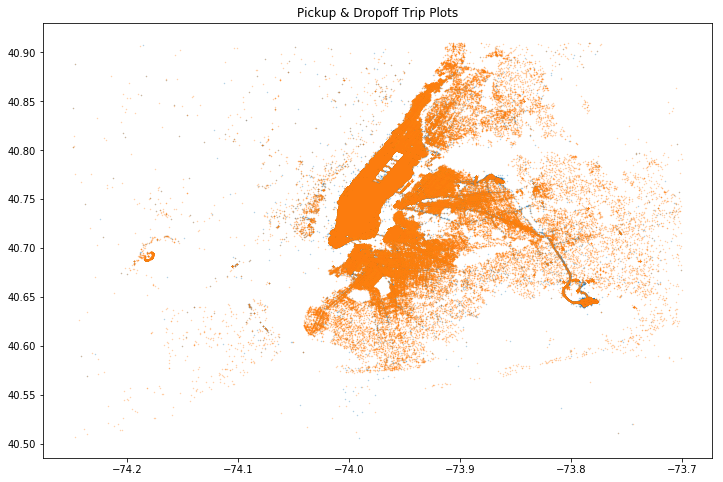

In [5]:
train=lat_long(train)

### Passenger count 
Discard records with zero passengers and nine passengers since these two cases are unreasonable both for taxi trip and policy.

In [6]:
def passenger(train):
    train = train[(train.passenger_count > 0) & (train.passenger_count < 9)]
    
    return train

In [7]:
train = passenger(train)

### Travel time

Only kept data whose travel time is larger than 10 seconds and less than 8 hours(Longest uber trip in NYC histroy: https://nypost.com/2016/12/10/the-longest-ride-in-uber-history/). And we found that travel time subject ot lognormal distribution. 

Because difference between travel times is huge (some trips only took few minutes while others took hours), we took its log value as our feature.

In [8]:
#show the distribution of travel time, remove outliers
def travel_time(data):
    #remove data whose travel time is less than 10 seconds
    data=data[data['travel_time']>10]
    #remove data whose travel time is more than 8 hours
    data=data[data['travel_time']<30000]
    plt.figure(figsize=(12,6))
    plt.grid(False)
    plt.hist(data['travel_time'],bins=500, label = 'trip duration', rwidth = 0.9)
    plt.xlabel('travel time (seconds)')
    plt.xlim(-100,6000)
    plt.title('travel time distribution')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,6))
    data['travel_time']=np.log(data['travel_time'].copy())
    plt.grid(False)
    plt.hist(data['travel_time'],bins=100, label = 'trip duration', rwidth = 0.9)
    plt.xlabel('travel time (log seconds)')
    plt.title('travel time distribution (after taking log)')
    plt.legend()
    plt.show()
    return data
   

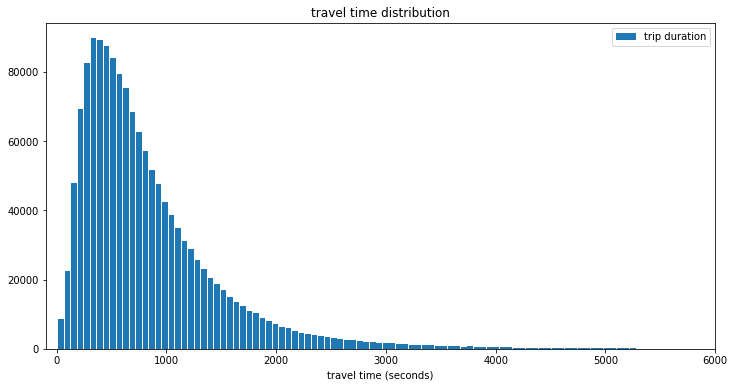

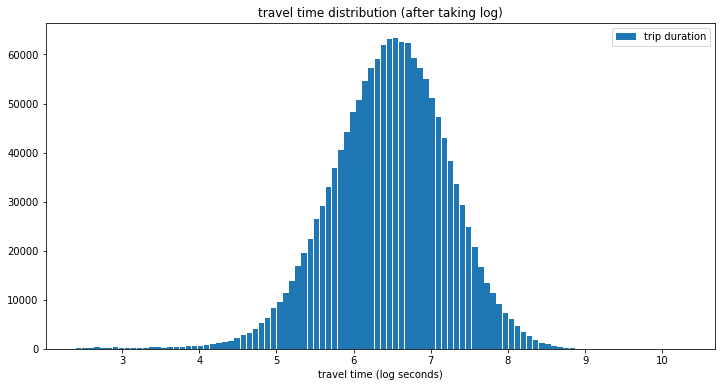

In [9]:
train=travel_time(train)

### Time features: hours, week and month

In this section we showed that time in a day is an important feature, while weeday and month are not.

In [10]:
#analysis the distribution among time
def time(train):
    train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime).copy()
    train['month'] = train.pickup_datetime.dt.month.copy()
    train['week'] = train.pickup_datetime.dt.week.copy()
    train['weekday'] = train.pickup_datetime.dt.weekday.copy()
    train['hour'] = train.pickup_datetime.dt.hour.copy()
    train['minute'] = train.pickup_datetime.dt.minute.copy()
    train['minute_oftheday'] = train['hour'] .copy()* 60 + train['minute'].copy()
    train.drop(['minute'], axis=1, inplace=True)

    
    wkd_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.figure(figsize = (12, 3))
    data_wkd = train.groupby('weekday').aggregate({'pickup_datetime': 'count'}).reset_index()
    sns.barplot(x = 'weekday', y = 'pickup_datetime', data = data_wkd)
    plt.title('amount of trip records distribution')
    plt.xlabel('weekday')
    plt.xticks(range(0, 7), wkd_names)
    plt.ylabel('amount of trips')
    plt.show()
    
    mt_names = ['January', 'February', 'March', 'April', 'May', 'June']
    plt.figure(figsize = (12, 3))

    data_mt = train.groupby('month').aggregate({'pickup_datetime': 'count'}).reset_index()
    sns.barplot(x = 'month', y = 'pickup_datetime', data = data_mt)

    plt.title('amount of trip records distribution')
    plt.xlabel('month')
    plt.xticks(range(0, 6), mt_names)
    plt.ylabel('amount of trips')
    plt.show()
    plt.figure(figsize = (12, 3))

    data_h = train.groupby('hour').aggregate({'pickup_datetime': 'count'}).reset_index()
    sns.barplot(x = 'hour', y = 'pickup_datetime', data = data_h)

    plt.title('amount of trip records distribution')
    plt.xlabel('hour of a day: 0 - 23')
    plt.ylabel('amount of trips')
    plt.show()
    return train

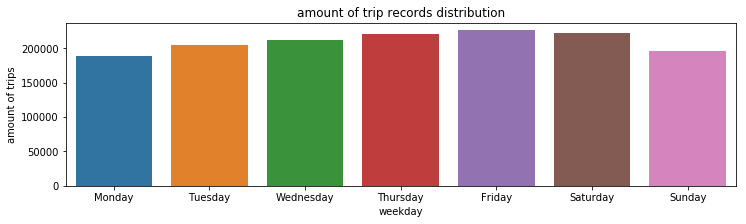

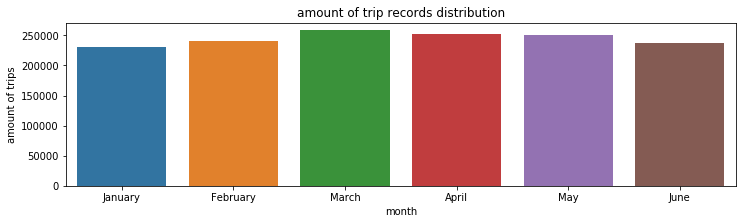

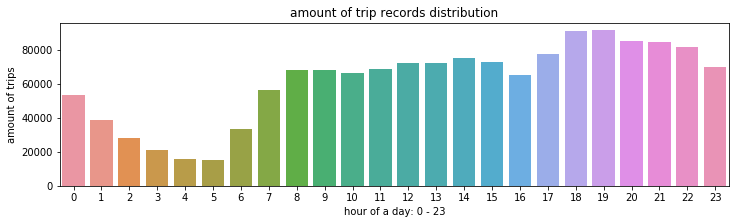

In [11]:
train=time(train)

From the 3 plots above we can see that the amount of trips does not vary much across weekdays and months, but does flunctuate within one day.
So we take time in a day as a feature.

In [12]:
#heatmap for hour & weekday
def heatmap(train):
    plt.figure(figsize = (12, 3))
    
    sns.heatmap(data = pd.crosstab(train['weekday'], train['hour'], values = train.pickup_datetime,
                                   aggfunc = 'count', normalize = 'index'), cmap='BuPu')
    wkd_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.title('trip amount heatmap of weekday & hour')
    plt.xlabel('hour of a day: 0 - 23')
    plt.ylabel('weekday')
    plt.yticks(range(0, 7), wkd_names, rotation = '20')
    plt.show()
    #heatmap for weekday & month
    mt_names = ['January', 'February', 'March', 'April', 'May', 'June']
    fig1=plt.figure(figsize = (12, 3))
    sns.heatmap(data = pd.crosstab(train['month'], train['weekday'], values = train.pickup_datetime, 
                                   aggfunc = 'count', normalize = 'index'), cmap='Blues')
    plt.title('trip amount heatmap of month & weekday')
    plt.xlabel('weekday')
    plt.xticks(range(0, 7), wkd_names, rotation = '10')
    plt.ylabel('month')
    plt.yticks(range(0, 6), mt_names, rotation = '0')
    plt.show()
    train.drop(['pickup_datetime'], axis=1, inplace=True)
    train.drop(['hour'],axis=1,inplace=True)
    
    return train

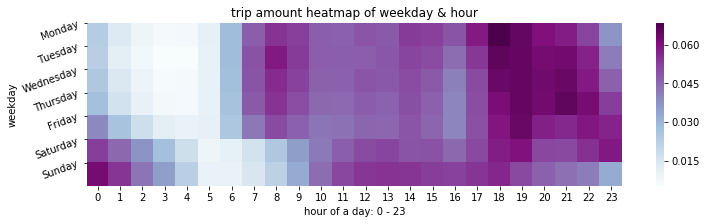

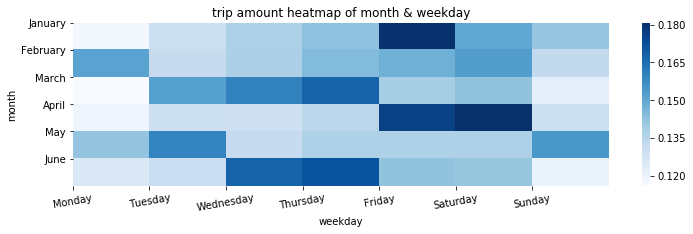

In [13]:
train=heatmap(train)

### Distance & Speed

Calculated Haversine distance based on longitudes and latitudes. Removed distance that is larger than the diameter of NYC (60 km) or is too short (less than 10 meters). Demonstrate the distance distribution.

Calculated approximating speed based on Haversine distance and travel time. The aim is to remove outliers whose speed is abnormally large. Those outliers might elude previous cleaning because their travel time and distance seem normal when judging seperately.

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    r=6371.0 # average radius of earth
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    distance=2 * r * np.arcsin(np.sqrt(a))
    return distance

In [15]:
#compute distance based on longitudes and latitudes, show the distribution of distance, remove outliers
def distance(train):
    train['distance'] = haversine(train['pickup_latitude'].values.copy(), train['pickup_longitude'].values.copy(),\
                                  train['dropoff_latitude'].values.copy(), train['dropoff_longitude'].values.copy())
    #the diameter of new york city is less than 60 km 
    train=train[train['distance']<60]
    train=train[train['distance']>0.01]
    plt.figure(figsize = (12, 8))
    plt.hist(train['distance'], bins=200,label = 'distance', rwidth = 0.9)
    plt.xlabel('Direct distance between pickup and dropoff locations(km)')
    plt.ylabel('Count')
    plt.title('Distribution of distance')
    plt.legend()
    plt.show()
    
    train['speed']= train.distance.copy() / (np.exp(train.travel_time.copy())/3600.0)
    train=train[train['speed']<500]
    plt.figure(figsize=(12,8))
    plt.hist(train.speed, bins=500,label = 'speed', rwidth = 0.9)
    plt.xlim(-10,300)
    plt.xlabel('Approximating average travel speed (km/h)')
    plt.ylabel('Count')
    plt.title('Distribution of speed')
    plt.legend()
    plt.show()
    train.drop(['speed'], axis=1, inplace=True)
    return train

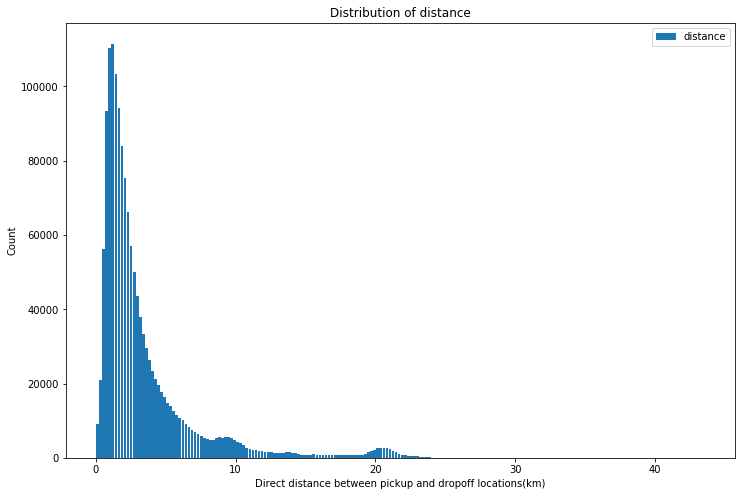

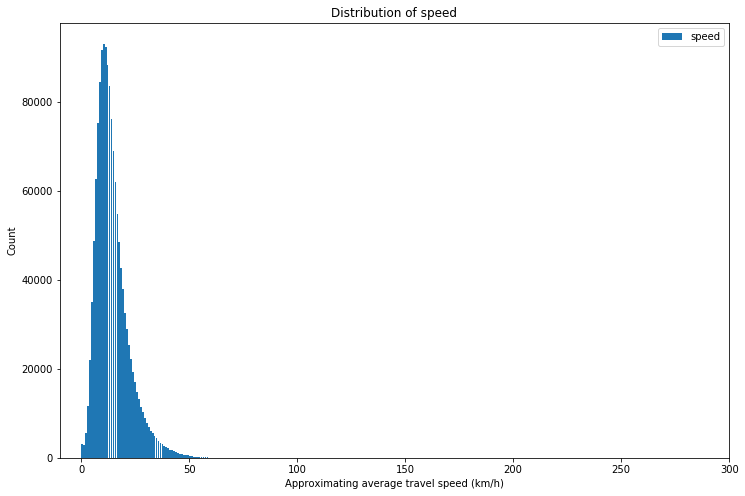

In [16]:
trian=distance(train)

### Direction feature

The direction from pickup point to dropoff point.

In [17]:
def ft_degree(lat1, lng1, lat2, lng2):
    #r = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    
    return np.degrees(np.arctan2(y, x))

In [18]:
#Direction feature
def direction(train):
    train['direction'] = ft_degree(train['pickup_latitude'].copy().values, train['pickup_longitude'].copy().values, \
                               train['dropoff_latitude'].copy().values, train['dropoff_longitude'].copy().values)
    return train

In [19]:
train=direction(train)

In [20]:
train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,travel_time,month,week,weekday,minute_oftheday,distance,direction
0,-73.988441,40.738609,-73.975731,40.753334,1,6.419995,1,4,3,664,1.956362,33.179701
1,-73.789650,40.646732,-73.846825,40.652962,1,6.475433,2,8,3,1401,4.872974,-81.809286
2,-73.982162,40.778976,-73.988640,40.774876,2,5.855072,1,4,1,1056,0.710916,-129.894842
3,-73.863022,40.768826,-73.986191,40.758179,1,8.073403,4,15,3,768,10.440659,-96.470591
4,-73.982933,40.742111,-73.987244,40.722260,1,6.802395,1,1,5,1422,2.237089,-170.654744


In [21]:
def show_corr(train):
    plt.figure(figsize = (18, 6))
    features=train.copy()
    sns.heatmap(data = features.corr(), annot = True, cmap = plt.cm.RdYlBu_r, linewidths=.1)

    plt.title('Correlations between variables')
    plt.show()

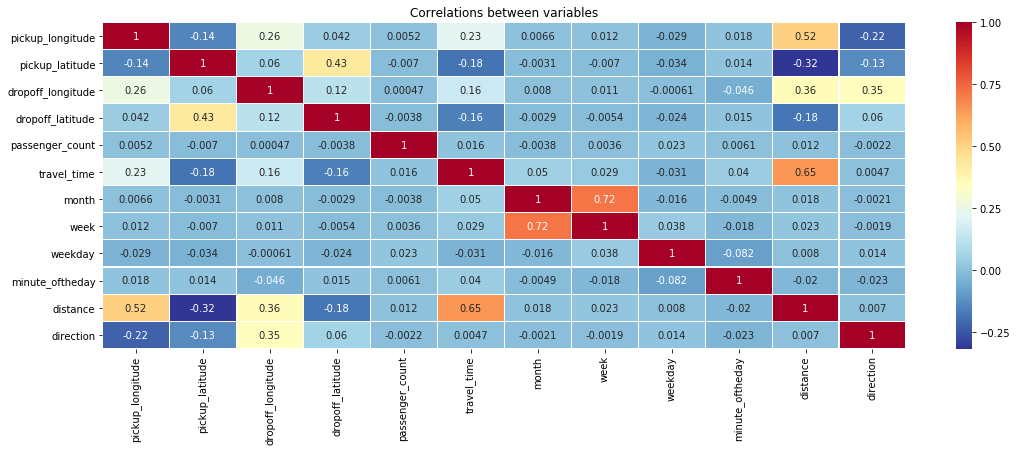

In [22]:
show_corr(train)

### Test data preprocessing 

Generate features we need.

In [51]:
def preprocess(test):
    test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime).copy()
    test['month'] = test.pickup_datetime.dt.month.copy()
    test['week'] = test.pickup_datetime.dt.week.copy()
    test['weekday'] = test.pickup_datetime.dt.weekday.copy()
    test['hour'] = test.pickup_datetime.dt.hour.copy()
    test['minute'] = test.pickup_datetime.dt.minute.copy()
    test['minute_oftheday'] = test['hour'] .copy()* 60 + test['minute'].copy()
    test.drop(['minute'], axis=1, inplace=True)
    test.drop(['hour'], axis=1, inplace=True)
    test.drop(['pickup_datetime'], axis=1, inplace=True)
    test['distance'] = haversine(test['pickup_latitude'].values.copy(), test['pickup_longitude'].values.copy(),
                                  test['dropoff_latitude'].values.copy(), test['dropoff_longitude'].values.copy())
    test['direction']= ft_degree(test['pickup_latitude'].copy().values, test['pickup_longitude'].copy().values, 
                               test['dropoff_latitude'].copy().values, test['dropoff_longitude'].copy().values)
    return test

In [86]:
test=preprocess(pd.read_csv('APM4990_final_test_data_filtered.csv'))

In [87]:
test.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,month,week,weekday,minute_oftheday,distance,direction
0,40.702740,-74.011650,40.773361,-73.990311,5,6,25,3,1312,8.055939,12.888736
1,40.733608,-74.003098,40.836803,-73.941643,1,11,45,6,142,12.587349,24.250830
2,40.730911,-74.001442,40.665699,-73.956909,1,2,7,4,251,8.165491,152.613279
3,40.774078,-73.874550,40.749939,-73.991203,2,7,30,3,554,10.184872,-105.242468
4,40.791588,-73.964874,40.792084,-73.968254,2,1,2,2,1086,0.289822,-79.030706


## Model selection & training

### Model preparation

In [23]:
def data_split(train):
    y = train['travel_time']
    train.drop(['travel_time'], axis = 1, inplace =True)
    X = train.copy()
    z_1 = train.copy()
    z_2 = y.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train_2, X_dev, y_train_2, y_dev = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
    
    return X_train, X_test, y_train, y_test, X_train_2, X_dev, y_train_2, y_dev, z_1, z_2

In [24]:
d_set = data_split(train)

### Multivariate linear model

In [41]:
def linear_model(d_set):
    lr = LinearRegression()
    lr.fit(d_set[0], d_set[2])
    train_sc = lr.score(d_set[0], d_set[2])
    test_sc = lr.score(d_set[1], d_set[3])
    y_pred_lr = lr.predict(d_set[1])
    rmse = np.sqrt(mse(d_set[3], y_pred_lr))
    v_exp = metrics.explained_variance_score(d_set[3], y_pred_lr)
    R_2 = metrics.r2_score(d_set[3], y_pred_lr)
    rmsle = np.sqrt(msle(d_set[3], y_pred_lr))
    
    print('R^2 score is {}, rmse is {}, rmsle is {}'.format(R_2, rmse, rmsle))
    print( )
    print('linear training model score is {}, test model score is {}'.format(train_sc, test_sc))
    print( )
    print('{} of the variation in the dependent variable is explained by multivariate linear model'.format(v_exp))
    
    plt.plot(d_set[3], y_pred_lr, label = 'fit')
    plt.legend()
    plt.show()

R^2 score is 0.4600891398815945, rmse is 0.5549014580023318, rmsle is 0.07886545750653705

linear training model score is 0.4579546762297917, test model score is 0.46008913988159444

0.46009142559285365 of the variation in the dependent variable is explained by multivariate linear model


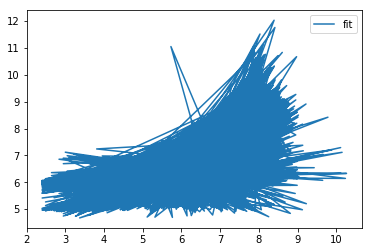

In [42]:
linear_model(d_set)

#### Conclusion 
The model score of test set does not indicate obvious overfitting. 

### Random forest model

In [43]:
def rfr(d_set):
    rf = RandomForestRegressor(n_estimators=200, max_depth = 50, min_samples_split = 10, n_jobs = -1)
    rf.fit(d_set[0], d_set[2])
    train_sc = rf.score(d_set[0], d_set[2])
    test_sc = rf.score(d_set[1], d_set[3])
    y_pred_rf = rf.predict(d_set[1])
    rmse = np.sqrt(mse(d_set[3], y_pred_rf))
    v_exp = metrics.explained_variance_score(d_set[3], y_pred_rf)
    R_2 = metrics.r2_score(d_set[3], y_pred_rf)
    rmsle = np.sqrt(msle(d_set[3], y_pred_rf))
    
    print('R^2 score is {}, rmse is {}, rmsle is {}'.format(R_2, rmse, rmsle))
    print( )
    print('Random forest training model score is {}, test model score is {}'.format(train_sc, test_sc))
    print( )
    print('{} of the variation in the dependent variable is explained by random forest model'.format(v_exp))


In [44]:
%%time
rfr(d_set)

R^2 score is 0.8020634219855779, rmse is 0.33598343291830685, rmsle is 0.04904763845331772

Random forest training model score is 0.9397561257671693, test model score is 0.8020634219855779

0.8020944838725472 of the variation in the dependent variable is explained by random forest model
CPU times: user 58min 43s, sys: 14.1 s, total: 58min 57s
Wall time: 7min 48s


#### Evaluation on Random forest model
Radomforest regressor takes too much time for fitting the training data set, even with original setting parameters. It is unreasonable to tune parameters using this model if we want to improve efficiency in the following sections.

### Light Gradient Boosting Machine (LightGBM)

#### Fastness and Cross Validation (in k = 5 folders)

In [45]:
def light(d_set):
    lgbR = LGBMRegressor()
    lgbR.fit(d_set[0], d_set[2])
    train_sc = lgbR.score(d_set[0], d_set[2])
    test_sc = lgbR.score(d_set[1], d_set[3])
    y_pred_lgbR = lgbR.predict(d_set[1])
    rmse = np.sqrt(mse(d_set[3], y_pred_lgbR))
    v_exp = metrics.explained_variance_score(d_set[3], y_pred_lgbR)
    R_2 = metrics.r2_score(d_set[3], y_pred_lgbR)
    rmsle = np.sqrt(msle(d_set[3], y_pred_lgbR))
    
    print('R^2 score is {}, rmse is {}, rmsle is {}'.format(R_2, rmse, rmsle))
    print( )
    print('LightGBM training model score is {}, test model score is {}'.format(train_sc, test_sc))
    print( )
    print('{} of the variation in the dependent variable is explained by random forest model'.format(v_exp))



In [46]:
%%time
light(d_set)

R^2 score is 0.7836501846029574, rmse is 0.35126356021577687, rmsle is 0.05110447304722227

LightGBM training model score is 0.7850950809417497, test model score is 0.7836501846029573

0.7836503422008565 of the variation in the dependent variable is explained by random forest model
CPU times: user 36 s, sys: 373 ms, total: 36.4 s
Wall time: 4.89 s


In [25]:
def light_cv(d_set):
    lgbR = LGBMRegressor()
    cv_score_lgb = cross_val_score(lgbR, d_set[8], d_set[9], cv = 5, n_jobs = -1)
    print('cross validation score for Lightgbm is {}'.format(cv_score_lgb))
    print( )
    print('average cv score {} indicates stability'.format(np.mean(cv_score_lgb)))

In [26]:
light_cv(d_set)

cross validation score for Lightgbm is [0.78442906 0.78410811 0.78396068 0.78249534 0.7822191 ]

average cv score 0.7834424586527874 indicates stability


#### Hyperparameter tuning part I 
#### Pre training

In [27]:
#easy example for several important parameters tuning of lightgbm
def pre_tr(d_set):
    lgbR = LGBMRegressor()
    n_estimators = np.arange(80, 1200, 100)
    scores_1 = []
    for n in n_estimators:
        lgbR.set_params(n_estimators = n)
        lgbR.fit(d_set[0], d_set[2])
        scores_1.append(lgbR.score(d_set[1], d_set[3]))

    plt.plot(n_estimators, scores_1)
    plt.title("Effect of n_estimators")
    plt.xlabel("n_estimator")
    plt.ylabel("R^2 score")
    plt.show()

    max_depth = np.arange(8, 99, 10)
    scores_2 = []
    for n in max_depth:
        lgbR.set_params(max_depth = n)
        lgbR.fit(d_set[0], d_set[2])
        scores_2.append(lgbR.score(d_set[1], d_set[3]))

    plt.plot(max_depth, scores_2)
    plt.title("Effect of max_depth")
    plt.xlabel("max_depth")
    plt.ylabel("R^2 score")
    plt.show()

    num_leaves = np.arange(80, 1100, 100)
    scores_3 = []
    for n in num_leaves:
        lgbR.set_params(num_leaves = n)
        lgbR.fit(d_set[0], d_set[2])
        scores_3.append(lgbR.score(d_set[1], d_set[3]))

    plt.plot(num_leaves, scores_3)
    plt.title("Effect of num_leaves")
    plt.xlabel("num_leaves")
    plt.ylabel("R^2 score")
    plt.show()

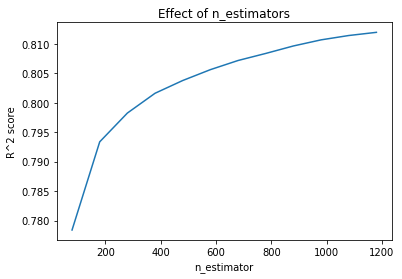

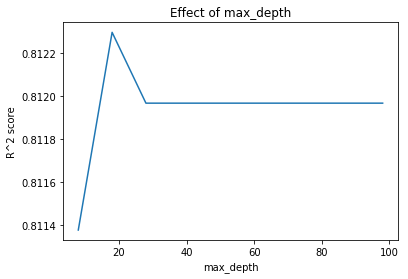

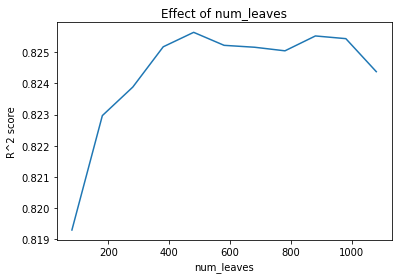

In [28]:
pre_tr(d_set)

#### Hyperparameter tuning part II
#### Monte Carlo Method
$n \geq 1000$ iterations leads to at least $1 - \frac{1}{\sqrt{n}} \approx 97\%$ accuracy to achieve optimal model score.
Tune parameters based on above range and references: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [43]:
def mc_tuning(d_set):
    #number of leaves \leq 2^(max_depth)
    num_iterations = 200
    results_lgb = pd.DataFrame(columns=["rmse", "n_estimators", "num_leaves", "max_depth", "feature_fraction", "bagging_fraction", "bagging_freq",
                                    "learning_rate", "model score"])

    for i in range(num_iterations):
        num_leaves = np.random.randint(400, 950)
        max_depth = np.random.randint(12, 35)
        feature_fraction = np.random.uniform(0.5,1)
        bagging_fraction = np.random.uniform(0.4,1)
        bagging_freq = np.random.randint(3,10)
        learning_rate = np.random.uniform(0.1,0.999)
        n_estimators = np.random.randint(999, 1300)
        early_stopping_rounds = 5

        lgb_search = LGBMRegressor(objective = 'regression', boosting_type = 'gbdt', num_leaves = num_leaves, max_depth = max_depth,
                            feature_fraction = feature_fraction,
                            bagging_fraction = bagging_fraction,
                            bagging_freq = bagging_freq,
                            learning_rate = learning_rate,
                            n_estimators = n_estimators)
    
        lgb_search.fit(d_set[4], d_set[6],
            eval_set = [(d_set[5], d_set[7])],
            eval_metric = 'rmse', early_stopping_rounds = early_stopping_rounds)
    
        model_score = lgb_search.score(d_set[1], d_set[3])
        y_preds_lgb = lgb_search.predict(d_set[1], num_iteration = lgb_search.best_iteration_)
        rmse_lgb = np.sqrt(mse(d_set[3], y_preds_lgb))
        if (d_set[3] < 0).any() or (y_preds_lgb < 0).any():
            rmsle_lgb = 0
        else:
            rmsle_lgb = np.sqrt(msle(d_set[3], y_preds_lgb))
        
        print("the {0}th iteration has score {1} with rmse {2} and rmsle {3}.".format(i+1, model_score, rmse_lgb, rmsle_lgb))
        print()
    
        each_row = pd.DataFrame([[rmse_lgb, rmsle_lgb, n_estimators, num_leaves, max_depth, feature_fraction, bagging_fraction,
                             bagging_freq,
                             learning_rate, model_score]],
                         columns = ["rmse", "rmsle", "n_estimators", "num_leaves", "max_depth", "feature_fraction", "bagging_fraction",
                                "bagging_freq",
                                "learning_rate", "model score"])
    
# Append the dataframe as a new row in result
        results_lgb = results_lgb.append(each_row, ignore_index=True)
    
    return results_lgb

In [44]:
result = mc_tuning(d_set)

[1]	valid_0's rmse: 0.586772	valid_0's l2: 0.344302
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.486764	valid_0's l2: 0.236939
[3]	valid_0's rmse: 0.429523	valid_0's l2: 0.18449
[4]	valid_0's rmse: 0.398038	valid_0's l2: 0.158435
[5]	valid_0's rmse: 0.380118	valid_0's l2: 0.14449
[6]	valid_0's rmse: 0.370502	valid_0's l2: 0.137272
[7]	valid_0's rmse: 0.362247	valid_0's l2: 0.131223
[8]	valid_0's rmse: 0.358037	valid_0's l2: 0.128191
[9]	valid_0's rmse: 0.353601	valid_0's l2: 0.125033
[10]	valid_0's rmse: 0.351188	valid_0's l2: 0.123333
[11]	valid_0's rmse: 0.349412	valid_0's l2: 0.122089
[12]	valid_0's rmse: 0.34777	valid_0's l2: 0.120944
[13]	valid_0's rmse: 0.346759	valid_0's l2: 0.120241
[14]	valid_0's rmse: 0.345035	valid_0's l2: 0.119049
[15]	valid_0's rmse: 0.343356	valid_0's l2: 0.117894
[16]	valid_0's rmse: 0.342645	valid_0's l2: 0.117406
[17]	valid_0's rmse: 0.341522	valid_0's l2: 0.116638
[18]	valid_0's rmse: 0.341247	valid_0's l2: 0.1164

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.423096	valid_0's l2: 0.17901
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.380123	valid_0's l2: 0.144493
[3]	valid_0's rmse: 0.369027	valid_0's l2: 0.136181
[4]	valid_0's rmse: 0.36463	valid_0's l2: 0.132955
[5]	valid_0's rmse: 0.363828	valid_0's l2: 0.132371
[6]	valid_0's rmse: 0.362412	valid_0's l2: 0.131342
[7]	valid_0's rmse: 0.360087	valid_0's l2: 0.129662
[8]	valid_0's rmse: 0.359087	valid_0's l2: 0.128943
[9]	valid_0's rmse: 0.358795	valid_0's l2: 0.128734
[10]	valid_0's rmse: 0.358803	valid_0's l2: 0.12874
[11]	valid_0's rmse: 0.358851	valid_0's l2: 0.128774
[12]	valid_0's rmse: 0.359148	valid_0's l2: 0.128987
[13]	valid_0's rmse: 0.35918	valid_0's l2: 0.12901
[14]	valid_0's rmse: 0.35875	valid_0's l2: 0.128701
[15]	valid_0's rmse: 0.358985	valid_0's l2: 0.12887
[16]	valid_0's rmse: 0.35864	valid_0's l2: 0.128623
[17]	valid_0's rmse: 0.359599	valid_0's l2: 0.129312
[18]	valid_0's rmse: 0.359787	valid_0's l2: 0.129447
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.624397	valid_0's l2: 0.389872
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.534057	valid_0's l2: 0.285217
[3]	valid_0's rmse: 0.473086	valid_0's l2: 0.22381
[4]	valid_0's rmse: 0.432829	valid_0's l2: 0.187341
[5]	valid_0's rmse: 0.406595	valid_0's l2: 0.165319
[6]	valid_0's rmse: 0.390135	valid_0's l2: 0.152206
[7]	valid_0's rmse: 0.378111	valid_0's l2: 0.142968
[8]	valid_0's rmse: 0.370984	valid_0's l2: 0.137629
[9]	valid_0's rmse: 0.364196	valid_0's l2: 0.132639
[10]	valid_0's rmse: 0.359805	valid_0's l2: 0.129459
[11]	valid_0's rmse: 0.356936	valid_0's l2: 0.127404
[12]	valid_0's rmse: 0.354616	valid_0's l2: 0.125753
[13]	valid_0's rmse: 0.353049	valid_0's l2: 0.124644
[14]	valid_0's rmse: 0.351665	valid_0's l2: 0.123668
[15]	valid_0's rmse: 0.349616	valid_0's l2: 0.122232
[16]	valid_0's rmse: 0.348215	valid_0's l2: 0.121254
[17]	valid_0's rmse: 0.347073	valid_0's l2: 0.12046
[18]	valid_0's rmse: 0.346284	valid_0's l2: 0.119

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.415902	valid_0's l2: 0.172975
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379325	valid_0's l2: 0.143887
[3]	valid_0's rmse: 0.369457	valid_0's l2: 0.136499
[4]	valid_0's rmse: 0.366299	valid_0's l2: 0.134175
[5]	valid_0's rmse: 0.363752	valid_0's l2: 0.132316
[6]	valid_0's rmse: 0.363999	valid_0's l2: 0.132495
[7]	valid_0's rmse: 0.362421	valid_0's l2: 0.131349
[8]	valid_0's rmse: 0.362365	valid_0's l2: 0.131309
[9]	valid_0's rmse: 0.36201	valid_0's l2: 0.131051
[10]	valid_0's rmse: 0.361712	valid_0's l2: 0.130836
[11]	valid_0's rmse: 0.36385	valid_0's l2: 0.132387
[12]	valid_0's rmse: 0.36493	valid_0's l2: 0.133174
[13]	valid_0's rmse: 0.365444	valid_0's l2: 0.133549
[14]	valid_0's rmse: 0.365809	valid_0's l2: 0.133816
[15]	valid_0's rmse: 0.366419	valid_0's l2: 0.134263
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.361712	valid_0's l2: 0.130836
the 4th iteration has score 0.7718586060816746 with rmse 0.360708917

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.622415	valid_0's l2: 0.3874
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.529559	valid_0's l2: 0.280433
[3]	valid_0's rmse: 0.469432	valid_0's l2: 0.220367
[4]	valid_0's rmse: 0.432196	valid_0's l2: 0.186793
[5]	valid_0's rmse: 0.4081	valid_0's l2: 0.166545
[6]	valid_0's rmse: 0.390047	valid_0's l2: 0.152136
[7]	valid_0's rmse: 0.376441	valid_0's l2: 0.141708
[8]	valid_0's rmse: 0.368765	valid_0's l2: 0.135987
[9]	valid_0's rmse: 0.362304	valid_0's l2: 0.131264
[10]	valid_0's rmse: 0.356633	valid_0's l2: 0.127187
[11]	valid_0's rmse: 0.352988	valid_0's l2: 0.124601
[12]	valid_0's rmse: 0.350806	valid_0's l2: 0.123065
[13]	valid_0's rmse: 0.347402	valid_0's l2: 0.120688
[14]	valid_0's rmse: 0.345496	valid_0's l2: 0.119367
[15]	valid_0's rmse: 0.343817	valid_0's l2: 0.11821
[16]	valid_0's rmse: 0.342302	valid_0's l2: 0.117171
[17]	valid_0's rmse: 0.341393	valid_0's l2: 0.11655
[18]	valid_0's rmse: 0.340685	valid_0's l2: 0.116066


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.390752	valid_0's l2: 0.152687
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376521	valid_0's l2: 0.141768
[3]	valid_0's rmse: 0.373627	valid_0's l2: 0.139597
[4]	valid_0's rmse: 0.369214	valid_0's l2: 0.136319
[5]	valid_0's rmse: 0.369862	valid_0's l2: 0.136798
[6]	valid_0's rmse: 0.369422	valid_0's l2: 0.136473
[7]	valid_0's rmse: 0.367578	valid_0's l2: 0.135113
[8]	valid_0's rmse: 0.367708	valid_0's l2: 0.135209
[9]	valid_0's rmse: 0.369205	valid_0's l2: 0.136312
[10]	valid_0's rmse: 0.370757	valid_0's l2: 0.13746
[11]	valid_0's rmse: 0.371565	valid_0's l2: 0.13806
[12]	valid_0's rmse: 0.37395	valid_0's l2: 0.139839
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.367578	valid_0's l2: 0.135113
the 6th iteration has score 0.7638991273118292 with rmse 0.3669472442078296 and rmsle 0.05383246717815345.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.413376	valid_0's l2: 0.17088
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379859	valid_0's l2: 0.144293
[3]	valid_0's rmse: 0.371932	valid_0's l2: 0.138334
[4]	valid_0's rmse: 0.367205	valid_0's l2: 0.134839
[5]	valid_0's rmse: 0.363825	valid_0's l2: 0.132369
[6]	valid_0's rmse: 0.36075	valid_0's l2: 0.130141
[7]	valid_0's rmse: 0.360007	valid_0's l2: 0.129605
[8]	valid_0's rmse: 0.359721	valid_0's l2: 0.129399
[9]	valid_0's rmse: 0.358767	valid_0's l2: 0.128714
[10]	valid_0's rmse: 0.359275	valid_0's l2: 0.129078
[11]	valid_0's rmse: 0.359318	valid_0's l2: 0.129109
[12]	valid_0's rmse: 0.360552	valid_0's l2: 0.129997
[13]	valid_0's rmse: 0.360558	valid_0's l2: 0.130002
[14]	valid_0's rmse: 0.359757	valid_0's l2: 0.129425
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.358767	valid_0's l2: 0.128714
the 7th iteration has score 0.7742494804613944 with rmse 0.3588138626678137 and rmsle 0.05251296309246656.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.637123	valid_0's l2: 0.405926
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.551497	valid_0's l2: 0.304149
[3]	valid_0's rmse: 0.491617	valid_0's l2: 0.241687
[4]	valid_0's rmse: 0.448323	valid_0's l2: 0.200994
[5]	valid_0's rmse: 0.418694	valid_0's l2: 0.175304
[6]	valid_0's rmse: 0.398847	valid_0's l2: 0.159079
[7]	valid_0's rmse: 0.384562	valid_0's l2: 0.147888
[8]	valid_0's rmse: 0.375744	valid_0's l2: 0.141183
[9]	valid_0's rmse: 0.36834	valid_0's l2: 0.135675
[10]	valid_0's rmse: 0.362782	valid_0's l2: 0.131611
[11]	valid_0's rmse: 0.358802	valid_0's l2: 0.128739
[12]	valid_0's rmse: 0.356135	valid_0's l2: 0.126832
[13]	valid_0's rmse: 0.353484	valid_0's l2: 0.124951
[14]	valid_0's rmse: 0.351591	valid_0's l2: 0.123616
[15]	valid_0's rmse: 0.349196	valid_0's l2: 0.121938
[16]	valid_0's rmse: 0.34789	valid_0's l2: 0.121028
[17]	valid_0's rmse: 0.346886	valid_0's l2: 0.12033
[18]	valid_0's rmse: 0.345772	valid_0's l2: 0.1195

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.397133	valid_0's l2: 0.157714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.380173	valid_0's l2: 0.144532
[3]	valid_0's rmse: 0.37399	valid_0's l2: 0.139868
[4]	valid_0's rmse: 0.373647	valid_0's l2: 0.139612
[5]	valid_0's rmse: 0.374377	valid_0's l2: 0.140158
[6]	valid_0's rmse: 0.372892	valid_0's l2: 0.139048
[7]	valid_0's rmse: 0.373629	valid_0's l2: 0.139599
[8]	valid_0's rmse: 0.374182	valid_0's l2: 0.140012
[9]	valid_0's rmse: 0.374646	valid_0's l2: 0.140359
[10]	valid_0's rmse: 0.37691	valid_0's l2: 0.142061
[11]	valid_0's rmse: 0.379024	valid_0's l2: 0.143659
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.372892	valid_0's l2: 0.139048
the 9th iteration has score 0.7564628710794714 with rmse 0.37268114850640405 and rmsle 0.05473134145131815.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.542826	valid_0's l2: 0.29466
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.441386	valid_0's l2: 0.194821
[3]	valid_0's rmse: 0.413554	valid_0's l2: 0.171027
[4]	valid_0's rmse: 0.389183	valid_0's l2: 0.151463
[5]	valid_0's rmse: 0.372735	valid_0's l2: 0.138932
[6]	valid_0's rmse: 0.366337	valid_0's l2: 0.134203
[7]	valid_0's rmse: 0.359597	valid_0's l2: 0.12931
[8]	valid_0's rmse: 0.356014	valid_0's l2: 0.126746
[9]	valid_0's rmse: 0.352888	valid_0's l2: 0.12453
[10]	valid_0's rmse: 0.351693	valid_0's l2: 0.123688
[11]	valid_0's rmse: 0.35021	valid_0's l2: 0.122647
[12]	valid_0's rmse: 0.349977	valid_0's l2: 0.122484
[13]	valid_0's rmse: 0.348903	valid_0's l2: 0.121733
[14]	valid_0's rmse: 0.345868	valid_0's l2: 0.119625
[15]	valid_0's rmse: 0.344643	valid_0's l2: 0.118779
[16]	valid_0's rmse: 0.343862	valid_0's l2: 0.118241
[17]	valid_0's rmse: 0.343446	valid_0's l2: 0.117955
[18]	valid_0's rmse: 0.343089	valid_0's l2: 0.11771

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.683631	valid_0's l2: 0.467352
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.62322	valid_0's l2: 0.388403
[3]	valid_0's rmse: 0.573656	valid_0's l2: 0.329082
[4]	valid_0's rmse: 0.532194	valid_0's l2: 0.283231
[5]	valid_0's rmse: 0.498063	valid_0's l2: 0.248066
[6]	valid_0's rmse: 0.470485	valid_0's l2: 0.221356
[7]	valid_0's rmse: 0.447525	valid_0's l2: 0.200279
[8]	valid_0's rmse: 0.43052	valid_0's l2: 0.185347
[9]	valid_0's rmse: 0.415846	valid_0's l2: 0.172928
[10]	valid_0's rmse: 0.403103	valid_0's l2: 0.162492
[11]	valid_0's rmse: 0.392917	valid_0's l2: 0.154384
[12]	valid_0's rmse: 0.384684	valid_0's l2: 0.147982
[13]	valid_0's rmse: 0.378354	valid_0's l2: 0.143151
[14]	valid_0's rmse: 0.373264	valid_0's l2: 0.139326
[15]	valid_0's rmse: 0.368451	valid_0's l2: 0.135756
[16]	valid_0's rmse: 0.364485	valid_0's l2: 0.132849
[17]	valid_0's rmse: 0.361312	valid_0's l2: 0.130546
[18]	valid_0's rmse: 0.35871	valid_0's l2: 0.1286

[157]	valid_0's rmse: 0.325327	valid_0's l2: 0.105838
[158]	valid_0's rmse: 0.325288	valid_0's l2: 0.105812
[159]	valid_0's rmse: 0.325262	valid_0's l2: 0.105795
[160]	valid_0's rmse: 0.325318	valid_0's l2: 0.105832
[161]	valid_0's rmse: 0.325235	valid_0's l2: 0.105778
[162]	valid_0's rmse: 0.325198	valid_0's l2: 0.105754
[163]	valid_0's rmse: 0.325212	valid_0's l2: 0.105763
[164]	valid_0's rmse: 0.325203	valid_0's l2: 0.105757
[165]	valid_0's rmse: 0.325163	valid_0's l2: 0.105731
[166]	valid_0's rmse: 0.325004	valid_0's l2: 0.105628
[167]	valid_0's rmse: 0.325043	valid_0's l2: 0.105653
[168]	valid_0's rmse: 0.32513	valid_0's l2: 0.105709
[169]	valid_0's rmse: 0.325122	valid_0's l2: 0.105705
[170]	valid_0's rmse: 0.325179	valid_0's l2: 0.105742
[171]	valid_0's rmse: 0.325207	valid_0's l2: 0.10576
Early stopping, best iteration is:
[166]	valid_0's rmse: 0.325004	valid_0's l2: 0.105628
the 11th iteration has score 0.8140786907401268 with rmse 0.32562625826182906 and rmsle 0.0479344278381

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.394536	valid_0's l2: 0.155659
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.371668	valid_0's l2: 0.138137
[3]	valid_0's rmse: 0.36883	valid_0's l2: 0.136035
[4]	valid_0's rmse: 0.370505	valid_0's l2: 0.137274
[5]	valid_0's rmse: 0.364475	valid_0's l2: 0.132842
[6]	valid_0's rmse: 0.364647	valid_0's l2: 0.132967
[7]	valid_0's rmse: 0.3661	valid_0's l2: 0.134029
[8]	valid_0's rmse: 0.367215	valid_0's l2: 0.134847
[9]	valid_0's rmse: 0.367945	valid_0's l2: 0.135384
[10]	valid_0's rmse: 0.367799	valid_0's l2: 0.135276
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.364475	valid_0's l2: 0.132842
the 12th iteration has score 0.7668872223253931 with rmse 0.3646178063900336 and rmsle 0.05346268215330057.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.440363	valid_0's l2: 0.19392
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.383707	valid_0's l2: 0.147231
[3]	valid_0's rmse: 0.3721	valid_0's l2: 0.138458
[4]	valid_0's rmse: 0.369445	valid_0's l2: 0.13649
[5]	valid_0's rmse: 0.358803	valid_0's l2: 0.12874
[6]	valid_0's rmse: 0.358056	valid_0's l2: 0.128204
[7]	valid_0's rmse: 0.356554	valid_0's l2: 0.127131
[8]	valid_0's rmse: 0.354817	valid_0's l2: 0.125895
[9]	valid_0's rmse: 0.354584	valid_0's l2: 0.12573
[10]	valid_0's rmse: 0.353438	valid_0's l2: 0.124919
[11]	valid_0's rmse: 0.352688	valid_0's l2: 0.124389
[12]	valid_0's rmse: 0.354265	valid_0's l2: 0.125504
[13]	valid_0's rmse: 0.353848	valid_0's l2: 0.125209
[14]	valid_0's rmse: 0.35369	valid_0's l2: 0.125097
[15]	valid_0's rmse: 0.353655	valid_0's l2: 0.125072
[16]	valid_0's rmse: 0.353957	valid_0's l2: 0.125286
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.352688	valid_0's l2: 0.124389
the 13th iteration 

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.426168	valid_0's l2: 0.181619
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.378449	valid_0's l2: 0.143224
[3]	valid_0's rmse: 0.37108	valid_0's l2: 0.1377
[4]	valid_0's rmse: 0.367132	valid_0's l2: 0.134786
[5]	valid_0's rmse: 0.357781	valid_0's l2: 0.128007
[6]	valid_0's rmse: 0.356935	valid_0's l2: 0.127403
[7]	valid_0's rmse: 0.356003	valid_0's l2: 0.126738
[8]	valid_0's rmse: 0.35472	valid_0's l2: 0.125826
[9]	valid_0's rmse: 0.355314	valid_0's l2: 0.126248
[10]	valid_0's rmse: 0.354294	valid_0's l2: 0.125524
[11]	valid_0's rmse: 0.35363	valid_0's l2: 0.125055
[12]	valid_0's rmse: 0.353488	valid_0's l2: 0.124954
[13]	valid_0's rmse: 0.352958	valid_0's l2: 0.124579
[14]	valid_0's rmse: 0.353719	valid_0's l2: 0.125117
[15]	valid_0's rmse: 0.353978	valid_0's l2: 0.125301
[16]	valid_0's rmse: 0.353659	valid_0's l2: 0.125075
[17]	valid_0's rmse: 0.354086	valid_0's l2: 0.125377
[18]	valid_0's rmse: 0.353968	valid_0's l2: 0.125293

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.54781	valid_0's l2: 0.300095
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.444718	valid_0's l2: 0.197774
[3]	valid_0's rmse: 0.419352	valid_0's l2: 0.175856
[4]	valid_0's rmse: 0.391778	valid_0's l2: 0.15349
[5]	valid_0's rmse: 0.374574	valid_0's l2: 0.140306
[6]	valid_0's rmse: 0.366933	valid_0's l2: 0.13464
[7]	valid_0's rmse: 0.359714	valid_0's l2: 0.129394
[8]	valid_0's rmse: 0.356184	valid_0's l2: 0.126867
[9]	valid_0's rmse: 0.353313	valid_0's l2: 0.12483
[10]	valid_0's rmse: 0.351402	valid_0's l2: 0.123483
[11]	valid_0's rmse: 0.350453	valid_0's l2: 0.122817
[12]	valid_0's rmse: 0.35027	valid_0's l2: 0.122689
[13]	valid_0's rmse: 0.349352	valid_0's l2: 0.122046
[14]	valid_0's rmse: 0.346582	valid_0's l2: 0.120119
[15]	valid_0's rmse: 0.346041	valid_0's l2: 0.119745
[16]	valid_0's rmse: 0.345485	valid_0's l2: 0.11936
[17]	valid_0's rmse: 0.345251	valid_0's l2: 0.119198
[18]	valid_0's rmse: 0.345567	valid_0's l2: 0.119416


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.471358	valid_0's l2: 0.222178
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.392766	valid_0's l2: 0.154265
[3]	valid_0's rmse: 0.371203	valid_0's l2: 0.137792
[4]	valid_0's rmse: 0.36044	valid_0's l2: 0.129917
[5]	valid_0's rmse: 0.356801	valid_0's l2: 0.127307
[6]	valid_0's rmse: 0.354717	valid_0's l2: 0.125824
[7]	valid_0's rmse: 0.350805	valid_0's l2: 0.123064
[8]	valid_0's rmse: 0.349054	valid_0's l2: 0.121839
[9]	valid_0's rmse: 0.348181	valid_0's l2: 0.12123
[10]	valid_0's rmse: 0.347413	valid_0's l2: 0.120696
[11]	valid_0's rmse: 0.347009	valid_0's l2: 0.120416
[12]	valid_0's rmse: 0.347203	valid_0's l2: 0.12055
[13]	valid_0's rmse: 0.346066	valid_0's l2: 0.119761
[14]	valid_0's rmse: 0.345643	valid_0's l2: 0.119469
[15]	valid_0's rmse: 0.345207	valid_0's l2: 0.119168
[16]	valid_0's rmse: 0.34509	valid_0's l2: 0.119087
[17]	valid_0's rmse: 0.345649	valid_0's l2: 0.119473
[18]	valid_0's rmse: 0.345852	valid_0's l2: 0.11961

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.398646	valid_0's l2: 0.158918
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.378052	valid_0's l2: 0.142924
[3]	valid_0's rmse: 0.370781	valid_0's l2: 0.137478
[4]	valid_0's rmse: 0.368599	valid_0's l2: 0.135865
[5]	valid_0's rmse: 0.368122	valid_0's l2: 0.135514
[6]	valid_0's rmse: 0.368928	valid_0's l2: 0.136108
[7]	valid_0's rmse: 0.368922	valid_0's l2: 0.136103
[8]	valid_0's rmse: 0.368286	valid_0's l2: 0.135634
[9]	valid_0's rmse: 0.368488	valid_0's l2: 0.135784
[10]	valid_0's rmse: 0.369638	valid_0's l2: 0.136632
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.368122	valid_0's l2: 0.135514
the 17th iteration has score 0.7627246934746915 with rmse 0.3678587627888328 and rmsle 0.05365833250868518.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.709264	valid_0's l2: 0.503055
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.570943	valid_0's l2: 0.325976
[3]	valid_0's rmse: 0.558077	valid_0's l2: 0.31145
[4]	valid_0's rmse: 0.477956	valid_0's l2: 0.228442
[5]	valid_0's rmse: 0.469414	valid_0's l2: 0.220349
[6]	valid_0's rmse: 0.426605	valid_0's l2: 0.181992
[7]	valid_0's rmse: 0.405526	valid_0's l2: 0.164451
[8]	valid_0's rmse: 0.393627	valid_0's l2: 0.154942
[9]	valid_0's rmse: 0.378814	valid_0's l2: 0.1435
[10]	valid_0's rmse: 0.372736	valid_0's l2: 0.138932
[11]	valid_0's rmse: 0.367668	valid_0's l2: 0.13518
[12]	valid_0's rmse: 0.36225	valid_0's l2: 0.131225
[13]	valid_0's rmse: 0.359851	valid_0's l2: 0.129493
[14]	valid_0's rmse: 0.358318	valid_0's l2: 0.128392
[15]	valid_0's rmse: 0.35636	valid_0's l2: 0.126992
[16]	valid_0's rmse: 0.353868	valid_0's l2: 0.125222
[17]	valid_0's rmse: 0.352803	valid_0's l2: 0.12447
[18]	valid_0's rmse: 0.352212	valid_0's l2: 0.124053
[

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.672906	valid_0's l2: 0.452802
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.605818	valid_0's l2: 0.367015
[3]	valid_0's rmse: 0.551378	valid_0's l2: 0.304018
[4]	valid_0's rmse: 0.508267	valid_0's l2: 0.258336
[5]	valid_0's rmse: 0.473935	valid_0's l2: 0.224615
[6]	valid_0's rmse: 0.447587	valid_0's l2: 0.200334
[7]	valid_0's rmse: 0.426301	valid_0's l2: 0.181733
[8]	valid_0's rmse: 0.410394	valid_0's l2: 0.168424
[9]	valid_0's rmse: 0.397033	valid_0's l2: 0.157635
[10]	valid_0's rmse: 0.386632	valid_0's l2: 0.149484
[11]	valid_0's rmse: 0.378764	valid_0's l2: 0.143462
[12]	valid_0's rmse: 0.372487	valid_0's l2: 0.138747
[13]	valid_0's rmse: 0.367569	valid_0's l2: 0.135107
[14]	valid_0's rmse: 0.363848	valid_0's l2: 0.132386
[15]	valid_0's rmse: 0.359767	valid_0's l2: 0.129433
[16]	valid_0's rmse: 0.356822	valid_0's l2: 0.127322
[17]	valid_0's rmse: 0.354566	valid_0's l2: 0.125717
[18]	valid_0's rmse: 0.352698	valid_0's l2: 0.1

[155]	valid_0's rmse: 0.324819	valid_0's l2: 0.105507
[156]	valid_0's rmse: 0.324862	valid_0's l2: 0.105536
[157]	valid_0's rmse: 0.324843	valid_0's l2: 0.105523
[158]	valid_0's rmse: 0.324828	valid_0's l2: 0.105513
Early stopping, best iteration is:
[153]	valid_0's rmse: 0.324795	valid_0's l2: 0.105492
the 19th iteration has score 0.8145095414758232 with rmse 0.32524873917094793 and rmsle 0.047905140247220424.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.704208	valid_0's l2: 0.495909
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.553617	valid_0's l2: 0.306492
[3]	valid_0's rmse: 0.540351	valid_0's l2: 0.291979
[4]	valid_0's rmse: 0.459904	valid_0's l2: 0.211512
[5]	valid_0's rmse: 0.452147	valid_0's l2: 0.204437
[6]	valid_0's rmse: 0.412505	valid_0's l2: 0.170161
[7]	valid_0's rmse: 0.394795	valid_0's l2: 0.155863
[8]	valid_0's rmse: 0.385367	valid_0's l2: 0.148508
[9]	valid_0's rmse: 0.370956	valid_0's l2: 0.137609
[10]	valid_0's rmse: 0.366125	valid_0's l2: 0.134048
[11]	valid_0's rmse: 0.361029	valid_0's l2: 0.130342
[12]	valid_0's rmse: 0.356795	valid_0's l2: 0.127303
[13]	valid_0's rmse: 0.354573	valid_0's l2: 0.125722
[14]	valid_0's rmse: 0.353363	valid_0's l2: 0.124865
[15]	valid_0's rmse: 0.352002	valid_0's l2: 0.123905
[16]	valid_0's rmse: 0.349689	valid_0's l2: 0.122282
[17]	valid_0's rmse: 0.349208	valid_0's l2: 0.121947
[18]	valid_0's rmse: 0.348571	valid_0's l2: 0.1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.695706	valid_0's l2: 0.484007
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.643	valid_0's l2: 0.413449
[3]	valid_0's rmse: 0.614438	valid_0's l2: 0.377534
[4]	valid_0's rmse: 0.575869	valid_0's l2: 0.331626
[5]	valid_0's rmse: 0.548067	valid_0's l2: 0.300378
[6]	valid_0's rmse: 0.519057	valid_0's l2: 0.269421
[7]	valid_0's rmse: 0.492555	valid_0's l2: 0.24261
[8]	valid_0's rmse: 0.47202	valid_0's l2: 0.222803
[9]	valid_0's rmse: 0.453764	valid_0's l2: 0.205902
[10]	valid_0's rmse: 0.43911	valid_0's l2: 0.192817
[11]	valid_0's rmse: 0.427608	valid_0's l2: 0.182849
[12]	valid_0's rmse: 0.416669	valid_0's l2: 0.173613
[13]	valid_0's rmse: 0.40851	valid_0's l2: 0.16688
[14]	valid_0's rmse: 0.401332	valid_0's l2: 0.161068
[15]	valid_0's rmse: 0.394169	valid_0's l2: 0.155369
[16]	valid_0's rmse: 0.387412	valid_0's l2: 0.150088
[17]	valid_0's rmse: 0.381933	valid_0's l2: 0.145873
[18]	valid_0's rmse: 0.378455	valid_0's l2: 0.143229
[1

[156]	valid_0's rmse: 0.326845	valid_0's l2: 0.106828
[157]	valid_0's rmse: 0.326757	valid_0's l2: 0.10677
[158]	valid_0's rmse: 0.326789	valid_0's l2: 0.106791
[159]	valid_0's rmse: 0.326805	valid_0's l2: 0.106801
[160]	valid_0's rmse: 0.326799	valid_0's l2: 0.106798
[161]	valid_0's rmse: 0.326705	valid_0's l2: 0.106736
[162]	valid_0's rmse: 0.326754	valid_0's l2: 0.106768
[163]	valid_0's rmse: 0.32668	valid_0's l2: 0.10672
[164]	valid_0's rmse: 0.326659	valid_0's l2: 0.106706
[165]	valid_0's rmse: 0.326643	valid_0's l2: 0.106696
[166]	valid_0's rmse: 0.326609	valid_0's l2: 0.106673
[167]	valid_0's rmse: 0.326623	valid_0's l2: 0.106682
[168]	valid_0's rmse: 0.326598	valid_0's l2: 0.106666
[169]	valid_0's rmse: 0.326533	valid_0's l2: 0.106624
[170]	valid_0's rmse: 0.326536	valid_0's l2: 0.106626
[171]	valid_0's rmse: 0.32653	valid_0's l2: 0.106622
[172]	valid_0's rmse: 0.326554	valid_0's l2: 0.106638
[173]	valid_0's rmse: 0.326571	valid_0's l2: 0.106649
[174]	valid_0's rmse: 0.326631	v

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.407337	valid_0's l2: 0.165923
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.378117	valid_0's l2: 0.142972
[3]	valid_0's rmse: 0.369383	valid_0's l2: 0.136444
[4]	valid_0's rmse: 0.366565	valid_0's l2: 0.13437
[5]	valid_0's rmse: 0.364781	valid_0's l2: 0.133065
[6]	valid_0's rmse: 0.362765	valid_0's l2: 0.131598
[7]	valid_0's rmse: 0.362248	valid_0's l2: 0.131224
[8]	valid_0's rmse: 0.361812	valid_0's l2: 0.130908
[9]	valid_0's rmse: 0.362067	valid_0's l2: 0.131093
[10]	valid_0's rmse: 0.363936	valid_0's l2: 0.132449
[11]	valid_0's rmse: 0.363727	valid_0's l2: 0.132298
[12]	valid_0's rmse: 0.365209	valid_0's l2: 0.133378
[13]	valid_0's rmse: 0.366143	valid_0's l2: 0.13406
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.361812	valid_0's l2: 0.130908
the 22th iteration has score 0.7711578529196527 with rmse 0.3612624652445587 and rmsle 0.0529281203566744.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.403523	valid_0's l2: 0.162831
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.373438	valid_0's l2: 0.139456
[3]	valid_0's rmse: 0.369348	valid_0's l2: 0.136418
[4]	valid_0's rmse: 0.368866	valid_0's l2: 0.136062
[5]	valid_0's rmse: 0.36013	valid_0's l2: 0.129693
[6]	valid_0's rmse: 0.358627	valid_0's l2: 0.128613
[7]	valid_0's rmse: 0.358006	valid_0's l2: 0.128168
[8]	valid_0's rmse: 0.356922	valid_0's l2: 0.127393
[9]	valid_0's rmse: 0.356539	valid_0's l2: 0.12712
[10]	valid_0's rmse: 0.355913	valid_0's l2: 0.126674
[11]	valid_0's rmse: 0.355628	valid_0's l2: 0.126471
[12]	valid_0's rmse: 0.356314	valid_0's l2: 0.126959
[13]	valid_0's rmse: 0.356222	valid_0's l2: 0.126894
[14]	valid_0's rmse: 0.356324	valid_0's l2: 0.126967
[15]	valid_0's rmse: 0.356577	valid_0's l2: 0.127147
[16]	valid_0's rmse: 0.357038	valid_0's l2: 0.127476
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.355628	valid_0's l2: 0.126471
the 23th itera

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.60957	valid_0's l2: 0.371575
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.451481	valid_0's l2: 0.203835
[3]	valid_0's rmse: 0.425295	valid_0's l2: 0.180876
[4]	valid_0's rmse: 0.395688	valid_0's l2: 0.156569
[5]	valid_0's rmse: 0.384239	valid_0's l2: 0.14764
[6]	valid_0's rmse: 0.377656	valid_0's l2: 0.142624
[7]	valid_0's rmse: 0.375343	valid_0's l2: 0.140882
[8]	valid_0's rmse: 0.373541	valid_0's l2: 0.139533
[9]	valid_0's rmse: 0.36549	valid_0's l2: 0.133583
[10]	valid_0's rmse: 0.364002	valid_0's l2: 0.132497
[11]	valid_0's rmse: 0.361398	valid_0's l2: 0.130608
[12]	valid_0's rmse: 0.361582	valid_0's l2: 0.130741
[13]	valid_0's rmse: 0.361501	valid_0's l2: 0.130683
[14]	valid_0's rmse: 0.358484	valid_0's l2: 0.128511
[15]	valid_0's rmse: 0.357735	valid_0's l2: 0.127974
[16]	valid_0's rmse: 0.357228	valid_0's l2: 0.127612
[17]	valid_0's rmse: 0.357606	valid_0's l2: 0.127882
[18]	valid_0's rmse: 0.357364	valid_0's l2: 0.1277

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.475692	valid_0's l2: 0.226283
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.396031	valid_0's l2: 0.156841
[3]	valid_0's rmse: 0.380931	valid_0's l2: 0.145109
[4]	valid_0's rmse: 0.372049	valid_0's l2: 0.13842
[5]	valid_0's rmse: 0.360739	valid_0's l2: 0.130133
[6]	valid_0's rmse: 0.358981	valid_0's l2: 0.128867
[7]	valid_0's rmse: 0.355118	valid_0's l2: 0.126109
[8]	valid_0's rmse: 0.352931	valid_0's l2: 0.12456
[9]	valid_0's rmse: 0.352385	valid_0's l2: 0.124175
[10]	valid_0's rmse: 0.351394	valid_0's l2: 0.123478
[11]	valid_0's rmse: 0.350646	valid_0's l2: 0.122953
[12]	valid_0's rmse: 0.350823	valid_0's l2: 0.123077
[13]	valid_0's rmse: 0.350433	valid_0's l2: 0.122803
[14]	valid_0's rmse: 0.348208	valid_0's l2: 0.121249
[15]	valid_0's rmse: 0.347648	valid_0's l2: 0.120859
[16]	valid_0's rmse: 0.347423	valid_0's l2: 0.120703
[17]	valid_0's rmse: 0.34772	valid_0's l2: 0.120909
[18]	valid_0's rmse: 0.348085	valid_0's l2: 0.1211

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.400515	valid_0's l2: 0.160413
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376826	valid_0's l2: 0.141997
[3]	valid_0's rmse: 0.372125	valid_0's l2: 0.138477
[4]	valid_0's rmse: 0.370136	valid_0's l2: 0.137001
[5]	valid_0's rmse: 0.362844	valid_0's l2: 0.131656
[6]	valid_0's rmse: 0.363363	valid_0's l2: 0.132032
[7]	valid_0's rmse: 0.363526	valid_0's l2: 0.132151
[8]	valid_0's rmse: 0.362985	valid_0's l2: 0.131758
[9]	valid_0's rmse: 0.362916	valid_0's l2: 0.131708
[10]	valid_0's rmse: 0.36334	valid_0's l2: 0.132016
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.362844	valid_0's l2: 0.131656
the 26th iteration has score 0.7676322384992275 with rmse 0.3640346904515309 and rmsle 0.053042080347569694.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.548449	valid_0's l2: 0.300796
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.445956	valid_0's l2: 0.198877
[3]	valid_0's rmse: 0.398011	valid_0's l2: 0.158413
[4]	valid_0's rmse: 0.375731	valid_0's l2: 0.141174
[5]	valid_0's rmse: 0.364472	valid_0's l2: 0.13284
[6]	valid_0's rmse: 0.358626	valid_0's l2: 0.128612
[7]	valid_0's rmse: 0.352796	valid_0's l2: 0.124465
[8]	valid_0's rmse: 0.350702	valid_0's l2: 0.122992
[9]	valid_0's rmse: 0.347887	valid_0's l2: 0.121026
[10]	valid_0's rmse: 0.346336	valid_0's l2: 0.119948
[11]	valid_0's rmse: 0.345338	valid_0's l2: 0.119258
[12]	valid_0's rmse: 0.343969	valid_0's l2: 0.118315
[13]	valid_0's rmse: 0.343148	valid_0's l2: 0.117751
[14]	valid_0's rmse: 0.341905	valid_0's l2: 0.116899
[15]	valid_0's rmse: 0.340658	valid_0's l2: 0.116048
[16]	valid_0's rmse: 0.339864	valid_0's l2: 0.115508
[17]	valid_0's rmse: 0.339307	valid_0's l2: 0.115129
[18]	valid_0's rmse: 0.339036	valid_0's l2: 0.11

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.394793	valid_0's l2: 0.155862
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379032	valid_0's l2: 0.143665
[3]	valid_0's rmse: 0.37641	valid_0's l2: 0.141685
[4]	valid_0's rmse: 0.375107	valid_0's l2: 0.140705
[5]	valid_0's rmse: 0.373763	valid_0's l2: 0.139698
[6]	valid_0's rmse: 0.37265	valid_0's l2: 0.138868
[7]	valid_0's rmse: 0.371727	valid_0's l2: 0.138181
[8]	valid_0's rmse: 0.371966	valid_0's l2: 0.138358
[9]	valid_0's rmse: 0.374577	valid_0's l2: 0.140308
[10]	valid_0's rmse: 0.376768	valid_0's l2: 0.141954
[11]	valid_0's rmse: 0.377763	valid_0's l2: 0.142705
[12]	valid_0's rmse: 0.379211	valid_0's l2: 0.143801
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.371727	valid_0's l2: 0.138181
the 28th iteration has score 0.7565607174741715 with rmse 0.3726062745634526 and rmsle 0.054614637700113114.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.470935	valid_0's l2: 0.22178
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.390819	valid_0's l2: 0.15274
[3]	valid_0's rmse: 0.373041	valid_0's l2: 0.13916
[4]	valid_0's rmse: 0.367807	valid_0's l2: 0.135282
[5]	valid_0's rmse: 0.358394	valid_0's l2: 0.128446
[6]	valid_0's rmse: 0.357578	valid_0's l2: 0.127862
[7]	valid_0's rmse: 0.356253	valid_0's l2: 0.126916
[8]	valid_0's rmse: 0.354404	valid_0's l2: 0.125602
[9]	valid_0's rmse: 0.354389	valid_0's l2: 0.125591
[10]	valid_0's rmse: 0.35372	valid_0's l2: 0.125118
[11]	valid_0's rmse: 0.353308	valid_0's l2: 0.124827
[12]	valid_0's rmse: 0.353689	valid_0's l2: 0.125096
[13]	valid_0's rmse: 0.352927	valid_0's l2: 0.124558
[14]	valid_0's rmse: 0.353183	valid_0's l2: 0.124738
[15]	valid_0's rmse: 0.353384	valid_0's l2: 0.12488
[16]	valid_0's rmse: 0.352987	valid_0's l2: 0.1246
[17]	valid_0's rmse: 0.354068	valid_0's l2: 0.125364
[18]	valid_0's rmse: 0.3549	valid_0's l2: 0.125954
Ear

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.639005	valid_0's l2: 0.408327
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.552647	valid_0's l2: 0.305419
[3]	valid_0's rmse: 0.515465	valid_0's l2: 0.265705
[4]	valid_0's rmse: 0.469481	valid_0's l2: 0.220412
[5]	valid_0's rmse: 0.441356	valid_0's l2: 0.194795
[6]	valid_0's rmse: 0.417417	valid_0's l2: 0.174237
[7]	valid_0's rmse: 0.398193	valid_0's l2: 0.158558
[8]	valid_0's rmse: 0.386283	valid_0's l2: 0.149215
[9]	valid_0's rmse: 0.376463	valid_0's l2: 0.141725
[10]	valid_0's rmse: 0.370232	valid_0's l2: 0.137072
[11]	valid_0's rmse: 0.365145	valid_0's l2: 0.133331
[12]	valid_0's rmse: 0.361744	valid_0's l2: 0.130859
[13]	valid_0's rmse: 0.359481	valid_0's l2: 0.129227
[14]	valid_0's rmse: 0.355003	valid_0's l2: 0.126027
[15]	valid_0's rmse: 0.352831	valid_0's l2: 0.12449
[16]	valid_0's rmse: 0.350768	valid_0's l2: 0.123038
[17]	valid_0's rmse: 0.349404	valid_0's l2: 0.122083
[18]	valid_0's rmse: 0.348832	valid_0's l2: 0.12

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.573854	valid_0's l2: 0.329308
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.421877	valid_0's l2: 0.17798
[3]	valid_0's rmse: 0.402693	valid_0's l2: 0.162162
[4]	valid_0's rmse: 0.395891	valid_0's l2: 0.156729
[5]	valid_0's rmse: 0.389385	valid_0's l2: 0.151621
[6]	valid_0's rmse: 0.383276	valid_0's l2: 0.1469
[7]	valid_0's rmse: 0.383736	valid_0's l2: 0.147254
[8]	valid_0's rmse: 0.382891	valid_0's l2: 0.146605
[9]	valid_0's rmse: 0.373909	valid_0's l2: 0.139808
[10]	valid_0's rmse: 0.373121	valid_0's l2: 0.13922
[11]	valid_0's rmse: 0.36972	valid_0's l2: 0.136693
[12]	valid_0's rmse: 0.369475	valid_0's l2: 0.136512
[13]	valid_0's rmse: 0.369748	valid_0's l2: 0.136713
[14]	valid_0's rmse: 0.367791	valid_0's l2: 0.13527
[15]	valid_0's rmse: 0.367711	valid_0's l2: 0.135212
[16]	valid_0's rmse: 0.367748	valid_0's l2: 0.135238
[17]	valid_0's rmse: 0.368233	valid_0's l2: 0.135596
[18]	valid_0's rmse: 0.367489	valid_0's l2: 0.135048


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.586383	valid_0's l2: 0.343845
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.429623	valid_0's l2: 0.184576
[3]	valid_0's rmse: 0.410293	valid_0's l2: 0.16834
[4]	valid_0's rmse: 0.403068	valid_0's l2: 0.162464
[5]	valid_0's rmse: 0.396203	valid_0's l2: 0.156977
[6]	valid_0's rmse: 0.39142	valid_0's l2: 0.15321
[7]	valid_0's rmse: 0.392461	valid_0's l2: 0.154026
[8]	valid_0's rmse: 0.392443	valid_0's l2: 0.154011
[9]	valid_0's rmse: 0.383719	valid_0's l2: 0.14724
[10]	valid_0's rmse: 0.383223	valid_0's l2: 0.14686
[11]	valid_0's rmse: 0.380486	valid_0's l2: 0.14477
[12]	valid_0's rmse: 0.380967	valid_0's l2: 0.145136
[13]	valid_0's rmse: 0.382344	valid_0's l2: 0.146187
[14]	valid_0's rmse: 0.381053	valid_0's l2: 0.145202
[15]	valid_0's rmse: 0.380779	valid_0's l2: 0.144993
[16]	valid_0's rmse: 0.381197	valid_0's l2: 0.145311
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.380486	valid_0's l2: 0.14477
the 32th iteration 

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.394558	valid_0's l2: 0.155676
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.371863	valid_0's l2: 0.138282
[3]	valid_0's rmse: 0.371102	valid_0's l2: 0.137717
[4]	valid_0's rmse: 0.372687	valid_0's l2: 0.138895
[5]	valid_0's rmse: 0.367253	valid_0's l2: 0.134875
[6]	valid_0's rmse: 0.367675	valid_0's l2: 0.135185
[7]	valid_0's rmse: 0.369516	valid_0's l2: 0.136542
[8]	valid_0's rmse: 0.370364	valid_0's l2: 0.13717
[9]	valid_0's rmse: 0.371162	valid_0's l2: 0.137761
[10]	valid_0's rmse: 0.373187	valid_0's l2: 0.139268
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.367253	valid_0's l2: 0.134875
the 33th iteration has score 0.7638780774240619 with rmse 0.3669636016783919 and rmsle 0.05378573023646425.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.69883	valid_0's l2: 0.488364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.649161	valid_0's l2: 0.42141
[3]	valid_0's rmse: 0.606567	valid_0's l2: 0.367924
[4]	valid_0's rmse: 0.569336	valid_0's l2: 0.324144
[5]	valid_0's rmse: 0.537352	valid_0's l2: 0.288747
[6]	valid_0's rmse: 0.510089	valid_0's l2: 0.260191
[7]	valid_0's rmse: 0.486498	valid_0's l2: 0.236681
[8]	valid_0's rmse: 0.467957	valid_0's l2: 0.218984
[9]	valid_0's rmse: 0.451373	valid_0's l2: 0.203738
[10]	valid_0's rmse: 0.436107	valid_0's l2: 0.19019
[11]	valid_0's rmse: 0.423232	valid_0's l2: 0.179125
[12]	valid_0's rmse: 0.412507	valid_0's l2: 0.170162
[13]	valid_0's rmse: 0.403614	valid_0's l2: 0.162905
[14]	valid_0's rmse: 0.396161	valid_0's l2: 0.156944
[15]	valid_0's rmse: 0.389251	valid_0's l2: 0.151516
[16]	valid_0's rmse: 0.383353	valid_0's l2: 0.146959
[17]	valid_0's rmse: 0.378559	valid_0's l2: 0.143307
[18]	valid_0's rmse: 0.374615	valid_0's l2: 0.1403

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.618064	valid_0's l2: 0.382003
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.457999	valid_0's l2: 0.209763
[3]	valid_0's rmse: 0.431769	valid_0's l2: 0.186425
[4]	valid_0's rmse: 0.396846	valid_0's l2: 0.157487
[5]	valid_0's rmse: 0.383579	valid_0's l2: 0.147133
[6]	valid_0's rmse: 0.37582	valid_0's l2: 0.14124
[7]	valid_0's rmse: 0.372345	valid_0's l2: 0.138641
[8]	valid_0's rmse: 0.370039	valid_0's l2: 0.136929
[9]	valid_0's rmse: 0.361269	valid_0's l2: 0.130515
[10]	valid_0's rmse: 0.359626	valid_0's l2: 0.129331
[11]	valid_0's rmse: 0.357108	valid_0's l2: 0.127526
[12]	valid_0's rmse: 0.356937	valid_0's l2: 0.127404
[13]	valid_0's rmse: 0.356402	valid_0's l2: 0.127022
[14]	valid_0's rmse: 0.352705	valid_0's l2: 0.124401
[15]	valid_0's rmse: 0.351653	valid_0's l2: 0.12366
[16]	valid_0's rmse: 0.350995	valid_0's l2: 0.123197
[17]	valid_0's rmse: 0.35143	valid_0's l2: 0.123503
[18]	valid_0's rmse: 0.3511	valid_0's l2: 0.123271


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.593104	valid_0's l2: 0.351772
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.433548	valid_0's l2: 0.187964
[3]	valid_0's rmse: 0.412755	valid_0's l2: 0.170367
[4]	valid_0's rmse: 0.400072	valid_0's l2: 0.160058
[5]	valid_0's rmse: 0.391263	valid_0's l2: 0.153087
[6]	valid_0's rmse: 0.385538	valid_0's l2: 0.14864
[7]	valid_0's rmse: 0.384135	valid_0's l2: 0.14756
[8]	valid_0's rmse: 0.383119	valid_0's l2: 0.14678
[9]	valid_0's rmse: 0.372838	valid_0's l2: 0.139008
[10]	valid_0's rmse: 0.371833	valid_0's l2: 0.13826
[11]	valid_0's rmse: 0.369167	valid_0's l2: 0.136284
[12]	valid_0's rmse: 0.368732	valid_0's l2: 0.135963
[13]	valid_0's rmse: 0.368625	valid_0's l2: 0.135884
[14]	valid_0's rmse: 0.366071	valid_0's l2: 0.134008
[15]	valid_0's rmse: 0.365631	valid_0's l2: 0.133686
[16]	valid_0's rmse: 0.365625	valid_0's l2: 0.133682
[17]	valid_0's rmse: 0.366854	valid_0's l2: 0.134582
[18]	valid_0's rmse: 0.366179	valid_0's l2: 0.13408

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.663634	valid_0's l2: 0.44041
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.411807	valid_0's l2: 0.169585
[3]	valid_0's rmse: 0.39478	valid_0's l2: 0.155851
[4]	valid_0's rmse: 0.391549	valid_0's l2: 0.153311
[5]	valid_0's rmse: 0.380949	valid_0's l2: 0.145122
[6]	valid_0's rmse: 0.378008	valid_0's l2: 0.14289
[7]	valid_0's rmse: 0.379404	valid_0's l2: 0.143948
[8]	valid_0's rmse: 0.379046	valid_0's l2: 0.143676
[9]	valid_0's rmse: 0.372766	valid_0's l2: 0.138955
[10]	valid_0's rmse: 0.374187	valid_0's l2: 0.140016
[11]	valid_0's rmse: 0.373047	valid_0's l2: 0.139164
[12]	valid_0's rmse: 0.373227	valid_0's l2: 0.139298
[13]	valid_0's rmse: 0.373049	valid_0's l2: 0.139166
[14]	valid_0's rmse: 0.373297	valid_0's l2: 0.139351
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.372766	valid_0's l2: 0.138955
the 37th iteration has score 0.7551297711102782 with rmse 0.37369976771199265 and rmsle 0.054616349164296626.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.521961	valid_0's l2: 0.272444
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.424054	valid_0's l2: 0.179822
[3]	valid_0's rmse: 0.400028	valid_0's l2: 0.160023
[4]	valid_0's rmse: 0.381533	valid_0's l2: 0.145567
[5]	valid_0's rmse: 0.36714	valid_0's l2: 0.134792
[6]	valid_0's rmse: 0.363543	valid_0's l2: 0.132163
[7]	valid_0's rmse: 0.357841	valid_0's l2: 0.12805
[8]	valid_0's rmse: 0.35488	valid_0's l2: 0.12594
[9]	valid_0's rmse: 0.352273	valid_0's l2: 0.124096
[10]	valid_0's rmse: 0.35116	valid_0's l2: 0.123313
[11]	valid_0's rmse: 0.350008	valid_0's l2: 0.122506
[12]	valid_0's rmse: 0.34992	valid_0's l2: 0.122444
[13]	valid_0's rmse: 0.34862	valid_0's l2: 0.121536
[14]	valid_0's rmse: 0.345487	valid_0's l2: 0.119361
[15]	valid_0's rmse: 0.344068	valid_0's l2: 0.118383
[16]	valid_0's rmse: 0.343139	valid_0's l2: 0.117744
[17]	valid_0's rmse: 0.342942	valid_0's l2: 0.117609
[18]	valid_0's rmse: 0.342426	valid_0's l2: 0.117256
[

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.564709	valid_0's l2: 0.318896
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.460139	valid_0's l2: 0.211728
[3]	valid_0's rmse: 0.427089	valid_0's l2: 0.182405
[4]	valid_0's rmse: 0.396155	valid_0's l2: 0.156939
[5]	valid_0's rmse: 0.376241	valid_0's l2: 0.141557
[6]	valid_0's rmse: 0.367359	valid_0's l2: 0.134953
[7]	valid_0's rmse: 0.359298	valid_0's l2: 0.129095
[8]	valid_0's rmse: 0.35556	valid_0's l2: 0.126423
[9]	valid_0's rmse: 0.352227	valid_0's l2: 0.124064
[10]	valid_0's rmse: 0.350114	valid_0's l2: 0.12258
[11]	valid_0's rmse: 0.34863	valid_0's l2: 0.121543
[12]	valid_0's rmse: 0.348163	valid_0's l2: 0.121217
[13]	valid_0's rmse: 0.346938	valid_0's l2: 0.120366
[14]	valid_0's rmse: 0.343674	valid_0's l2: 0.118112
[15]	valid_0's rmse: 0.342536	valid_0's l2: 0.117331
[16]	valid_0's rmse: 0.341604	valid_0's l2: 0.116693
[17]	valid_0's rmse: 0.341113	valid_0's l2: 0.116358
[18]	valid_0's rmse: 0.341165	valid_0's l2: 0.1163

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.626584	valid_0's l2: 0.392608
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.53612	valid_0's l2: 0.287424
[3]	valid_0's rmse: 0.474018	valid_0's l2: 0.224694
[4]	valid_0's rmse: 0.432615	valid_0's l2: 0.187155
[5]	valid_0's rmse: 0.404883	valid_0's l2: 0.16393
[6]	valid_0's rmse: 0.387215	valid_0's l2: 0.149935
[7]	valid_0's rmse: 0.37454	valid_0's l2: 0.14028
[8]	valid_0's rmse: 0.366905	valid_0's l2: 0.134619
[9]	valid_0's rmse: 0.360377	valid_0's l2: 0.129872
[10]	valid_0's rmse: 0.355666	valid_0's l2: 0.126498
[11]	valid_0's rmse: 0.352774	valid_0's l2: 0.12445
[12]	valid_0's rmse: 0.350276	valid_0's l2: 0.122693
[13]	valid_0's rmse: 0.348236	valid_0's l2: 0.121268
[14]	valid_0's rmse: 0.346546	valid_0's l2: 0.120094
[15]	valid_0's rmse: 0.344108	valid_0's l2: 0.118411
[16]	valid_0's rmse: 0.342643	valid_0's l2: 0.117404
[17]	valid_0's rmse: 0.341527	valid_0's l2: 0.116641
[18]	valid_0's rmse: 0.340882	valid_0's l2: 0.1162
[

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.626081	valid_0's l2: 0.391977
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.535889	valid_0's l2: 0.287177
[3]	valid_0's rmse: 0.475338	valid_0's l2: 0.225946
[4]	valid_0's rmse: 0.433731	valid_0's l2: 0.188122
[5]	valid_0's rmse: 0.406688	valid_0's l2: 0.165395
[6]	valid_0's rmse: 0.389102	valid_0's l2: 0.151401
[7]	valid_0's rmse: 0.37668	valid_0's l2: 0.141888
[8]	valid_0's rmse: 0.36915	valid_0's l2: 0.136272
[9]	valid_0's rmse: 0.362893	valid_0's l2: 0.131691
[10]	valid_0's rmse: 0.358448	valid_0's l2: 0.128485
[11]	valid_0's rmse: 0.355267	valid_0's l2: 0.126215
[12]	valid_0's rmse: 0.353197	valid_0's l2: 0.124748
[13]	valid_0's rmse: 0.350917	valid_0's l2: 0.123142
[14]	valid_0's rmse: 0.349741	valid_0's l2: 0.122319
[15]	valid_0's rmse: 0.347389	valid_0's l2: 0.120679
[16]	valid_0's rmse: 0.345789	valid_0's l2: 0.11957
[17]	valid_0's rmse: 0.344911	valid_0's l2: 0.118964
[18]	valid_0's rmse: 0.343637	valid_0's l2: 0.1180

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.666195	valid_0's l2: 0.443815
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.413944	valid_0's l2: 0.171349
[3]	valid_0's rmse: 0.394675	valid_0's l2: 0.155769
[4]	valid_0's rmse: 0.38624	valid_0's l2: 0.149181
[5]	valid_0's rmse: 0.375665	valid_0's l2: 0.141124
[6]	valid_0's rmse: 0.371001	valid_0's l2: 0.137642
[7]	valid_0's rmse: 0.37102	valid_0's l2: 0.137656
[8]	valid_0's rmse: 0.369971	valid_0's l2: 0.136879
[9]	valid_0's rmse: 0.363269	valid_0's l2: 0.131964
[10]	valid_0's rmse: 0.363649	valid_0's l2: 0.132241
[11]	valid_0's rmse: 0.362163	valid_0's l2: 0.131162
[12]	valid_0's rmse: 0.360823	valid_0's l2: 0.130194
[13]	valid_0's rmse: 0.360289	valid_0's l2: 0.129808
[14]	valid_0's rmse: 0.360154	valid_0's l2: 0.129711
[15]	valid_0's rmse: 0.360076	valid_0's l2: 0.129655
[16]	valid_0's rmse: 0.35942	valid_0's l2: 0.129183
[17]	valid_0's rmse: 0.36055	valid_0's l2: 0.129997
[18]	valid_0's rmse: 0.359936	valid_0's l2: 0.12955

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.599512	valid_0's l2: 0.359415
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.441999	valid_0's l2: 0.195364
[3]	valid_0's rmse: 0.416906	valid_0's l2: 0.173811
[4]	valid_0's rmse: 0.391689	valid_0's l2: 0.15342
[5]	valid_0's rmse: 0.382045	valid_0's l2: 0.145959
[6]	valid_0's rmse: 0.375507	valid_0's l2: 0.141005
[7]	valid_0's rmse: 0.374169	valid_0's l2: 0.140003
[8]	valid_0's rmse: 0.372559	valid_0's l2: 0.138801
[9]	valid_0's rmse: 0.363794	valid_0's l2: 0.132346
[10]	valid_0's rmse: 0.362139	valid_0's l2: 0.131144
[11]	valid_0's rmse: 0.359753	valid_0's l2: 0.129422
[12]	valid_0's rmse: 0.36009	valid_0's l2: 0.129665
[13]	valid_0's rmse: 0.359962	valid_0's l2: 0.129572
[14]	valid_0's rmse: 0.357036	valid_0's l2: 0.127475
[15]	valid_0's rmse: 0.356469	valid_0's l2: 0.12707
[16]	valid_0's rmse: 0.356159	valid_0's l2: 0.126849
[17]	valid_0's rmse: 0.356931	valid_0's l2: 0.127399
[18]	valid_0's rmse: 0.356316	valid_0's l2: 0.1269

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.696629	valid_0's l2: 0.485292
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.644441	valid_0's l2: 0.415304
[3]	valid_0's rmse: 0.615589	valid_0's l2: 0.37895
[4]	valid_0's rmse: 0.577411	valid_0's l2: 0.333404
[5]	valid_0's rmse: 0.549179	valid_0's l2: 0.301598
[6]	valid_0's rmse: 0.520236	valid_0's l2: 0.270645
[7]	valid_0's rmse: 0.493779	valid_0's l2: 0.243817
[8]	valid_0's rmse: 0.473205	valid_0's l2: 0.223923
[9]	valid_0's rmse: 0.454786	valid_0's l2: 0.20683
[10]	valid_0's rmse: 0.439993	valid_0's l2: 0.193594
[11]	valid_0's rmse: 0.428146	valid_0's l2: 0.183309
[12]	valid_0's rmse: 0.417065	valid_0's l2: 0.173944
[13]	valid_0's rmse: 0.408707	valid_0's l2: 0.167041
[14]	valid_0's rmse: 0.401328	valid_0's l2: 0.161064
[15]	valid_0's rmse: 0.394156	valid_0's l2: 0.155359
[16]	valid_0's rmse: 0.387121	valid_0's l2: 0.149863
[17]	valid_0's rmse: 0.381561	valid_0's l2: 0.145589
[18]	valid_0's rmse: 0.378077	valid_0's l2: 0.142

[156]	valid_0's rmse: 0.325284	valid_0's l2: 0.105809
[157]	valid_0's rmse: 0.325226	valid_0's l2: 0.105772
[158]	valid_0's rmse: 0.32525	valid_0's l2: 0.105787
[159]	valid_0's rmse: 0.325251	valid_0's l2: 0.105788
[160]	valid_0's rmse: 0.325227	valid_0's l2: 0.105772
[161]	valid_0's rmse: 0.325196	valid_0's l2: 0.105753
[162]	valid_0's rmse: 0.32525	valid_0's l2: 0.105787
[163]	valid_0's rmse: 0.325212	valid_0's l2: 0.105763
[164]	valid_0's rmse: 0.325276	valid_0's l2: 0.105805
[165]	valid_0's rmse: 0.325279	valid_0's l2: 0.105807
[166]	valid_0's rmse: 0.325242	valid_0's l2: 0.105782
Early stopping, best iteration is:
[161]	valid_0's rmse: 0.325196	valid_0's l2: 0.105753
the 44th iteration has score 0.8144592167189383 with rmse 0.32529285721835716 and rmsle 0.04781353089572131.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.546635	valid_0's l2: 0.298809
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.442176	valid_0's l2: 0.19552
[3]	valid_0's rmse: 0.397228	valid_0's l2: 0.15779
[4]	valid_0's rmse: 0.378219	valid_0's l2: 0.14305
[5]	valid_0's rmse: 0.361685	valid_0's l2: 0.130816
[6]	valid_0's rmse: 0.356641	valid_0's l2: 0.127193
[7]	valid_0's rmse: 0.352458	valid_0's l2: 0.124226
[8]	valid_0's rmse: 0.349356	valid_0's l2: 0.12205
[9]	valid_0's rmse: 0.347493	valid_0's l2: 0.120751
[10]	valid_0's rmse: 0.344352	valid_0's l2: 0.118578
[11]	valid_0's rmse: 0.343504	valid_0's l2: 0.117995
[12]	valid_0's rmse: 0.342971	valid_0's l2: 0.117629
[13]	valid_0's rmse: 0.340439	valid_0's l2: 0.115899
[14]	valid_0's rmse: 0.339989	valid_0's l2: 0.115593
[15]	valid_0's rmse: 0.339076	valid_0's l2: 0.114972
[16]	valid_0's rmse: 0.338842	valid_0's l2: 0.114814
[17]	valid_0's rmse: 0.338584	valid_0's l2: 0.114639
[18]	valid_0's rmse: 0.338151	valid_0's l2: 0.11434

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.699695	valid_0's l2: 0.489573
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.650056	valid_0's l2: 0.422573
[3]	valid_0's rmse: 0.607889	valid_0's l2: 0.369529
[4]	valid_0's rmse: 0.572491	valid_0's l2: 0.327746
[5]	valid_0's rmse: 0.54425	valid_0's l2: 0.296208
[6]	valid_0's rmse: 0.517135	valid_0's l2: 0.267428
[7]	valid_0's rmse: 0.492961	valid_0's l2: 0.243011
[8]	valid_0's rmse: 0.474258	valid_0's l2: 0.224921
[9]	valid_0's rmse: 0.45716	valid_0's l2: 0.208995
[10]	valid_0's rmse: 0.441768	valid_0's l2: 0.195159
[11]	valid_0's rmse: 0.429082	valid_0's l2: 0.184111
[12]	valid_0's rmse: 0.418598	valid_0's l2: 0.175224
[13]	valid_0's rmse: 0.408897	valid_0's l2: 0.167197
[14]	valid_0's rmse: 0.400815	valid_0's l2: 0.160653
[15]	valid_0's rmse: 0.393355	valid_0's l2: 0.154728
[16]	valid_0's rmse: 0.387295	valid_0's l2: 0.149998
[17]	valid_0's rmse: 0.382406	valid_0's l2: 0.146235
[18]	valid_0's rmse: 0.378098	valid_0's l2: 0.142

[161]	valid_0's rmse: 0.327393	valid_0's l2: 0.107186
[162]	valid_0's rmse: 0.327473	valid_0's l2: 0.107239
[163]	valid_0's rmse: 0.327445	valid_0's l2: 0.10722
[164]	valid_0's rmse: 0.3274	valid_0's l2: 0.107191
[165]	valid_0's rmse: 0.327311	valid_0's l2: 0.107132
[166]	valid_0's rmse: 0.327237	valid_0's l2: 0.107084
[167]	valid_0's rmse: 0.32729	valid_0's l2: 0.107119
[168]	valid_0's rmse: 0.32728	valid_0's l2: 0.107112
[169]	valid_0's rmse: 0.32733	valid_0's l2: 0.107145
[170]	valid_0's rmse: 0.327324	valid_0's l2: 0.107141
[171]	valid_0's rmse: 0.327275	valid_0's l2: 0.107109
Early stopping, best iteration is:
[166]	valid_0's rmse: 0.327237	valid_0's l2: 0.107084
the 46th iteration has score 0.8123825814898786 with rmse 0.3271081857738869 and rmsle 0.0480366375718033.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.433074	valid_0's l2: 0.187553
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.384876	valid_0's l2: 0.14813
[3]	valid_0's rmse: 0.373053	valid_0's l2: 0.139169
[4]	valid_0's rmse: 0.366307	valid_0's l2: 0.134181
[5]	valid_0's rmse: 0.36627	valid_0's l2: 0.134154
[6]	valid_0's rmse: 0.364224	valid_0's l2: 0.132659
[7]	valid_0's rmse: 0.364377	valid_0's l2: 0.132771
[8]	valid_0's rmse: 0.364555	valid_0's l2: 0.132901
[9]	valid_0's rmse: 0.364383	valid_0's l2: 0.132775
[10]	valid_0's rmse: 0.364319	valid_0's l2: 0.132728
[11]	valid_0's rmse: 0.36455	valid_0's l2: 0.132897
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.364224	valid_0's l2: 0.132659
the 47th iteration has score 0.7682544939741855 with rmse 0.3635469411359299 and rmsle 0.053130892777641166.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.427204	valid_0's l2: 0.182503
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.3796	valid_0's l2: 0.144096
[3]	valid_0's rmse: 0.367985	valid_0's l2: 0.135413
[4]	valid_0's rmse: 0.366103	valid_0's l2: 0.134032
[5]	valid_0's rmse: 0.363312	valid_0's l2: 0.131996
[6]	valid_0's rmse: 0.363181	valid_0's l2: 0.1319
[7]	valid_0's rmse: 0.360842	valid_0's l2: 0.130207
[8]	valid_0's rmse: 0.361233	valid_0's l2: 0.13049
[9]	valid_0's rmse: 0.361864	valid_0's l2: 0.130946
[10]	valid_0's rmse: 0.361947	valid_0's l2: 0.131006
[11]	valid_0's rmse: 0.362353	valid_0's l2: 0.1313
[12]	valid_0's rmse: 0.363251	valid_0's l2: 0.131951
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.360842	valid_0's l2: 0.130207
the 48th iteration has score 0.7718418322708609 with rmse 0.36072217801890155 and rmsle 0.05282285849702857.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.396403	valid_0's l2: 0.157136
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.371838	valid_0's l2: 0.138264
[3]	valid_0's rmse: 0.368822	valid_0's l2: 0.13603
[4]	valid_0's rmse: 0.368319	valid_0's l2: 0.135659
[5]	valid_0's rmse: 0.361273	valid_0's l2: 0.130518
[6]	valid_0's rmse: 0.359874	valid_0's l2: 0.12951
[7]	valid_0's rmse: 0.358971	valid_0's l2: 0.12886
[8]	valid_0's rmse: 0.358869	valid_0's l2: 0.128787
[9]	valid_0's rmse: 0.359457	valid_0's l2: 0.129209
[10]	valid_0's rmse: 0.35876	valid_0's l2: 0.128708
[11]	valid_0's rmse: 0.358027	valid_0's l2: 0.128183
[12]	valid_0's rmse: 0.358534	valid_0's l2: 0.128547
[13]	valid_0's rmse: 0.358845	valid_0's l2: 0.12877
[14]	valid_0's rmse: 0.358748	valid_0's l2: 0.1287
[15]	valid_0's rmse: 0.358938	valid_0's l2: 0.128836
[16]	valid_0's rmse: 0.359019	valid_0's l2: 0.128894
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.358027	valid_0's l2: 0.128183
the 49th iteration 

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.581818	valid_0's l2: 0.338512
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.432826	valid_0's l2: 0.187338
[3]	valid_0's rmse: 0.414	valid_0's l2: 0.171396
[4]	valid_0's rmse: 0.408721	valid_0's l2: 0.167053
[5]	valid_0's rmse: 0.400464	valid_0's l2: 0.160371
[6]	valid_0's rmse: 0.393094	valid_0's l2: 0.154523
[7]	valid_0's rmse: 0.393228	valid_0's l2: 0.154629
[8]	valid_0's rmse: 0.392448	valid_0's l2: 0.154016
[9]	valid_0's rmse: 0.38118	valid_0's l2: 0.145298
[10]	valid_0's rmse: 0.380363	valid_0's l2: 0.144676
[11]	valid_0's rmse: 0.376161	valid_0's l2: 0.141497
[12]	valid_0's rmse: 0.376378	valid_0's l2: 0.14166
[13]	valid_0's rmse: 0.375792	valid_0's l2: 0.14122
[14]	valid_0's rmse: 0.373498	valid_0's l2: 0.139501
[15]	valid_0's rmse: 0.372812	valid_0's l2: 0.138989
[16]	valid_0's rmse: 0.371993	valid_0's l2: 0.138379
[17]	valid_0's rmse: 0.372525	valid_0's l2: 0.138775
[18]	valid_0's rmse: 0.372005	valid_0's l2: 0.138388


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.518568	valid_0's l2: 0.268913
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.421578	valid_0's l2: 0.177728
[3]	valid_0's rmse: 0.384486	valid_0's l2: 0.14783
[4]	valid_0's rmse: 0.367854	valid_0's l2: 0.135317
[5]	valid_0's rmse: 0.360862	valid_0's l2: 0.130222
[6]	valid_0's rmse: 0.356841	valid_0's l2: 0.127335
[7]	valid_0's rmse: 0.353508	valid_0's l2: 0.124968
[8]	valid_0's rmse: 0.351315	valid_0's l2: 0.123422
[9]	valid_0's rmse: 0.350773	valid_0's l2: 0.123042
[10]	valid_0's rmse: 0.349376	valid_0's l2: 0.122063
[11]	valid_0's rmse: 0.348867	valid_0's l2: 0.121708
[12]	valid_0's rmse: 0.34885	valid_0's l2: 0.121697
[13]	valid_0's rmse: 0.347364	valid_0's l2: 0.120662
[14]	valid_0's rmse: 0.34758	valid_0's l2: 0.120812
[15]	valid_0's rmse: 0.34698	valid_0's l2: 0.120395
[16]	valid_0's rmse: 0.346112	valid_0's l2: 0.119793
[17]	valid_0's rmse: 0.34635	valid_0's l2: 0.119959
[18]	valid_0's rmse: 0.346117	valid_0's l2: 0.119797

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.399928	valid_0's l2: 0.159942
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379764	valid_0's l2: 0.144221
[3]	valid_0's rmse: 0.373991	valid_0's l2: 0.139869
[4]	valid_0's rmse: 0.371918	valid_0's l2: 0.138323
[5]	valid_0's rmse: 0.369302	valid_0's l2: 0.136384
[6]	valid_0's rmse: 0.3684	valid_0's l2: 0.135718
[7]	valid_0's rmse: 0.36648	valid_0's l2: 0.134308
[8]	valid_0's rmse: 0.365178	valid_0's l2: 0.133355
[9]	valid_0's rmse: 0.366713	valid_0's l2: 0.134478
[10]	valid_0's rmse: 0.367042	valid_0's l2: 0.13472
[11]	valid_0's rmse: 0.366904	valid_0's l2: 0.134618
[12]	valid_0's rmse: 0.367623	valid_0's l2: 0.135146
[13]	valid_0's rmse: 0.368701	valid_0's l2: 0.135941
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.365178	valid_0's l2: 0.133355
the 52th iteration has score 0.7653621162268749 with rmse 0.3658085911455519 and rmsle 0.05344331360771543.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.622037	valid_0's l2: 0.38693
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.528855	valid_0's l2: 0.279688
[3]	valid_0's rmse: 0.488887	valid_0's l2: 0.23901
[4]	valid_0's rmse: 0.445169	valid_0's l2: 0.198175
[5]	valid_0's rmse: 0.418876	valid_0's l2: 0.175457
[6]	valid_0's rmse: 0.398953	valid_0's l2: 0.159163
[7]	valid_0's rmse: 0.383031	valid_0's l2: 0.146712
[8]	valid_0's rmse: 0.374113	valid_0's l2: 0.139961
[9]	valid_0's rmse: 0.366673	valid_0's l2: 0.134449
[10]	valid_0's rmse: 0.361956	valid_0's l2: 0.131012
[11]	valid_0's rmse: 0.357963	valid_0's l2: 0.128137
[12]	valid_0's rmse: 0.355914	valid_0's l2: 0.126675
[13]	valid_0's rmse: 0.354283	valid_0's l2: 0.125517
[14]	valid_0's rmse: 0.35008	valid_0's l2: 0.122556
[15]	valid_0's rmse: 0.348416	valid_0's l2: 0.121394
[16]	valid_0's rmse: 0.346735	valid_0's l2: 0.120225
[17]	valid_0's rmse: 0.345686	valid_0's l2: 0.119499
[18]	valid_0's rmse: 0.345408	valid_0's l2: 0.1193

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.452551	valid_0's l2: 0.204803
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.385177	valid_0's l2: 0.148361
[3]	valid_0's rmse: 0.368048	valid_0's l2: 0.135459
[4]	valid_0's rmse: 0.362441	valid_0's l2: 0.131364
[5]	valid_0's rmse: 0.358263	valid_0's l2: 0.128352
[6]	valid_0's rmse: 0.35747	valid_0's l2: 0.127785
[7]	valid_0's rmse: 0.354516	valid_0's l2: 0.125682
[8]	valid_0's rmse: 0.35418	valid_0's l2: 0.125444
[9]	valid_0's rmse: 0.354596	valid_0's l2: 0.125738
[10]	valid_0's rmse: 0.355137	valid_0's l2: 0.126122
[11]	valid_0's rmse: 0.354362	valid_0's l2: 0.125572
[12]	valid_0's rmse: 0.354391	valid_0's l2: 0.125593
[13]	valid_0's rmse: 0.35427	valid_0's l2: 0.125507
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.35418	valid_0's l2: 0.125444
the 54th iteration has score 0.7809939640784286 with rmse 0.35341328959888996 and rmsle 0.051773094342145685.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.545537	valid_0's l2: 0.297611
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.443582	valid_0's l2: 0.196765
[3]	valid_0's rmse: 0.415228	valid_0's l2: 0.172414
[4]	valid_0's rmse: 0.390501	valid_0's l2: 0.152491
[5]	valid_0's rmse: 0.373875	valid_0's l2: 0.139783
[6]	valid_0's rmse: 0.367607	valid_0's l2: 0.135135
[7]	valid_0's rmse: 0.361192	valid_0's l2: 0.13046
[8]	valid_0's rmse: 0.357833	valid_0's l2: 0.128045
[9]	valid_0's rmse: 0.354784	valid_0's l2: 0.125871
[10]	valid_0's rmse: 0.352871	valid_0's l2: 0.124518
[11]	valid_0's rmse: 0.351662	valid_0's l2: 0.123666
[12]	valid_0's rmse: 0.351392	valid_0's l2: 0.123477
[13]	valid_0's rmse: 0.350384	valid_0's l2: 0.122769
[14]	valid_0's rmse: 0.346941	valid_0's l2: 0.120368
[15]	valid_0's rmse: 0.345918	valid_0's l2: 0.11966
[16]	valid_0's rmse: 0.345123	valid_0's l2: 0.11911
[17]	valid_0's rmse: 0.344877	valid_0's l2: 0.11894
[18]	valid_0's rmse: 0.345244	valid_0's l2: 0.11919

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.545595	valid_0's l2: 0.297674
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.442044	valid_0's l2: 0.195403
[3]	valid_0's rmse: 0.398251	valid_0's l2: 0.158604
[4]	valid_0's rmse: 0.380172	valid_0's l2: 0.144531
[5]	valid_0's rmse: 0.363759	valid_0's l2: 0.13232
[6]	valid_0's rmse: 0.358454	valid_0's l2: 0.128489
[7]	valid_0's rmse: 0.35418	valid_0's l2: 0.125443
[8]	valid_0's rmse: 0.350666	valid_0's l2: 0.122967
[9]	valid_0's rmse: 0.349046	valid_0's l2: 0.121833
[10]	valid_0's rmse: 0.345796	valid_0's l2: 0.119575
[11]	valid_0's rmse: 0.345089	valid_0's l2: 0.119086
[12]	valid_0's rmse: 0.345253	valid_0's l2: 0.1192
[13]	valid_0's rmse: 0.343012	valid_0's l2: 0.117657
[14]	valid_0's rmse: 0.342458	valid_0's l2: 0.117277
[15]	valid_0's rmse: 0.34146	valid_0's l2: 0.116595
[16]	valid_0's rmse: 0.341511	valid_0's l2: 0.11663
[17]	valid_0's rmse: 0.341134	valid_0's l2: 0.116373
[18]	valid_0's rmse: 0.340751	valid_0's l2: 0.116111


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.51129	valid_0's l2: 0.261418
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.415325	valid_0's l2: 0.172495
[3]	valid_0's rmse: 0.39302	valid_0's l2: 0.154465
[4]	valid_0's rmse: 0.376498	valid_0's l2: 0.14175
[5]	valid_0's rmse: 0.362802	valid_0's l2: 0.131625
[6]	valid_0's rmse: 0.359644	valid_0's l2: 0.129344
[7]	valid_0's rmse: 0.35473	valid_0's l2: 0.125834
[8]	valid_0's rmse: 0.351989	valid_0's l2: 0.123896
[9]	valid_0's rmse: 0.349873	valid_0's l2: 0.122411
[10]	valid_0's rmse: 0.349041	valid_0's l2: 0.12183
[11]	valid_0's rmse: 0.348245	valid_0's l2: 0.121275
[12]	valid_0's rmse: 0.348391	valid_0's l2: 0.121376
[13]	valid_0's rmse: 0.347531	valid_0's l2: 0.120778
[14]	valid_0's rmse: 0.344688	valid_0's l2: 0.11881
[15]	valid_0's rmse: 0.34338	valid_0's l2: 0.11791
[16]	valid_0's rmse: 0.342756	valid_0's l2: 0.117481
[17]	valid_0's rmse: 0.342684	valid_0's l2: 0.117432
[18]	valid_0's rmse: 0.342904	valid_0's l2: 0.117583
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.577828	valid_0's l2: 0.333885
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.435289	valid_0's l2: 0.189477
[3]	valid_0's rmse: 0.41784	valid_0's l2: 0.174591
[4]	valid_0's rmse: 0.415099	valid_0's l2: 0.172307
[5]	valid_0's rmse: 0.407033	valid_0's l2: 0.165676
[6]	valid_0's rmse: 0.400184	valid_0's l2: 0.160147
[7]	valid_0's rmse: 0.400431	valid_0's l2: 0.160345
[8]	valid_0's rmse: 0.399702	valid_0's l2: 0.159762
[9]	valid_0's rmse: 0.388811	valid_0's l2: 0.151174
[10]	valid_0's rmse: 0.387465	valid_0's l2: 0.150129
[11]	valid_0's rmse: 0.384052	valid_0's l2: 0.147496
[12]	valid_0's rmse: 0.384269	valid_0's l2: 0.147662
[13]	valid_0's rmse: 0.383464	valid_0's l2: 0.147045
[14]	valid_0's rmse: 0.381778	valid_0's l2: 0.145754
[15]	valid_0's rmse: 0.381008	valid_0's l2: 0.145167
[16]	valid_0's rmse: 0.380838	valid_0's l2: 0.145038
[17]	valid_0's rmse: 0.381475	valid_0's l2: 0.145523
[18]	valid_0's rmse: 0.381714	valid_0's l2: 0.14

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.481205	valid_0's l2: 0.231558
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.397936	valid_0's l2: 0.158353
[3]	valid_0's rmse: 0.376901	valid_0's l2: 0.142054
[4]	valid_0's rmse: 0.370275	valid_0's l2: 0.137104
[5]	valid_0's rmse: 0.358174	valid_0's l2: 0.128289
[6]	valid_0's rmse: 0.356447	valid_0's l2: 0.127054
[7]	valid_0's rmse: 0.354829	valid_0's l2: 0.125904
[8]	valid_0's rmse: 0.352727	valid_0's l2: 0.124416
[9]	valid_0's rmse: 0.352208	valid_0's l2: 0.12405
[10]	valid_0's rmse: 0.350036	valid_0's l2: 0.122525
[11]	valid_0's rmse: 0.349674	valid_0's l2: 0.122272
[12]	valid_0's rmse: 0.350591	valid_0's l2: 0.122914
[13]	valid_0's rmse: 0.35024	valid_0's l2: 0.122668
[14]	valid_0's rmse: 0.349748	valid_0's l2: 0.122324
[15]	valid_0's rmse: 0.3483	valid_0's l2: 0.121313
[16]	valid_0's rmse: 0.348641	valid_0's l2: 0.121551
[17]	valid_0's rmse: 0.348723	valid_0's l2: 0.121608
[18]	valid_0's rmse: 0.348277	valid_0's l2: 0.12129

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.573907	valid_0's l2: 0.329369
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.469817	valid_0's l2: 0.220728
[3]	valid_0's rmse: 0.416817	valid_0's l2: 0.173736
[4]	valid_0's rmse: 0.391054	valid_0's l2: 0.152924
[5]	valid_0's rmse: 0.371167	valid_0's l2: 0.137765
[6]	valid_0's rmse: 0.362686	valid_0's l2: 0.131541
[7]	valid_0's rmse: 0.356582	valid_0's l2: 0.12715
[8]	valid_0's rmse: 0.35281	valid_0's l2: 0.124475
[9]	valid_0's rmse: 0.350068	valid_0's l2: 0.122548
[10]	valid_0's rmse: 0.346295	valid_0's l2: 0.11992
[11]	valid_0's rmse: 0.344605	valid_0's l2: 0.118753
[12]	valid_0's rmse: 0.344374	valid_0's l2: 0.118593
[13]	valid_0's rmse: 0.341318	valid_0's l2: 0.116498
[14]	valid_0's rmse: 0.340304	valid_0's l2: 0.115807
[15]	valid_0's rmse: 0.339184	valid_0's l2: 0.115046
[16]	valid_0's rmse: 0.33872	valid_0's l2: 0.114731
[17]	valid_0's rmse: 0.338613	valid_0's l2: 0.114659
[18]	valid_0's rmse: 0.338478	valid_0's l2: 0.11456

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.423386	valid_0's l2: 0.179256
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376561	valid_0's l2: 0.141798
[3]	valid_0's rmse: 0.369426	valid_0's l2: 0.136476
[4]	valid_0's rmse: 0.366937	valid_0's l2: 0.134643
[5]	valid_0's rmse: 0.357548	valid_0's l2: 0.12784
[6]	valid_0's rmse: 0.356671	valid_0's l2: 0.127214
[7]	valid_0's rmse: 0.354963	valid_0's l2: 0.125999
[8]	valid_0's rmse: 0.35317	valid_0's l2: 0.124729
[9]	valid_0's rmse: 0.352932	valid_0's l2: 0.124561
[10]	valid_0's rmse: 0.351784	valid_0's l2: 0.123752
[11]	valid_0's rmse: 0.351567	valid_0's l2: 0.123599
[12]	valid_0's rmse: 0.351899	valid_0's l2: 0.123833
[13]	valid_0's rmse: 0.352382	valid_0's l2: 0.124173
[14]	valid_0's rmse: 0.350978	valid_0's l2: 0.123186
[15]	valid_0's rmse: 0.350782	valid_0's l2: 0.123048
[16]	valid_0's rmse: 0.351176	valid_0's l2: 0.123325
[17]	valid_0's rmse: 0.351455	valid_0's l2: 0.123521
[18]	valid_0's rmse: 0.352067	valid_0's l2: 0.123

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.460704	valid_0's l2: 0.212249
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.388889	valid_0's l2: 0.151235
[3]	valid_0's rmse: 0.376213	valid_0's l2: 0.141536
[4]	valid_0's rmse: 0.369639	valid_0's l2: 0.136633
[5]	valid_0's rmse: 0.359022	valid_0's l2: 0.128897
[6]	valid_0's rmse: 0.358279	valid_0's l2: 0.128364
[7]	valid_0's rmse: 0.355498	valid_0's l2: 0.126379
[8]	valid_0's rmse: 0.353713	valid_0's l2: 0.125113
[9]	valid_0's rmse: 0.352616	valid_0's l2: 0.124338
[10]	valid_0's rmse: 0.351479	valid_0's l2: 0.123537
[11]	valid_0's rmse: 0.351114	valid_0's l2: 0.123281
[12]	valid_0's rmse: 0.351688	valid_0's l2: 0.123684
[13]	valid_0's rmse: 0.351253	valid_0's l2: 0.123379
[14]	valid_0's rmse: 0.349316	valid_0's l2: 0.122022
[15]	valid_0's rmse: 0.348889	valid_0's l2: 0.121724
[16]	valid_0's rmse: 0.34905	valid_0's l2: 0.121836
[17]	valid_0's rmse: 0.349263	valid_0's l2: 0.121985
[18]	valid_0's rmse: 0.348912	valid_0's l2: 0.12

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.577779	valid_0's l2: 0.333828
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.427209	valid_0's l2: 0.182507
[3]	valid_0's rmse: 0.408491	valid_0's l2: 0.166865
[4]	valid_0's rmse: 0.403792	valid_0's l2: 0.163048
[5]	valid_0's rmse: 0.396915	valid_0's l2: 0.157542
[6]	valid_0's rmse: 0.390642	valid_0's l2: 0.152601
[7]	valid_0's rmse: 0.391286	valid_0's l2: 0.153105
[8]	valid_0's rmse: 0.391313	valid_0's l2: 0.153126
[9]	valid_0's rmse: 0.381422	valid_0's l2: 0.145483
[10]	valid_0's rmse: 0.380732	valid_0's l2: 0.144957
[11]	valid_0's rmse: 0.377205	valid_0's l2: 0.142284
[12]	valid_0's rmse: 0.37786	valid_0's l2: 0.142778
[13]	valid_0's rmse: 0.378392	valid_0's l2: 0.143181
[14]	valid_0's rmse: 0.376369	valid_0's l2: 0.141654
[15]	valid_0's rmse: 0.377444	valid_0's l2: 0.142464
[16]	valid_0's rmse: 0.378474	valid_0's l2: 0.143243
[17]	valid_0's rmse: 0.378972	valid_0's l2: 0.14362
[18]	valid_0's rmse: 0.37883	valid_0's l2: 0.1435

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.681616	valid_0's l2: 0.4646
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.46557	valid_0's l2: 0.216755
[3]	valid_0's rmse: 0.450206	valid_0's l2: 0.202685
[4]	valid_0's rmse: 0.395049	valid_0's l2: 0.156064
[5]	valid_0's rmse: 0.389945	valid_0's l2: 0.152057
[6]	valid_0's rmse: 0.375726	valid_0's l2: 0.14117
[7]	valid_0's rmse: 0.372934	valid_0's l2: 0.13908
[8]	valid_0's rmse: 0.370526	valid_0's l2: 0.137289
[9]	valid_0's rmse: 0.360497	valid_0's l2: 0.129958
[10]	valid_0's rmse: 0.358719	valid_0's l2: 0.12868
[11]	valid_0's rmse: 0.354937	valid_0's l2: 0.12598
[12]	valid_0's rmse: 0.353699	valid_0's l2: 0.125103
[13]	valid_0's rmse: 0.352789	valid_0's l2: 0.12446
[14]	valid_0's rmse: 0.35233	valid_0's l2: 0.124137
[15]	valid_0's rmse: 0.352367	valid_0's l2: 0.124163
[16]	valid_0's rmse: 0.351309	valid_0's l2: 0.123418
[17]	valid_0's rmse: 0.351621	valid_0's l2: 0.123638
[18]	valid_0's rmse: 0.351612	valid_0's l2: 0.123631
[19

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.532029	valid_0's l2: 0.283055
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.433495	valid_0's l2: 0.187918
[3]	valid_0's rmse: 0.392164	valid_0's l2: 0.153792
[4]	valid_0's rmse: 0.37378	valid_0's l2: 0.139712
[5]	valid_0's rmse: 0.363963	valid_0's l2: 0.132469
[6]	valid_0's rmse: 0.359981	valid_0's l2: 0.129586
[7]	valid_0's rmse: 0.354277	valid_0's l2: 0.125512
[8]	valid_0's rmse: 0.352353	valid_0's l2: 0.124153
[9]	valid_0's rmse: 0.349524	valid_0's l2: 0.122167
[10]	valid_0's rmse: 0.34763	valid_0's l2: 0.120847
[11]	valid_0's rmse: 0.346335	valid_0's l2: 0.119948
[12]	valid_0's rmse: 0.344872	valid_0's l2: 0.118937
[13]	valid_0's rmse: 0.343837	valid_0's l2: 0.118224
[14]	valid_0's rmse: 0.343069	valid_0's l2: 0.117696
[15]	valid_0's rmse: 0.342239	valid_0's l2: 0.117127
[16]	valid_0's rmse: 0.341633	valid_0's l2: 0.116713
[17]	valid_0's rmse: 0.341615	valid_0's l2: 0.116701
[18]	valid_0's rmse: 0.34073	valid_0's l2: 0.1160

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.644504	valid_0's l2: 0.415385
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.561243	valid_0's l2: 0.314994
[3]	valid_0's rmse: 0.524336	valid_0's l2: 0.274928
[4]	valid_0's rmse: 0.478508	valid_0's l2: 0.22897
[5]	valid_0's rmse: 0.450111	valid_0's l2: 0.2026
[6]	valid_0's rmse: 0.425471	valid_0's l2: 0.181025
[7]	valid_0's rmse: 0.405236	valid_0's l2: 0.164216
[8]	valid_0's rmse: 0.392538	valid_0's l2: 0.154086
[9]	valid_0's rmse: 0.382242	valid_0's l2: 0.146109
[10]	valid_0's rmse: 0.375528	valid_0's l2: 0.141021
[11]	valid_0's rmse: 0.369826	valid_0's l2: 0.136771
[12]	valid_0's rmse: 0.366027	valid_0's l2: 0.133976
[13]	valid_0's rmse: 0.363735	valid_0's l2: 0.132303
[14]	valid_0's rmse: 0.35895	valid_0's l2: 0.128845
[15]	valid_0's rmse: 0.35627	valid_0's l2: 0.126928
[16]	valid_0's rmse: 0.354272	valid_0's l2: 0.125508
[17]	valid_0's rmse: 0.3526	valid_0's l2: 0.124327
[18]	valid_0's rmse: 0.352086	valid_0's l2: 0.123965
[

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.398358	valid_0's l2: 0.158689
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.37784	valid_0's l2: 0.142763
[3]	valid_0's rmse: 0.371398	valid_0's l2: 0.137936
[4]	valid_0's rmse: 0.37158	valid_0's l2: 0.138072
[5]	valid_0's rmse: 0.370519	valid_0's l2: 0.137284
[6]	valid_0's rmse: 0.37252	valid_0's l2: 0.138771
[7]	valid_0's rmse: 0.373638	valid_0's l2: 0.139605
[8]	valid_0's rmse: 0.375148	valid_0's l2: 0.140736
[9]	valid_0's rmse: 0.377532	valid_0's l2: 0.14253
[10]	valid_0's rmse: 0.37986	valid_0's l2: 0.144293
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.370519	valid_0's l2: 0.137284
the 67th iteration has score 0.7607404999140968 with rmse 0.36939365364824384 and rmsle 0.05420213351872266.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.67824	valid_0's l2: 0.460009
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.569541	valid_0's l2: 0.324377
[3]	valid_0's rmse: 0.537513	valid_0's l2: 0.28892
[4]	valid_0's rmse: 0.477187	valid_0's l2: 0.227707
[5]	valid_0's rmse: 0.445855	valid_0's l2: 0.198786
[6]	valid_0's rmse: 0.41839	valid_0's l2: 0.17505
[7]	valid_0's rmse: 0.399384	valid_0's l2: 0.159507
[8]	valid_0's rmse: 0.390031	valid_0's l2: 0.152124
[9]	valid_0's rmse: 0.378906	valid_0's l2: 0.14357
[10]	valid_0's rmse: 0.373274	valid_0's l2: 0.139333
[11]	valid_0's rmse: 0.367627	valid_0's l2: 0.135149
[12]	valid_0's rmse: 0.36443	valid_0's l2: 0.132809
[13]	valid_0's rmse: 0.362127	valid_0's l2: 0.131136
[14]	valid_0's rmse: 0.356718	valid_0's l2: 0.127248
[15]	valid_0's rmse: 0.354402	valid_0's l2: 0.125601
[16]	valid_0's rmse: 0.352328	valid_0's l2: 0.124135
[17]	valid_0's rmse: 0.351791	valid_0's l2: 0.123757
[18]	valid_0's rmse: 0.350959	valid_0's l2: 0.123172


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.579606	valid_0's l2: 0.335943
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.477091	valid_0's l2: 0.227616
[3]	valid_0's rmse: 0.442441	valid_0's l2: 0.195754
[4]	valid_0's rmse: 0.407744	valid_0's l2: 0.166255
[5]	valid_0's rmse: 0.386976	valid_0's l2: 0.14975
[6]	valid_0's rmse: 0.375519	valid_0's l2: 0.141014
[7]	valid_0's rmse: 0.365812	valid_0's l2: 0.133818
[8]	valid_0's rmse: 0.360964	valid_0's l2: 0.130295
[9]	valid_0's rmse: 0.356977	valid_0's l2: 0.127433
[10]	valid_0's rmse: 0.354631	valid_0's l2: 0.125763
[11]	valid_0's rmse: 0.352631	valid_0's l2: 0.124349
[12]	valid_0's rmse: 0.351961	valid_0's l2: 0.123876
[13]	valid_0's rmse: 0.35081	valid_0's l2: 0.123068
[14]	valid_0's rmse: 0.347509	valid_0's l2: 0.120763
[15]	valid_0's rmse: 0.346222	valid_0's l2: 0.11987
[16]	valid_0's rmse: 0.345295	valid_0's l2: 0.119228
[17]	valid_0's rmse: 0.344588	valid_0's l2: 0.118741
[18]	valid_0's rmse: 0.344455	valid_0's l2: 0.1186

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.607864	valid_0's l2: 0.369498
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.452141	valid_0's l2: 0.204432
[3]	valid_0's rmse: 0.424704	valid_0's l2: 0.180374
[4]	valid_0's rmse: 0.39349	valid_0's l2: 0.154835
[5]	valid_0's rmse: 0.381832	valid_0's l2: 0.145795
[6]	valid_0's rmse: 0.374669	valid_0's l2: 0.140377
[7]	valid_0's rmse: 0.371831	valid_0's l2: 0.138258
[8]	valid_0's rmse: 0.370043	valid_0's l2: 0.136932
[9]	valid_0's rmse: 0.361505	valid_0's l2: 0.130686
[10]	valid_0's rmse: 0.359556	valid_0's l2: 0.129281
[11]	valid_0's rmse: 0.355885	valid_0's l2: 0.126654
[12]	valid_0's rmse: 0.355907	valid_0's l2: 0.12667
[13]	valid_0's rmse: 0.354753	valid_0's l2: 0.12585
[14]	valid_0's rmse: 0.351413	valid_0's l2: 0.123491
[15]	valid_0's rmse: 0.350879	valid_0's l2: 0.123116
[16]	valid_0's rmse: 0.350824	valid_0's l2: 0.123078
[17]	valid_0's rmse: 0.351255	valid_0's l2: 0.12338
[18]	valid_0's rmse: 0.351312	valid_0's l2: 0.12342

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.469718	valid_0's l2: 0.220635
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.393476	valid_0's l2: 0.154823
[3]	valid_0's rmse: 0.372818	valid_0's l2: 0.138993
[4]	valid_0's rmse: 0.362884	valid_0's l2: 0.131685
[5]	valid_0's rmse: 0.359664	valid_0's l2: 0.129359
[6]	valid_0's rmse: 0.357861	valid_0's l2: 0.128064
[7]	valid_0's rmse: 0.355648	valid_0's l2: 0.126485
[8]	valid_0's rmse: 0.354073	valid_0's l2: 0.125367
[9]	valid_0's rmse: 0.354094	valid_0's l2: 0.125382
[10]	valid_0's rmse: 0.354011	valid_0's l2: 0.125324
[11]	valid_0's rmse: 0.354315	valid_0's l2: 0.125539
[12]	valid_0's rmse: 0.355304	valid_0's l2: 0.126241
[13]	valid_0's rmse: 0.35474	valid_0's l2: 0.125841
[14]	valid_0's rmse: 0.354603	valid_0's l2: 0.125743
[15]	valid_0's rmse: 0.354609	valid_0's l2: 0.125748
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.354011	valid_0's l2: 0.125324
the 71th iteration has score 0.7788405904388951 with rmse 0.355146

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.634472	valid_0's l2: 0.402555
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.54761	valid_0's l2: 0.299877
[3]	valid_0's rmse: 0.487496	valid_0's l2: 0.237653
[4]	valid_0's rmse: 0.444836	valid_0's l2: 0.197879
[5]	valid_0's rmse: 0.415849	valid_0's l2: 0.17293
[6]	valid_0's rmse: 0.396562	valid_0's l2: 0.157261
[7]	valid_0's rmse: 0.383017	valid_0's l2: 0.146702
[8]	valid_0's rmse: 0.374412	valid_0's l2: 0.140185
[9]	valid_0's rmse: 0.367474	valid_0's l2: 0.135037
[10]	valid_0's rmse: 0.361849	valid_0's l2: 0.130935
[11]	valid_0's rmse: 0.358014	valid_0's l2: 0.128174
[12]	valid_0's rmse: 0.355335	valid_0's l2: 0.126263
[13]	valid_0's rmse: 0.352955	valid_0's l2: 0.124577
[14]	valid_0's rmse: 0.351722	valid_0's l2: 0.123708
[15]	valid_0's rmse: 0.348857	valid_0's l2: 0.121701
[16]	valid_0's rmse: 0.347655	valid_0's l2: 0.120864
[17]	valid_0's rmse: 0.346586	valid_0's l2: 0.120122
[18]	valid_0's rmse: 0.345319	valid_0's l2: 0.119

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.648143	valid_0's l2: 0.420089
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.514285	valid_0's l2: 0.264489
[3]	valid_0's rmse: 0.480942	valid_0's l2: 0.231305
[4]	valid_0's rmse: 0.427416	valid_0's l2: 0.182684
[5]	valid_0's rmse: 0.403338	valid_0's l2: 0.162682
[6]	valid_0's rmse: 0.386909	valid_0's l2: 0.149699
[7]	valid_0's rmse: 0.377756	valid_0's l2: 0.142699
[8]	valid_0's rmse: 0.373573	valid_0's l2: 0.139557
[9]	valid_0's rmse: 0.365402	valid_0's l2: 0.133519
[10]	valid_0's rmse: 0.362101	valid_0's l2: 0.131117
[11]	valid_0's rmse: 0.358252	valid_0's l2: 0.128344
[12]	valid_0's rmse: 0.356998	valid_0's l2: 0.127448
[13]	valid_0's rmse: 0.355616	valid_0's l2: 0.126463
[14]	valid_0's rmse: 0.350979	valid_0's l2: 0.123187
[15]	valid_0's rmse: 0.349897	valid_0's l2: 0.122428
[16]	valid_0's rmse: 0.34921	valid_0's l2: 0.121947
[17]	valid_0's rmse: 0.349518	valid_0's l2: 0.122163
[18]	valid_0's rmse: 0.349169	valid_0's l2: 0.12

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.401727	valid_0's l2: 0.161385
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379149	valid_0's l2: 0.143754
[3]	valid_0's rmse: 0.374458	valid_0's l2: 0.140219
[4]	valid_0's rmse: 0.372892	valid_0's l2: 0.139049
[5]	valid_0's rmse: 0.365252	valid_0's l2: 0.133409
[6]	valid_0's rmse: 0.363232	valid_0's l2: 0.131937
[7]	valid_0's rmse: 0.36309	valid_0's l2: 0.131834
[8]	valid_0's rmse: 0.36253	valid_0's l2: 0.131428
[9]	valid_0's rmse: 0.361117	valid_0's l2: 0.130406
[10]	valid_0's rmse: 0.361503	valid_0's l2: 0.130684
[11]	valid_0's rmse: 0.361203	valid_0's l2: 0.130468
[12]	valid_0's rmse: 0.363181	valid_0's l2: 0.1319
[13]	valid_0's rmse: 0.363638	valid_0's l2: 0.132233
[14]	valid_0's rmse: 0.363034	valid_0's l2: 0.131793
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.361117	valid_0's l2: 0.130406
the 74th iteration has score 0.770407156425483 with rmse 0.3618545249306307 and rmsle 0.05289141649567651.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.398667	valid_0's l2: 0.158935
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.377154	valid_0's l2: 0.142245
[3]	valid_0's rmse: 0.372711	valid_0's l2: 0.138913
[4]	valid_0's rmse: 0.365876	valid_0's l2: 0.133866
[5]	valid_0's rmse: 0.364246	valid_0's l2: 0.132675
[6]	valid_0's rmse: 0.362486	valid_0's l2: 0.131396
[7]	valid_0's rmse: 0.361345	valid_0's l2: 0.13057
[8]	valid_0's rmse: 0.360669	valid_0's l2: 0.130082
[9]	valid_0's rmse: 0.359317	valid_0's l2: 0.129108
[10]	valid_0's rmse: 0.358538	valid_0's l2: 0.12855
[11]	valid_0's rmse: 0.357702	valid_0's l2: 0.12795
[12]	valid_0's rmse: 0.358463	valid_0's l2: 0.128496
[13]	valid_0's rmse: 0.357149	valid_0's l2: 0.127556
[14]	valid_0's rmse: 0.356932	valid_0's l2: 0.127401
[15]	valid_0's rmse: 0.357475	valid_0's l2: 0.127788
[16]	valid_0's rmse: 0.357218	valid_0's l2: 0.127605
[17]	valid_0's rmse: 0.358344	valid_0's l2: 0.128411
[18]	valid_0's rmse: 0.357523	valid_0's l2: 0.1278

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.627598	valid_0's l2: 0.393879
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.475143	valid_0's l2: 0.22576
[3]	valid_0's rmse: 0.446588	valid_0's l2: 0.199441
[4]	valid_0's rmse: 0.405018	valid_0's l2: 0.164039
[5]	valid_0's rmse: 0.389726	valid_0's l2: 0.151886
[6]	valid_0's rmse: 0.379799	valid_0's l2: 0.144248
[7]	valid_0's rmse: 0.374539	valid_0's l2: 0.14028
[8]	valid_0's rmse: 0.372108	valid_0's l2: 0.138465
[9]	valid_0's rmse: 0.363098	valid_0's l2: 0.13184
[10]	valid_0's rmse: 0.360898	valid_0's l2: 0.130247
[11]	valid_0's rmse: 0.357516	valid_0's l2: 0.127817
[12]	valid_0's rmse: 0.356769	valid_0's l2: 0.127284
[13]	valid_0's rmse: 0.355037	valid_0's l2: 0.126051
[14]	valid_0's rmse: 0.350908	valid_0's l2: 0.123136
[15]	valid_0's rmse: 0.349499	valid_0's l2: 0.12215
[16]	valid_0's rmse: 0.34883	valid_0's l2: 0.121683
[17]	valid_0's rmse: 0.348815	valid_0's l2: 0.121672
[18]	valid_0's rmse: 0.348397	valid_0's l2: 0.12138


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.594866	valid_0's l2: 0.353865
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.435113	valid_0's l2: 0.189323
[3]	valid_0's rmse: 0.413906	valid_0's l2: 0.171318
[4]	valid_0's rmse: 0.39823	valid_0's l2: 0.158587
[5]	valid_0's rmse: 0.389202	valid_0's l2: 0.151479
[6]	valid_0's rmse: 0.382038	valid_0's l2: 0.145953
[7]	valid_0's rmse: 0.380658	valid_0's l2: 0.1449
[8]	valid_0's rmse: 0.37918	valid_0's l2: 0.143777
[9]	valid_0's rmse: 0.369231	valid_0's l2: 0.136331
[10]	valid_0's rmse: 0.367477	valid_0's l2: 0.135039
[11]	valid_0's rmse: 0.364038	valid_0's l2: 0.132524
[12]	valid_0's rmse: 0.363175	valid_0's l2: 0.131896
[13]	valid_0's rmse: 0.362911	valid_0's l2: 0.131705
[14]	valid_0's rmse: 0.360088	valid_0's l2: 0.129663
[15]	valid_0's rmse: 0.359531	valid_0's l2: 0.129263
[16]	valid_0's rmse: 0.358768	valid_0's l2: 0.128714
[17]	valid_0's rmse: 0.359262	valid_0's l2: 0.129069
[18]	valid_0's rmse: 0.35853	valid_0's l2: 0.128543

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.690727	valid_0's l2: 0.477104
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.580083	valid_0's l2: 0.336496
[3]	valid_0's rmse: 0.550608	valid_0's l2: 0.303169
[4]	valid_0's rmse: 0.487458	valid_0's l2: 0.237616
[5]	valid_0's rmse: 0.459502	valid_0's l2: 0.211142
[6]	valid_0's rmse: 0.428168	valid_0's l2: 0.183328
[7]	valid_0's rmse: 0.405962	valid_0's l2: 0.164806
[8]	valid_0's rmse: 0.394821	valid_0's l2: 0.155883
[9]	valid_0's rmse: 0.382214	valid_0's l2: 0.146087
[10]	valid_0's rmse: 0.375568	valid_0's l2: 0.141052
[11]	valid_0's rmse: 0.369683	valid_0's l2: 0.136666
[12]	valid_0's rmse: 0.36581	valid_0's l2: 0.133817
[13]	valid_0's rmse: 0.363166	valid_0's l2: 0.13189
[14]	valid_0's rmse: 0.357778	valid_0's l2: 0.128005
[15]	valid_0's rmse: 0.35532	valid_0's l2: 0.126252
[16]	valid_0's rmse: 0.353274	valid_0's l2: 0.124803
[17]	valid_0's rmse: 0.352575	valid_0's l2: 0.124309
[18]	valid_0's rmse: 0.351713	valid_0's l2: 0.1237

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.669427	valid_0's l2: 0.448133
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.553325	valid_0's l2: 0.306169
[3]	valid_0's rmse: 0.519898	valid_0's l2: 0.270294
[4]	valid_0's rmse: 0.4606	valid_0's l2: 0.212153
[5]	valid_0's rmse: 0.430207	valid_0's l2: 0.185078
[6]	valid_0's rmse: 0.406024	valid_0's l2: 0.164855
[7]	valid_0's rmse: 0.390119	valid_0's l2: 0.152193
[8]	valid_0's rmse: 0.382707	valid_0's l2: 0.146464
[9]	valid_0's rmse: 0.372673	valid_0's l2: 0.138885
[10]	valid_0's rmse: 0.368008	valid_0's l2: 0.13543
[11]	valid_0's rmse: 0.36276	valid_0's l2: 0.131595
[12]	valid_0's rmse: 0.360559	valid_0's l2: 0.130003
[13]	valid_0's rmse: 0.35873	valid_0's l2: 0.128687
[14]	valid_0's rmse: 0.35345	valid_0's l2: 0.124927
[15]	valid_0's rmse: 0.351365	valid_0's l2: 0.123458
[16]	valid_0's rmse: 0.349926	valid_0's l2: 0.122448
[17]	valid_0's rmse: 0.34949	valid_0's l2: 0.122143
[18]	valid_0's rmse: 0.348887	valid_0's l2: 0.121722
[

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.411961	valid_0's l2: 0.169712
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376131	valid_0's l2: 0.141475
[3]	valid_0's rmse: 0.37048	valid_0's l2: 0.137255
[4]	valid_0's rmse: 0.368103	valid_0's l2: 0.1355
[5]	valid_0's rmse: 0.359793	valid_0's l2: 0.129451
[6]	valid_0's rmse: 0.361444	valid_0's l2: 0.130642
[7]	valid_0's rmse: 0.359987	valid_0's l2: 0.129591
[8]	valid_0's rmse: 0.359119	valid_0's l2: 0.128967
[9]	valid_0's rmse: 0.358582	valid_0's l2: 0.128581
[10]	valid_0's rmse: 0.359959	valid_0's l2: 0.129571
[11]	valid_0's rmse: 0.359006	valid_0's l2: 0.128885
[12]	valid_0's rmse: 0.359626	valid_0's l2: 0.129331
[13]	valid_0's rmse: 0.360436	valid_0's l2: 0.129914
[14]	valid_0's rmse: 0.359184	valid_0's l2: 0.129013
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.358582	valid_0's l2: 0.128581
the 80th iteration has score 0.7740111383345555 with rmse 0.3590032263481815 and rmsle 0.05267192584543278.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.686991	valid_0's l2: 0.471957
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.488601	valid_0's l2: 0.238731
[3]	valid_0's rmse: 0.473882	valid_0's l2: 0.224564
[4]	valid_0's rmse: 0.406421	valid_0's l2: 0.165178
[5]	valid_0's rmse: 0.401575	valid_0's l2: 0.161262
[6]	valid_0's rmse: 0.380467	valid_0's l2: 0.144755
[7]	valid_0's rmse: 0.37515	valid_0's l2: 0.140737
[8]	valid_0's rmse: 0.371882	valid_0's l2: 0.138296
[9]	valid_0's rmse: 0.360629	valid_0's l2: 0.130053
[10]	valid_0's rmse: 0.358722	valid_0's l2: 0.128682
[11]	valid_0's rmse: 0.354497	valid_0's l2: 0.125668
[12]	valid_0's rmse: 0.352873	valid_0's l2: 0.124519
[13]	valid_0's rmse: 0.351803	valid_0's l2: 0.123765
[14]	valid_0's rmse: 0.351218	valid_0's l2: 0.123354
[15]	valid_0's rmse: 0.350907	valid_0's l2: 0.123135
[16]	valid_0's rmse: 0.349411	valid_0's l2: 0.122088
[17]	valid_0's rmse: 0.349638	valid_0's l2: 0.122247
[18]	valid_0's rmse: 0.34927	valid_0's l2: 0.121

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.409331	valid_0's l2: 0.167552
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.375204	valid_0's l2: 0.140778
[3]	valid_0's rmse: 0.372222	valid_0's l2: 0.138549
[4]	valid_0's rmse: 0.371151	valid_0's l2: 0.137753
[5]	valid_0's rmse: 0.363964	valid_0's l2: 0.13247
[6]	valid_0's rmse: 0.366101	valid_0's l2: 0.13403
[7]	valid_0's rmse: 0.366632	valid_0's l2: 0.134419
[8]	valid_0's rmse: 0.366806	valid_0's l2: 0.134546
[9]	valid_0's rmse: 0.367022	valid_0's l2: 0.134705
[10]	valid_0's rmse: 0.366583	valid_0's l2: 0.134383
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.363964	valid_0's l2: 0.13247
the 82th iteration has score 0.7679143213638979 with rmse 0.36381366337983206 and rmsle 0.053263832848928404.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.431439	valid_0's l2: 0.18614
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379245	valid_0's l2: 0.143827
[3]	valid_0's rmse: 0.366766	valid_0's l2: 0.134517
[4]	valid_0's rmse: 0.360699	valid_0's l2: 0.130104
[5]	valid_0's rmse: 0.359307	valid_0's l2: 0.129101
[6]	valid_0's rmse: 0.357345	valid_0's l2: 0.127695
[7]	valid_0's rmse: 0.354829	valid_0's l2: 0.125904
[8]	valid_0's rmse: 0.353836	valid_0's l2: 0.1252
[9]	valid_0's rmse: 0.353462	valid_0's l2: 0.124936
[10]	valid_0's rmse: 0.353236	valid_0's l2: 0.124776
[11]	valid_0's rmse: 0.352651	valid_0's l2: 0.124362
[12]	valid_0's rmse: 0.351682	valid_0's l2: 0.12368
[13]	valid_0's rmse: 0.351077	valid_0's l2: 0.123255
[14]	valid_0's rmse: 0.351221	valid_0's l2: 0.123356
[15]	valid_0's rmse: 0.352416	valid_0's l2: 0.124197
[16]	valid_0's rmse: 0.352425	valid_0's l2: 0.124204
[17]	valid_0's rmse: 0.353347	valid_0's l2: 0.124854
[18]	valid_0's rmse: 0.353719	valid_0's l2: 0.12511

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.580664	valid_0's l2: 0.337171
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.479162	valid_0's l2: 0.229596
[3]	valid_0's rmse: 0.421907	valid_0's l2: 0.178006
[4]	valid_0's rmse: 0.391268	valid_0's l2: 0.15309
[5]	valid_0's rmse: 0.373971	valid_0's l2: 0.139855
[6]	valid_0's rmse: 0.364756	valid_0's l2: 0.133047
[7]	valid_0's rmse: 0.356881	valid_0's l2: 0.127364
[8]	valid_0's rmse: 0.35295	valid_0's l2: 0.124574
[9]	valid_0's rmse: 0.349381	valid_0's l2: 0.122067
[10]	valid_0's rmse: 0.347279	valid_0's l2: 0.120603
[11]	valid_0's rmse: 0.345645	valid_0's l2: 0.11947
[12]	valid_0's rmse: 0.344061	valid_0's l2: 0.118378
[13]	valid_0's rmse: 0.343317	valid_0's l2: 0.117867
[14]	valid_0's rmse: 0.342254	valid_0's l2: 0.117138
[15]	valid_0's rmse: 0.340516	valid_0's l2: 0.115951
[16]	valid_0's rmse: 0.340119	valid_0's l2: 0.115681
[17]	valid_0's rmse: 0.339378	valid_0's l2: 0.115177
[18]	valid_0's rmse: 0.339073	valid_0's l2: 0.1149

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.424638	valid_0's l2: 0.180318
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.380507	valid_0's l2: 0.144786
[3]	valid_0's rmse: 0.373807	valid_0's l2: 0.139731
[4]	valid_0's rmse: 0.371363	valid_0's l2: 0.137911
[5]	valid_0's rmse: 0.362281	valid_0's l2: 0.131248
[6]	valid_0's rmse: 0.362779	valid_0's l2: 0.131609
[7]	valid_0's rmse: 0.362175	valid_0's l2: 0.131171
[8]	valid_0's rmse: 0.36095	valid_0's l2: 0.130285
[9]	valid_0's rmse: 0.361521	valid_0's l2: 0.130698
[10]	valid_0's rmse: 0.361084	valid_0's l2: 0.130382
[11]	valid_0's rmse: 0.361137	valid_0's l2: 0.13042
[12]	valid_0's rmse: 0.362362	valid_0's l2: 0.131306
[13]	valid_0's rmse: 0.363274	valid_0's l2: 0.131968
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.36095	valid_0's l2: 0.130285
the 85th iteration has score 0.7719593286858752 with rmse 0.3606292840821857 and rmsle 0.05284411616361392.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.561957	valid_0's l2: 0.315796
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.457527	valid_0's l2: 0.209331
[3]	valid_0's rmse: 0.424402	valid_0's l2: 0.180117
[4]	valid_0's rmse: 0.394479	valid_0's l2: 0.155614
[5]	valid_0's rmse: 0.375905	valid_0's l2: 0.141304
[6]	valid_0's rmse: 0.36729	valid_0's l2: 0.134902
[7]	valid_0's rmse: 0.359784	valid_0's l2: 0.129444
[8]	valid_0's rmse: 0.356008	valid_0's l2: 0.126741
[9]	valid_0's rmse: 0.352856	valid_0's l2: 0.124508
[10]	valid_0's rmse: 0.351042	valid_0's l2: 0.12323
[11]	valid_0's rmse: 0.349684	valid_0's l2: 0.122279
[12]	valid_0's rmse: 0.349411	valid_0's l2: 0.122088
[13]	valid_0's rmse: 0.348393	valid_0's l2: 0.121378
[14]	valid_0's rmse: 0.34522	valid_0's l2: 0.119177
[15]	valid_0's rmse: 0.344137	valid_0's l2: 0.11843
[16]	valid_0's rmse: 0.34339	valid_0's l2: 0.117916
[17]	valid_0's rmse: 0.342978	valid_0's l2: 0.117634
[18]	valid_0's rmse: 0.343024	valid_0's l2: 0.117666

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.691085	valid_0's l2: 0.477599
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.635934	valid_0's l2: 0.404412
[3]	valid_0's rmse: 0.589659	valid_0's l2: 0.347698
[4]	valid_0's rmse: 0.55033	valid_0's l2: 0.302863
[5]	valid_0's rmse: 0.517284	valid_0's l2: 0.267582
[6]	valid_0's rmse: 0.489925	valid_0's l2: 0.240026
[7]	valid_0's rmse: 0.466849	valid_0's l2: 0.217948
[8]	valid_0's rmse: 0.449211	valid_0's l2: 0.201791
[9]	valid_0's rmse: 0.433671	valid_0's l2: 0.188071
[10]	valid_0's rmse: 0.419805	valid_0's l2: 0.176236
[11]	valid_0's rmse: 0.408453	valid_0's l2: 0.166834
[12]	valid_0's rmse: 0.399217	valid_0's l2: 0.159374
[13]	valid_0's rmse: 0.391839	valid_0's l2: 0.153538
[14]	valid_0's rmse: 0.385829	valid_0's l2: 0.148864
[15]	valid_0's rmse: 0.379995	valid_0's l2: 0.144396
[16]	valid_0's rmse: 0.375214	valid_0's l2: 0.140786
[17]	valid_0's rmse: 0.371109	valid_0's l2: 0.137722
[18]	valid_0's rmse: 0.367804	valid_0's l2: 0.13

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.543203	valid_0's l2: 0.295069
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.441992	valid_0's l2: 0.195357
[3]	valid_0's rmse: 0.413941	valid_0's l2: 0.171347
[4]	valid_0's rmse: 0.389922	valid_0's l2: 0.152039
[5]	valid_0's rmse: 0.373792	valid_0's l2: 0.139721
[6]	valid_0's rmse: 0.36793	valid_0's l2: 0.135373
[7]	valid_0's rmse: 0.361649	valid_0's l2: 0.13079
[8]	valid_0's rmse: 0.358302	valid_0's l2: 0.12838
[9]	valid_0's rmse: 0.355687	valid_0's l2: 0.126513
[10]	valid_0's rmse: 0.354649	valid_0's l2: 0.125776
[11]	valid_0's rmse: 0.353761	valid_0's l2: 0.125147
[12]	valid_0's rmse: 0.353813	valid_0's l2: 0.125184
[13]	valid_0's rmse: 0.352936	valid_0's l2: 0.124564
[14]	valid_0's rmse: 0.349797	valid_0's l2: 0.122358
[15]	valid_0's rmse: 0.348709	valid_0's l2: 0.121598
[16]	valid_0's rmse: 0.348019	valid_0's l2: 0.121117
[17]	valid_0's rmse: 0.347733	valid_0's l2: 0.120918
[18]	valid_0's rmse: 0.347812	valid_0's l2: 0.1209

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.657038	valid_0's l2: 0.431699
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.580863	valid_0's l2: 0.337402
[3]	valid_0's rmse: 0.522598	valid_0's l2: 0.273108
[4]	valid_0's rmse: 0.479046	valid_0's l2: 0.229485
[5]	valid_0's rmse: 0.44676	valid_0's l2: 0.199594
[6]	valid_0's rmse: 0.423146	valid_0's l2: 0.179053
[7]	valid_0's rmse: 0.405253	valid_0's l2: 0.16423
[8]	valid_0's rmse: 0.392736	valid_0's l2: 0.154242
[9]	valid_0's rmse: 0.382158	valid_0's l2: 0.146045
[10]	valid_0's rmse: 0.374681	valid_0's l2: 0.140386
[11]	valid_0's rmse: 0.368886	valid_0's l2: 0.136077
[12]	valid_0's rmse: 0.364793	valid_0's l2: 0.133074
[13]	valid_0's rmse: 0.361241	valid_0's l2: 0.130495
[14]	valid_0's rmse: 0.358775	valid_0's l2: 0.128719
[15]	valid_0's rmse: 0.35583	valid_0's l2: 0.126615
[16]	valid_0's rmse: 0.353438	valid_0's l2: 0.124918
[17]	valid_0's rmse: 0.351809	valid_0's l2: 0.12377
[18]	valid_0's rmse: 0.35057	valid_0's l2: 0.122899

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.558423	valid_0's l2: 0.311837
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.454046	valid_0's l2: 0.206157
[3]	valid_0's rmse: 0.421688	valid_0's l2: 0.177821
[4]	valid_0's rmse: 0.392506	valid_0's l2: 0.154061
[5]	valid_0's rmse: 0.374162	valid_0's l2: 0.139997
[6]	valid_0's rmse: 0.366272	valid_0's l2: 0.134155
[7]	valid_0's rmse: 0.358889	valid_0's l2: 0.128802
[8]	valid_0's rmse: 0.354989	valid_0's l2: 0.126017
[9]	valid_0's rmse: 0.351603	valid_0's l2: 0.123624
[10]	valid_0's rmse: 0.349958	valid_0's l2: 0.122471
[11]	valid_0's rmse: 0.348438	valid_0's l2: 0.121409
[12]	valid_0's rmse: 0.348244	valid_0's l2: 0.121274
[13]	valid_0's rmse: 0.346964	valid_0's l2: 0.120384
[14]	valid_0's rmse: 0.3436	valid_0's l2: 0.118061
[15]	valid_0's rmse: 0.342361	valid_0's l2: 0.117211
[16]	valid_0's rmse: 0.341566	valid_0's l2: 0.116667
[17]	valid_0's rmse: 0.340996	valid_0's l2: 0.116278
[18]	valid_0's rmse: 0.341081	valid_0's l2: 0.116

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.624476	valid_0's l2: 0.38997
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.474416	valid_0's l2: 0.22507
[3]	valid_0's rmse: 0.444774	valid_0's l2: 0.197824
[4]	valid_0's rmse: 0.4041	valid_0's l2: 0.163297
[5]	valid_0's rmse: 0.388811	valid_0's l2: 0.151174
[6]	valid_0's rmse: 0.379681	valid_0's l2: 0.144157
[7]	valid_0's rmse: 0.375037	valid_0's l2: 0.140653
[8]	valid_0's rmse: 0.372562	valid_0's l2: 0.138803
[9]	valid_0's rmse: 0.36423	valid_0's l2: 0.132663
[10]	valid_0's rmse: 0.362083	valid_0's l2: 0.131104
[11]	valid_0's rmse: 0.35825	valid_0's l2: 0.128343
[12]	valid_0's rmse: 0.357941	valid_0's l2: 0.128122
[13]	valid_0's rmse: 0.356898	valid_0's l2: 0.127376
[14]	valid_0's rmse: 0.353158	valid_0's l2: 0.12472
[15]	valid_0's rmse: 0.352354	valid_0's l2: 0.124154
[16]	valid_0's rmse: 0.352545	valid_0's l2: 0.124288
[17]	valid_0's rmse: 0.35294	valid_0's l2: 0.124567
[18]	valid_0's rmse: 0.352883	valid_0's l2: 0.124526
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.664667	valid_0's l2: 0.441783
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.592465	valid_0's l2: 0.351014
[3]	valid_0's rmse: 0.535534	valid_0's l2: 0.286796
[4]	valid_0's rmse: 0.491858	valid_0's l2: 0.241924
[5]	valid_0's rmse: 0.457892	valid_0's l2: 0.209665
[6]	valid_0's rmse: 0.432291	valid_0's l2: 0.186876
[7]	valid_0's rmse: 0.412466	valid_0's l2: 0.170128
[8]	valid_0's rmse: 0.398222	valid_0's l2: 0.158581
[9]	valid_0's rmse: 0.38634	valid_0's l2: 0.149259
[10]	valid_0's rmse: 0.377412	valid_0's l2: 0.142439
[11]	valid_0's rmse: 0.370891	valid_0's l2: 0.13756
[12]	valid_0's rmse: 0.365802	valid_0's l2: 0.133811
[13]	valid_0's rmse: 0.361644	valid_0's l2: 0.130787
[14]	valid_0's rmse: 0.358371	valid_0's l2: 0.12843
[15]	valid_0's rmse: 0.355173	valid_0's l2: 0.126148
[16]	valid_0's rmse: 0.35259	valid_0's l2: 0.12432
[17]	valid_0's rmse: 0.350615	valid_0's l2: 0.122931
[18]	valid_0's rmse: 0.349066	valid_0's l2: 0.121847

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.705248	valid_0's l2: 0.497375
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.557917	valid_0's l2: 0.311271
[3]	valid_0's rmse: 0.544663	valid_0's l2: 0.296658
[4]	valid_0's rmse: 0.464093	valid_0's l2: 0.215383
[5]	valid_0's rmse: 0.456055	valid_0's l2: 0.207986
[6]	valid_0's rmse: 0.415171	valid_0's l2: 0.172367
[7]	valid_0's rmse: 0.396594	valid_0's l2: 0.157287
[8]	valid_0's rmse: 0.386474	valid_0's l2: 0.149362
[9]	valid_0's rmse: 0.371721	valid_0's l2: 0.138177
[10]	valid_0's rmse: 0.366971	valid_0's l2: 0.134668
[11]	valid_0's rmse: 0.361768	valid_0's l2: 0.130876
[12]	valid_0's rmse: 0.35734	valid_0's l2: 0.127692
[13]	valid_0's rmse: 0.355152	valid_0's l2: 0.126133
[14]	valid_0's rmse: 0.35382	valid_0's l2: 0.125189
[15]	valid_0's rmse: 0.352342	valid_0's l2: 0.124145
[16]	valid_0's rmse: 0.350049	valid_0's l2: 0.122534
[17]	valid_0's rmse: 0.349212	valid_0's l2: 0.121949
[18]	valid_0's rmse: 0.348681	valid_0's l2: 0.121

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.645505	valid_0's l2: 0.416677
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.508257	valid_0's l2: 0.258326
[3]	valid_0's rmse: 0.475982	valid_0's l2: 0.226559
[4]	valid_0's rmse: 0.423491	valid_0's l2: 0.179345
[5]	valid_0's rmse: 0.400769	valid_0's l2: 0.160616
[6]	valid_0's rmse: 0.385221	valid_0's l2: 0.148395
[7]	valid_0's rmse: 0.376406	valid_0's l2: 0.141681
[8]	valid_0's rmse: 0.372631	valid_0's l2: 0.138854
[9]	valid_0's rmse: 0.364201	valid_0's l2: 0.132642
[10]	valid_0's rmse: 0.36115	valid_0's l2: 0.13043
[11]	valid_0's rmse: 0.35766	valid_0's l2: 0.12792
[12]	valid_0's rmse: 0.356318	valid_0's l2: 0.126963
[13]	valid_0's rmse: 0.354484	valid_0's l2: 0.125659
[14]	valid_0's rmse: 0.349822	valid_0's l2: 0.122376
[15]	valid_0's rmse: 0.348253	valid_0's l2: 0.12128
[16]	valid_0's rmse: 0.347416	valid_0's l2: 0.120698
[17]	valid_0's rmse: 0.347391	valid_0's l2: 0.120681
[18]	valid_0's rmse: 0.347092	valid_0's l2: 0.120473

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.68092	valid_0's l2: 0.463652
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.618701	valid_0's l2: 0.382791
[3]	valid_0's rmse: 0.56805	valid_0's l2: 0.322681
[4]	valid_0's rmse: 0.525933	valid_0's l2: 0.276605
[5]	valid_0's rmse: 0.49159	valid_0's l2: 0.241661
[6]	valid_0's rmse: 0.464137	valid_0's l2: 0.215423
[7]	valid_0's rmse: 0.441676	valid_0's l2: 0.195077
[8]	valid_0's rmse: 0.425168	valid_0's l2: 0.180768
[9]	valid_0's rmse: 0.410749	valid_0's l2: 0.168715
[10]	valid_0's rmse: 0.398272	valid_0's l2: 0.15862
[11]	valid_0's rmse: 0.388245	valid_0's l2: 0.150734
[12]	valid_0's rmse: 0.380405	valid_0's l2: 0.144708
[13]	valid_0's rmse: 0.374262	valid_0's l2: 0.140072
[14]	valid_0's rmse: 0.369431	valid_0's l2: 0.136479
[15]	valid_0's rmse: 0.364736	valid_0's l2: 0.133032
[16]	valid_0's rmse: 0.361229	valid_0's l2: 0.130486
[17]	valid_0's rmse: 0.358378	valid_0's l2: 0.128435
[18]	valid_0's rmse: 0.35602	valid_0's l2: 0.12675


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.521996	valid_0's l2: 0.27248
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.423913	valid_0's l2: 0.179702
[3]	valid_0's rmse: 0.389237	valid_0's l2: 0.151506
[4]	valid_0's rmse: 0.376085	valid_0's l2: 0.14144
[5]	valid_0's rmse: 0.361888	valid_0's l2: 0.130963
[6]	valid_0's rmse: 0.357944	valid_0's l2: 0.128124
[7]	valid_0's rmse: 0.353902	valid_0's l2: 0.125247
[8]	valid_0's rmse: 0.350767	valid_0's l2: 0.123038
[9]	valid_0's rmse: 0.349348	valid_0's l2: 0.122044
[10]	valid_0's rmse: 0.346402	valid_0's l2: 0.119994
[11]	valid_0's rmse: 0.345396	valid_0's l2: 0.119298
[12]	valid_0's rmse: 0.345123	valid_0's l2: 0.11911
[13]	valid_0's rmse: 0.343	valid_0's l2: 0.117649
[14]	valid_0's rmse: 0.342685	valid_0's l2: 0.117433
[15]	valid_0's rmse: 0.342016	valid_0's l2: 0.116975
[16]	valid_0's rmse: 0.34158	valid_0's l2: 0.116677
[17]	valid_0's rmse: 0.341313	valid_0's l2: 0.116494
[18]	valid_0's rmse: 0.340399	valid_0's l2: 0.115872
[

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.605126	valid_0's l2: 0.366178
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.507603	valid_0's l2: 0.257661
[3]	valid_0's rmse: 0.474502	valid_0's l2: 0.225152
[4]	valid_0's rmse: 0.432326	valid_0's l2: 0.186906
[5]	valid_0's rmse: 0.414011	valid_0's l2: 0.171405
[6]	valid_0's rmse: 0.394762	valid_0's l2: 0.155837
[7]	valid_0's rmse: 0.379065	valid_0's l2: 0.14369
[8]	valid_0's rmse: 0.371074	valid_0's l2: 0.137696
[9]	valid_0's rmse: 0.363837	valid_0's l2: 0.132377
[10]	valid_0's rmse: 0.359764	valid_0's l2: 0.12943
[11]	valid_0's rmse: 0.356037	valid_0's l2: 0.126763
[12]	valid_0's rmse: 0.354146	valid_0's l2: 0.125419
[13]	valid_0's rmse: 0.352635	valid_0's l2: 0.124352
[14]	valid_0's rmse: 0.348626	valid_0's l2: 0.12154
[15]	valid_0's rmse: 0.346915	valid_0's l2: 0.12035
[16]	valid_0's rmse: 0.345559	valid_0's l2: 0.119411
[17]	valid_0's rmse: 0.344572	valid_0's l2: 0.11873
[18]	valid_0's rmse: 0.344381	valid_0's l2: 0.118598

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.678891	valid_0's l2: 0.460894
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.615557	valid_0's l2: 0.37891
[3]	valid_0's rmse: 0.564287	valid_0's l2: 0.31842
[4]	valid_0's rmse: 0.521957	valid_0's l2: 0.272439
[5]	valid_0's rmse: 0.487909	valid_0's l2: 0.238055
[6]	valid_0's rmse: 0.460868	valid_0's l2: 0.212399
[7]	valid_0's rmse: 0.438929	valid_0's l2: 0.192658
[8]	valid_0's rmse: 0.42273	valid_0's l2: 0.178701
[9]	valid_0's rmse: 0.409138	valid_0's l2: 0.167394
[10]	valid_0's rmse: 0.397217	valid_0's l2: 0.157782
[11]	valid_0's rmse: 0.387953	valid_0's l2: 0.150508
[12]	valid_0's rmse: 0.380722	valid_0's l2: 0.144949
[13]	valid_0's rmse: 0.37485	valid_0's l2: 0.140512
[14]	valid_0's rmse: 0.370426	valid_0's l2: 0.137215
[15]	valid_0's rmse: 0.365975	valid_0's l2: 0.133938
[16]	valid_0's rmse: 0.362519	valid_0's l2: 0.13142
[17]	valid_0's rmse: 0.359719	valid_0's l2: 0.129398
[18]	valid_0's rmse: 0.357238	valid_0's l2: 0.127619

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.390573	valid_0's l2: 0.152547
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.374693	valid_0's l2: 0.140395
[3]	valid_0's rmse: 0.372364	valid_0's l2: 0.138655
[4]	valid_0's rmse: 0.371387	valid_0's l2: 0.137928
[5]	valid_0's rmse: 0.369512	valid_0's l2: 0.136539
[6]	valid_0's rmse: 0.369666	valid_0's l2: 0.136653
[7]	valid_0's rmse: 0.368514	valid_0's l2: 0.135803
[8]	valid_0's rmse: 0.368505	valid_0's l2: 0.135796
[9]	valid_0's rmse: 0.370412	valid_0's l2: 0.137205
[10]	valid_0's rmse: 0.373173	valid_0's l2: 0.139258
[11]	valid_0's rmse: 0.37596	valid_0's l2: 0.141346
[12]	valid_0's rmse: 0.37789	valid_0's l2: 0.142801
[13]	valid_0's rmse: 0.379517	valid_0's l2: 0.144033
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.368505	valid_0's l2: 0.135796
the 99th iteration has score 0.7592824896772554 with rmse 0.37051745795586566 and rmsle 0.05457809033900801.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.606567	valid_0's l2: 0.367923
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.446725	valid_0's l2: 0.199564
[3]	valid_0's rmse: 0.423082	valid_0's l2: 0.178998
[4]	valid_0's rmse: 0.397172	valid_0's l2: 0.157746
[5]	valid_0's rmse: 0.386777	valid_0's l2: 0.149596
[6]	valid_0's rmse: 0.380739	valid_0's l2: 0.144962
[7]	valid_0's rmse: 0.378307	valid_0's l2: 0.143117
[8]	valid_0's rmse: 0.376723	valid_0's l2: 0.14192
[9]	valid_0's rmse: 0.366934	valid_0's l2: 0.134641
[10]	valid_0's rmse: 0.365153	valid_0's l2: 0.133337
[11]	valid_0's rmse: 0.362111	valid_0's l2: 0.131124
[12]	valid_0's rmse: 0.36206	valid_0's l2: 0.131087
[13]	valid_0's rmse: 0.36138	valid_0's l2: 0.130595
[14]	valid_0's rmse: 0.35848	valid_0's l2: 0.128508
[15]	valid_0's rmse: 0.357676	valid_0's l2: 0.127932
[16]	valid_0's rmse: 0.356776	valid_0's l2: 0.127289
[17]	valid_0's rmse: 0.357059	valid_0's l2: 0.127491
[18]	valid_0's rmse: 0.355573	valid_0's l2: 0.12643

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.721658	valid_0's l2: 0.52079
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.61689	valid_0's l2: 0.380554
[3]	valid_0's rmse: 0.605877	valid_0's l2: 0.367086
[4]	valid_0's rmse: 0.533105	valid_0's l2: 0.284201
[5]	valid_0's rmse: 0.521773	valid_0's l2: 0.272248
[6]	valid_0's rmse: 0.47388	valid_0's l2: 0.224562
[7]	valid_0's rmse: 0.443043	valid_0's l2: 0.196287
[8]	valid_0's rmse: 0.422866	valid_0's l2: 0.178816
[9]	valid_0's rmse: 0.404878	valid_0's l2: 0.163927
[10]	valid_0's rmse: 0.393294	valid_0's l2: 0.15468
[11]	valid_0's rmse: 0.38792	valid_0's l2: 0.150482
[12]	valid_0's rmse: 0.378397	valid_0's l2: 0.143185
[13]	valid_0's rmse: 0.375248	valid_0's l2: 0.140811
[14]	valid_0's rmse: 0.372161	valid_0's l2: 0.138504
[15]	valid_0's rmse: 0.367697	valid_0's l2: 0.135201
[16]	valid_0's rmse: 0.363445	valid_0's l2: 0.132092
[17]	valid_0's rmse: 0.361118	valid_0's l2: 0.130406
[18]	valid_0's rmse: 0.360156	valid_0's l2: 0.129712

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.39697	valid_0's l2: 0.157585
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.378015	valid_0's l2: 0.142895
[3]	valid_0's rmse: 0.371582	valid_0's l2: 0.138073
[4]	valid_0's rmse: 0.36875	valid_0's l2: 0.135976
[5]	valid_0's rmse: 0.368128	valid_0's l2: 0.135518
[6]	valid_0's rmse: 0.366206	valid_0's l2: 0.134107
[7]	valid_0's rmse: 0.364264	valid_0's l2: 0.132688
[8]	valid_0's rmse: 0.363533	valid_0's l2: 0.132156
[9]	valid_0's rmse: 0.363461	valid_0's l2: 0.132104
[10]	valid_0's rmse: 0.363348	valid_0's l2: 0.132022
[11]	valid_0's rmse: 0.363988	valid_0's l2: 0.132487
[12]	valid_0's rmse: 0.363799	valid_0's l2: 0.13235
[13]	valid_0's rmse: 0.364105	valid_0's l2: 0.132572
[14]	valid_0's rmse: 0.363877	valid_0's l2: 0.132407
[15]	valid_0's rmse: 0.364221	valid_0's l2: 0.132657
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.363348	valid_0's l2: 0.132022
the 102th iteration has score 0.7705517562674928 with rmse 0.3617405

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.577982	valid_0's l2: 0.334063
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.42548	valid_0's l2: 0.181034
[3]	valid_0's rmse: 0.406482	valid_0's l2: 0.165228
[4]	valid_0's rmse: 0.39801	valid_0's l2: 0.158412
[5]	valid_0's rmse: 0.392151	valid_0's l2: 0.153782
[6]	valid_0's rmse: 0.389043	valid_0's l2: 0.151355
[7]	valid_0's rmse: 0.38997	valid_0's l2: 0.152076
[8]	valid_0's rmse: 0.390192	valid_0's l2: 0.15225
[9]	valid_0's rmse: 0.382651	valid_0's l2: 0.146422
[10]	valid_0's rmse: 0.382893	valid_0's l2: 0.146607
[11]	valid_0's rmse: 0.380132	valid_0's l2: 0.1445
[12]	valid_0's rmse: 0.381245	valid_0's l2: 0.145348
[13]	valid_0's rmse: 0.382245	valid_0's l2: 0.146111
[14]	valid_0's rmse: 0.381013	valid_0's l2: 0.145171
[15]	valid_0's rmse: 0.382267	valid_0's l2: 0.146128
[16]	valid_0's rmse: 0.383837	valid_0's l2: 0.14733
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.380132	valid_0's l2: 0.1445
the 103th iteration h

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.410891	valid_0's l2: 0.168832
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.378644	valid_0's l2: 0.143372
[3]	valid_0's rmse: 0.368257	valid_0's l2: 0.135613
[4]	valid_0's rmse: 0.363287	valid_0's l2: 0.131977
[5]	valid_0's rmse: 0.363163	valid_0's l2: 0.131887
[6]	valid_0's rmse: 0.361919	valid_0's l2: 0.130986
[7]	valid_0's rmse: 0.360197	valid_0's l2: 0.129742
[8]	valid_0's rmse: 0.359806	valid_0's l2: 0.129461
[9]	valid_0's rmse: 0.359171	valid_0's l2: 0.129004
[10]	valid_0's rmse: 0.359201	valid_0's l2: 0.129025
[11]	valid_0's rmse: 0.360045	valid_0's l2: 0.129633
[12]	valid_0's rmse: 0.360117	valid_0's l2: 0.129684
[13]	valid_0's rmse: 0.359986	valid_0's l2: 0.12959
[14]	valid_0's rmse: 0.359785	valid_0's l2: 0.129446
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.359171	valid_0's l2: 0.129004
the 104th iteration has score 0.7750858707507275 with rmse 0.358148555412987 and rmsle 0.052461037206951985.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.497052	valid_0's l2: 0.247061
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.407142	valid_0's l2: 0.165765
[3]	valid_0's rmse: 0.388445	valid_0's l2: 0.150889
[4]	valid_0's rmse: 0.375441	valid_0's l2: 0.140956
[5]	valid_0's rmse: 0.363426	valid_0's l2: 0.132079
[6]	valid_0's rmse: 0.361078	valid_0's l2: 0.130377
[7]	valid_0's rmse: 0.35715	valid_0's l2: 0.127556
[8]	valid_0's rmse: 0.354911	valid_0's l2: 0.125962
[9]	valid_0's rmse: 0.353936	valid_0's l2: 0.125271
[10]	valid_0's rmse: 0.353117	valid_0's l2: 0.124691
[11]	valid_0's rmse: 0.352576	valid_0's l2: 0.12431
[12]	valid_0's rmse: 0.353409	valid_0's l2: 0.124898
[13]	valid_0's rmse: 0.353094	valid_0's l2: 0.124675
[14]	valid_0's rmse: 0.350951	valid_0's l2: 0.123167
[15]	valid_0's rmse: 0.350486	valid_0's l2: 0.122841
[16]	valid_0's rmse: 0.350552	valid_0's l2: 0.122887
[17]	valid_0's rmse: 0.350979	valid_0's l2: 0.123186
[18]	valid_0's rmse: 0.351362	valid_0's l2: 0.123

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.404499	valid_0's l2: 0.163619
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376506	valid_0's l2: 0.141757
[3]	valid_0's rmse: 0.37154	valid_0's l2: 0.138042
[4]	valid_0's rmse: 0.369904	valid_0's l2: 0.136829
[5]	valid_0's rmse: 0.361491	valid_0's l2: 0.130676
[6]	valid_0's rmse: 0.361203	valid_0's l2: 0.130468
[7]	valid_0's rmse: 0.361892	valid_0's l2: 0.130966
[8]	valid_0's rmse: 0.360127	valid_0's l2: 0.129691
[9]	valid_0's rmse: 0.357909	valid_0's l2: 0.128099
[10]	valid_0's rmse: 0.358937	valid_0's l2: 0.128836
[11]	valid_0's rmse: 0.357895	valid_0's l2: 0.128089
[12]	valid_0's rmse: 0.35804	valid_0's l2: 0.128193
[13]	valid_0's rmse: 0.358137	valid_0's l2: 0.128262
[14]	valid_0's rmse: 0.356952	valid_0's l2: 0.127415
[15]	valid_0's rmse: 0.357654	valid_0's l2: 0.127916
[16]	valid_0's rmse: 0.358376	valid_0's l2: 0.128434
[17]	valid_0's rmse: 0.358986	valid_0's l2: 0.128871
[18]	valid_0's rmse: 0.359851	valid_0's l2: 0.129

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.421239	valid_0's l2: 0.177442
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.375814	valid_0's l2: 0.141236
[3]	valid_0's rmse: 0.368788	valid_0's l2: 0.136005
[4]	valid_0's rmse: 0.367604	valid_0's l2: 0.135133
[5]	valid_0's rmse: 0.358062	valid_0's l2: 0.128208
[6]	valid_0's rmse: 0.357378	valid_0's l2: 0.127719
[7]	valid_0's rmse: 0.357301	valid_0's l2: 0.127664
[8]	valid_0's rmse: 0.356079	valid_0's l2: 0.126792
[9]	valid_0's rmse: 0.357113	valid_0's l2: 0.12753
[10]	valid_0's rmse: 0.356268	valid_0's l2: 0.126927
[11]	valid_0's rmse: 0.356546	valid_0's l2: 0.127125
[12]	valid_0's rmse: 0.357101	valid_0's l2: 0.127521
[13]	valid_0's rmse: 0.356905	valid_0's l2: 0.127381
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.356079	valid_0's l2: 0.126792
the 107th iteration has score 0.7776204131934047 with rmse 0.3561248618546723 and rmsle 0.05213757931702439.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.51372	valid_0's l2: 0.263908
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.417288	valid_0's l2: 0.174129
[3]	valid_0's rmse: 0.394443	valid_0's l2: 0.155585
[4]	valid_0's rmse: 0.378307	valid_0's l2: 0.143116
[5]	valid_0's rmse: 0.36464	valid_0's l2: 0.132962
[6]	valid_0's rmse: 0.361013	valid_0's l2: 0.13033
[7]	valid_0's rmse: 0.356116	valid_0's l2: 0.126818
[8]	valid_0's rmse: 0.353164	valid_0's l2: 0.124725
[9]	valid_0's rmse: 0.350756	valid_0's l2: 0.12303
[10]	valid_0's rmse: 0.349757	valid_0's l2: 0.12233
[11]	valid_0's rmse: 0.348968	valid_0's l2: 0.121779
[12]	valid_0's rmse: 0.349662	valid_0's l2: 0.122263
[13]	valid_0's rmse: 0.349011	valid_0's l2: 0.121809
[14]	valid_0's rmse: 0.346332	valid_0's l2: 0.119946
[15]	valid_0's rmse: 0.34522	valid_0's l2: 0.119177
[16]	valid_0's rmse: 0.344683	valid_0's l2: 0.118807
[17]	valid_0's rmse: 0.344521	valid_0's l2: 0.118695
[18]	valid_0's rmse: 0.344844	valid_0's l2: 0.118917


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.404207	valid_0's l2: 0.163383
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379314	valid_0's l2: 0.143879
[3]	valid_0's rmse: 0.373679	valid_0's l2: 0.139636
[4]	valid_0's rmse: 0.369501	valid_0's l2: 0.136531
[5]	valid_0's rmse: 0.370256	valid_0's l2: 0.137089
[6]	valid_0's rmse: 0.369924	valid_0's l2: 0.136844
[7]	valid_0's rmse: 0.36806	valid_0's l2: 0.135468
[8]	valid_0's rmse: 0.367147	valid_0's l2: 0.134797
[9]	valid_0's rmse: 0.368367	valid_0's l2: 0.135694
[10]	valid_0's rmse: 0.369029	valid_0's l2: 0.136182
[11]	valid_0's rmse: 0.369348	valid_0's l2: 0.136418
[12]	valid_0's rmse: 0.370257	valid_0's l2: 0.13709
[13]	valid_0's rmse: 0.369676	valid_0's l2: 0.13666
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.367147	valid_0's l2: 0.134797
the 109th iteration has score 0.7652515255567371 with rmse 0.36589478833341765 and rmsle 0.05341956169113185.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.508001	valid_0's l2: 0.258066
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.41278	valid_0's l2: 0.170387
[3]	valid_0's rmse: 0.377917	valid_0's l2: 0.142822
[4]	valid_0's rmse: 0.363874	valid_0's l2: 0.132404
[5]	valid_0's rmse: 0.356809	valid_0's l2: 0.127312
[6]	valid_0's rmse: 0.354279	valid_0's l2: 0.125514
[7]	valid_0's rmse: 0.349396	valid_0's l2: 0.122078
[8]	valid_0's rmse: 0.348236	valid_0's l2: 0.121268
[9]	valid_0's rmse: 0.345765	valid_0's l2: 0.119554
[10]	valid_0's rmse: 0.344232	valid_0's l2: 0.118495
[11]	valid_0's rmse: 0.342912	valid_0's l2: 0.117589
[12]	valid_0's rmse: 0.342574	valid_0's l2: 0.117357
[13]	valid_0's rmse: 0.342929	valid_0's l2: 0.117601
[14]	valid_0's rmse: 0.342462	valid_0's l2: 0.11728
[15]	valid_0's rmse: 0.341661	valid_0's l2: 0.116732
[16]	valid_0's rmse: 0.341185	valid_0's l2: 0.116407
[17]	valid_0's rmse: 0.340939	valid_0's l2: 0.116239
[18]	valid_0's rmse: 0.341047	valid_0's l2: 0.116

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.433618	valid_0's l2: 0.188025
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379284	valid_0's l2: 0.143857
[3]	valid_0's rmse: 0.371334	valid_0's l2: 0.137889
[4]	valid_0's rmse: 0.367882	valid_0's l2: 0.135337
[5]	valid_0's rmse: 0.358704	valid_0's l2: 0.128669
[6]	valid_0's rmse: 0.359786	valid_0's l2: 0.129446
[7]	valid_0's rmse: 0.357935	valid_0's l2: 0.128117
[8]	valid_0's rmse: 0.356708	valid_0's l2: 0.127241
[9]	valid_0's rmse: 0.356968	valid_0's l2: 0.127426
[10]	valid_0's rmse: 0.356507	valid_0's l2: 0.127098
[11]	valid_0's rmse: 0.355201	valid_0's l2: 0.126168
[12]	valid_0's rmse: 0.355588	valid_0's l2: 0.126443
[13]	valid_0's rmse: 0.355606	valid_0's l2: 0.126456
[14]	valid_0's rmse: 0.354293	valid_0's l2: 0.125524
[15]	valid_0's rmse: 0.355339	valid_0's l2: 0.126266
[16]	valid_0's rmse: 0.3556	valid_0's l2: 0.126452
[17]	valid_0's rmse: 0.356384	valid_0's l2: 0.12701
[18]	valid_0's rmse: 0.356964	valid_0's l2: 0.1274

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.667233	valid_0's l2: 0.445199
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.547362	valid_0's l2: 0.299605
[3]	valid_0's rmse: 0.514735	valid_0's l2: 0.264952
[4]	valid_0's rmse: 0.45571	valid_0's l2: 0.207671
[5]	valid_0's rmse: 0.427224	valid_0's l2: 0.18252
[6]	valid_0's rmse: 0.404302	valid_0's l2: 0.16346
[7]	valid_0's rmse: 0.389777	valid_0's l2: 0.151926
[8]	valid_0's rmse: 0.382952	valid_0's l2: 0.146652
[9]	valid_0's rmse: 0.373738	valid_0's l2: 0.13968
[10]	valid_0's rmse: 0.369492	valid_0's l2: 0.136524
[11]	valid_0's rmse: 0.36487	valid_0's l2: 0.13313
[12]	valid_0's rmse: 0.362455	valid_0's l2: 0.131374
[13]	valid_0's rmse: 0.360978	valid_0's l2: 0.130305
[14]	valid_0's rmse: 0.355887	valid_0's l2: 0.126655
[15]	valid_0's rmse: 0.354201	valid_0's l2: 0.125459
[16]	valid_0's rmse: 0.35294	valid_0's l2: 0.124566
[17]	valid_0's rmse: 0.352628	valid_0's l2: 0.124346
[18]	valid_0's rmse: 0.352037	valid_0's l2: 0.12393
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.523852	valid_0's l2: 0.274421
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.425244	valid_0's l2: 0.180832
[3]	valid_0's rmse: 0.384679	valid_0's l2: 0.147978
[4]	valid_0's rmse: 0.366654	valid_0's l2: 0.134435
[5]	valid_0's rmse: 0.358892	valid_0's l2: 0.128803
[6]	valid_0's rmse: 0.354382	valid_0's l2: 0.125586
[7]	valid_0's rmse: 0.349612	valid_0's l2: 0.122229
[8]	valid_0's rmse: 0.348485	valid_0's l2: 0.121442
[9]	valid_0's rmse: 0.345539	valid_0's l2: 0.119397
[10]	valid_0's rmse: 0.343621	valid_0's l2: 0.118075
[11]	valid_0's rmse: 0.342613	valid_0's l2: 0.117384
[12]	valid_0's rmse: 0.341412	valid_0's l2: 0.116562
[13]	valid_0's rmse: 0.340954	valid_0's l2: 0.11625
[14]	valid_0's rmse: 0.34028	valid_0's l2: 0.115791
[15]	valid_0's rmse: 0.339528	valid_0's l2: 0.115279
[16]	valid_0's rmse: 0.338979	valid_0's l2: 0.114907
[17]	valid_0's rmse: 0.339008	valid_0's l2: 0.114926
[18]	valid_0's rmse: 0.3385	valid_0's l2: 0.11458

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.493287	valid_0's l2: 0.243332
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.404491	valid_0's l2: 0.163613
[3]	valid_0's rmse: 0.37648	valid_0's l2: 0.141737
[4]	valid_0's rmse: 0.363374	valid_0's l2: 0.132041
[5]	valid_0's rmse: 0.358226	valid_0's l2: 0.128326
[6]	valid_0's rmse: 0.355166	valid_0's l2: 0.126143
[7]	valid_0's rmse: 0.352248	valid_0's l2: 0.124078
[8]	valid_0's rmse: 0.350374	valid_0's l2: 0.122762
[9]	valid_0's rmse: 0.348958	valid_0's l2: 0.121771
[10]	valid_0's rmse: 0.347412	valid_0's l2: 0.120695
[11]	valid_0's rmse: 0.346163	valid_0's l2: 0.119829
[12]	valid_0's rmse: 0.346052	valid_0's l2: 0.119752
[13]	valid_0's rmse: 0.344939	valid_0's l2: 0.118983
[14]	valid_0's rmse: 0.343594	valid_0's l2: 0.118057
[15]	valid_0's rmse: 0.342785	valid_0's l2: 0.117501
[16]	valid_0's rmse: 0.342865	valid_0's l2: 0.117556
[17]	valid_0's rmse: 0.342972	valid_0's l2: 0.11763
[18]	valid_0's rmse: 0.342904	valid_0's l2: 0.117

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.404329	valid_0's l2: 0.163482
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376002	valid_0's l2: 0.141377
[3]	valid_0's rmse: 0.368189	valid_0's l2: 0.135563
[4]	valid_0's rmse: 0.364142	valid_0's l2: 0.132599
[5]	valid_0's rmse: 0.361156	valid_0's l2: 0.130433
[6]	valid_0's rmse: 0.359859	valid_0's l2: 0.129499
[7]	valid_0's rmse: 0.35861	valid_0's l2: 0.128601
[8]	valid_0's rmse: 0.358626	valid_0's l2: 0.128613
[9]	valid_0's rmse: 0.36034	valid_0's l2: 0.129845
[10]	valid_0's rmse: 0.361443	valid_0's l2: 0.130641
[11]	valid_0's rmse: 0.361253	valid_0's l2: 0.130504
[12]	valid_0's rmse: 0.361235	valid_0's l2: 0.130491
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.35861	valid_0's l2: 0.128601
the 115th iteration has score 0.77305816734454 with rmse 0.359759369251456 and rmsle 0.052674036301827584.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.635607	valid_0's l2: 0.403996
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.489527	valid_0's l2: 0.239637
[3]	valid_0's rmse: 0.45924	valid_0's l2: 0.210901
[4]	valid_0's rmse: 0.412007	valid_0's l2: 0.16975
[5]	valid_0's rmse: 0.393114	valid_0's l2: 0.154539
[6]	valid_0's rmse: 0.381705	valid_0's l2: 0.145698
[7]	valid_0's rmse: 0.37488	valid_0's l2: 0.140535
[8]	valid_0's rmse: 0.371949	valid_0's l2: 0.138346
[9]	valid_0's rmse: 0.363381	valid_0's l2: 0.132046
[10]	valid_0's rmse: 0.360821	valid_0's l2: 0.130192
[11]	valid_0's rmse: 0.356027	valid_0's l2: 0.126756
[12]	valid_0's rmse: 0.355084	valid_0's l2: 0.126085
[13]	valid_0's rmse: 0.35363	valid_0's l2: 0.125054
[14]	valid_0's rmse: 0.349221	valid_0's l2: 0.121956
[15]	valid_0's rmse: 0.34817	valid_0's l2: 0.121222
[16]	valid_0's rmse: 0.34754	valid_0's l2: 0.120784
[17]	valid_0's rmse: 0.347635	valid_0's l2: 0.12085
[18]	valid_0's rmse: 0.34722	valid_0's l2: 0.120562
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.408439	valid_0's l2: 0.166822
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.374336	valid_0's l2: 0.140127
[3]	valid_0's rmse: 0.369063	valid_0's l2: 0.136208
[4]	valid_0's rmse: 0.367817	valid_0's l2: 0.135289
[5]	valid_0's rmse: 0.359891	valid_0's l2: 0.129522
[6]	valid_0's rmse: 0.36128	valid_0's l2: 0.130523
[7]	valid_0's rmse: 0.359818	valid_0's l2: 0.129469
[8]	valid_0's rmse: 0.358332	valid_0's l2: 0.128402
[9]	valid_0's rmse: 0.357658	valid_0's l2: 0.127919
[10]	valid_0's rmse: 0.357555	valid_0's l2: 0.127845
[11]	valid_0's rmse: 0.357049	valid_0's l2: 0.127484
[12]	valid_0's rmse: 0.357469	valid_0's l2: 0.127784
[13]	valid_0's rmse: 0.359189	valid_0's l2: 0.129016
[14]	valid_0's rmse: 0.358305	valid_0's l2: 0.128382
[15]	valid_0's rmse: 0.358475	valid_0's l2: 0.128505
[16]	valid_0's rmse: 0.358622	valid_0's l2: 0.12861
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.357049	valid_0's l2: 0.127484
the 117th iter

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.581337	valid_0's l2: 0.337952
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.481747	valid_0's l2: 0.232081
[3]	valid_0's rmse: 0.427721	valid_0's l2: 0.182946
[4]	valid_0's rmse: 0.396563	valid_0's l2: 0.157262
[5]	valid_0's rmse: 0.380191	valid_0's l2: 0.144545
[6]	valid_0's rmse: 0.371513	valid_0's l2: 0.138022
[7]	valid_0's rmse: 0.363807	valid_0's l2: 0.132356
[8]	valid_0's rmse: 0.360208	valid_0's l2: 0.12975
[9]	valid_0's rmse: 0.356722	valid_0's l2: 0.127251
[10]	valid_0's rmse: 0.353795	valid_0's l2: 0.125171
[11]	valid_0's rmse: 0.351732	valid_0's l2: 0.123716
[12]	valid_0's rmse: 0.350575	valid_0's l2: 0.122903
[13]	valid_0's rmse: 0.348608	valid_0's l2: 0.121528
[14]	valid_0's rmse: 0.347771	valid_0's l2: 0.120945
[15]	valid_0's rmse: 0.346095	valid_0's l2: 0.119782
[16]	valid_0's rmse: 0.345558	valid_0's l2: 0.119411
[17]	valid_0's rmse: 0.345257	valid_0's l2: 0.119202
[18]	valid_0's rmse: 0.344284	valid_0's l2: 0.11

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.57319	valid_0's l2: 0.328547
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.468607	valid_0's l2: 0.219593
[3]	valid_0's rmse: 0.415923	valid_0's l2: 0.172992
[4]	valid_0's rmse: 0.390123	valid_0's l2: 0.152196
[5]	valid_0's rmse: 0.370291	valid_0's l2: 0.137116
[6]	valid_0's rmse: 0.361994	valid_0's l2: 0.131039
[7]	valid_0's rmse: 0.3559	valid_0's l2: 0.126665
[8]	valid_0's rmse: 0.351971	valid_0's l2: 0.123884
[9]	valid_0's rmse: 0.349529	valid_0's l2: 0.122171
[10]	valid_0's rmse: 0.345742	valid_0's l2: 0.119537
[11]	valid_0's rmse: 0.344525	valid_0's l2: 0.118697
[12]	valid_0's rmse: 0.343731	valid_0's l2: 0.118151
[13]	valid_0's rmse: 0.340575	valid_0's l2: 0.115991
[14]	valid_0's rmse: 0.340001	valid_0's l2: 0.115601
[15]	valid_0's rmse: 0.338874	valid_0's l2: 0.114835
[16]	valid_0's rmse: 0.338241	valid_0's l2: 0.114407
[17]	valid_0's rmse: 0.337926	valid_0's l2: 0.114194
[18]	valid_0's rmse: 0.337537	valid_0's l2: 0.1139

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.415684	valid_0's l2: 0.172793
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376484	valid_0's l2: 0.14174
[3]	valid_0's rmse: 0.363141	valid_0's l2: 0.131871
[4]	valid_0's rmse: 0.360536	valid_0's l2: 0.129986
[5]	valid_0's rmse: 0.356974	valid_0's l2: 0.12743
[6]	valid_0's rmse: 0.356353	valid_0's l2: 0.126988
[7]	valid_0's rmse: 0.354351	valid_0's l2: 0.125565
[8]	valid_0's rmse: 0.353755	valid_0's l2: 0.125143
[9]	valid_0's rmse: 0.352579	valid_0's l2: 0.124312
[10]	valid_0's rmse: 0.352148	valid_0's l2: 0.124009
[11]	valid_0's rmse: 0.35155	valid_0's l2: 0.123588
[12]	valid_0's rmse: 0.351357	valid_0's l2: 0.123452
[13]	valid_0's rmse: 0.351281	valid_0's l2: 0.123398
[14]	valid_0's rmse: 0.351702	valid_0's l2: 0.123694
[15]	valid_0's rmse: 0.351171	valid_0's l2: 0.123321
[16]	valid_0's rmse: 0.350478	valid_0's l2: 0.122835
[17]	valid_0's rmse: 0.350681	valid_0's l2: 0.122977
[18]	valid_0's rmse: 0.351254	valid_0's l2: 0.1233

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.410137	valid_0's l2: 0.168212
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.374015	valid_0's l2: 0.139887
[3]	valid_0's rmse: 0.370032	valid_0's l2: 0.136924
[4]	valid_0's rmse: 0.369366	valid_0's l2: 0.136431
[5]	valid_0's rmse: 0.359764	valid_0's l2: 0.12943
[6]	valid_0's rmse: 0.35759	valid_0's l2: 0.127871
[7]	valid_0's rmse: 0.357272	valid_0's l2: 0.127643
[8]	valid_0's rmse: 0.356256	valid_0's l2: 0.126918
[9]	valid_0's rmse: 0.357329	valid_0's l2: 0.127684
[10]	valid_0's rmse: 0.356748	valid_0's l2: 0.127269
[11]	valid_0's rmse: 0.355086	valid_0's l2: 0.126086
[12]	valid_0's rmse: 0.356028	valid_0's l2: 0.126756
[13]	valid_0's rmse: 0.356181	valid_0's l2: 0.126865
[14]	valid_0's rmse: 0.356922	valid_0's l2: 0.127393
[15]	valid_0's rmse: 0.357001	valid_0's l2: 0.12745
[16]	valid_0's rmse: 0.357856	valid_0's l2: 0.128061
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.355086	valid_0's l2: 0.126086
the 121th itera

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.681597	valid_0's l2: 0.464574
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.618896	valid_0's l2: 0.383032
[3]	valid_0's rmse: 0.586346	valid_0's l2: 0.343801
[4]	valid_0's rmse: 0.54367	valid_0's l2: 0.295577
[5]	valid_0's rmse: 0.513415	valid_0's l2: 0.263595
[6]	valid_0's rmse: 0.48379	valid_0's l2: 0.234052
[7]	valid_0's rmse: 0.457796	valid_0's l2: 0.209578
[8]	valid_0's rmse: 0.438733	valid_0's l2: 0.192487
[9]	valid_0's rmse: 0.422186	valid_0's l2: 0.178241
[10]	valid_0's rmse: 0.409734	valid_0's l2: 0.167882
[11]	valid_0's rmse: 0.399653	valid_0's l2: 0.159723
[12]	valid_0's rmse: 0.391083	valid_0's l2: 0.152946
[13]	valid_0's rmse: 0.385052	valid_0's l2: 0.148265
[14]	valid_0's rmse: 0.378739	valid_0's l2: 0.143443
[15]	valid_0's rmse: 0.37352	valid_0's l2: 0.139517
[16]	valid_0's rmse: 0.36852	valid_0's l2: 0.135807
[17]	valid_0's rmse: 0.364746	valid_0's l2: 0.13304
[18]	valid_0's rmse: 0.362615	valid_0's l2: 0.13149


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.535729	valid_0's l2: 0.287005
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.43443	valid_0's l2: 0.188729
[3]	valid_0's rmse: 0.390634	valid_0's l2: 0.152595
[4]	valid_0's rmse: 0.371453	valid_0's l2: 0.137977
[5]	valid_0's rmse: 0.362221	valid_0's l2: 0.131204
[6]	valid_0's rmse: 0.35826	valid_0's l2: 0.12835
[7]	valid_0's rmse: 0.352893	valid_0's l2: 0.124533
[8]	valid_0's rmse: 0.351609	valid_0's l2: 0.123629
[9]	valid_0's rmse: 0.349271	valid_0's l2: 0.12199
[10]	valid_0's rmse: 0.348195	valid_0's l2: 0.12124
[11]	valid_0's rmse: 0.347822	valid_0's l2: 0.12098
[12]	valid_0's rmse: 0.346449	valid_0's l2: 0.120027
[13]	valid_0's rmse: 0.346386	valid_0's l2: 0.119983
[14]	valid_0's rmse: 0.345756	valid_0's l2: 0.119548
[15]	valid_0's rmse: 0.344957	valid_0's l2: 0.118995
[16]	valid_0's rmse: 0.344745	valid_0's l2: 0.118849
[17]	valid_0's rmse: 0.34408	valid_0's l2: 0.118391
[18]	valid_0's rmse: 0.343831	valid_0's l2: 0.11822
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.396145	valid_0's l2: 0.15693
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.374165	valid_0's l2: 0.14
[3]	valid_0's rmse: 0.365563	valid_0's l2: 0.133636
[4]	valid_0's rmse: 0.365103	valid_0's l2: 0.1333
[5]	valid_0's rmse: 0.363413	valid_0's l2: 0.132069
[6]	valid_0's rmse: 0.360455	valid_0's l2: 0.129928
[7]	valid_0's rmse: 0.359091	valid_0's l2: 0.128946
[8]	valid_0's rmse: 0.359203	valid_0's l2: 0.129027
[9]	valid_0's rmse: 0.359461	valid_0's l2: 0.129212
[10]	valid_0's rmse: 0.361153	valid_0's l2: 0.130431
[11]	valid_0's rmse: 0.361131	valid_0's l2: 0.130416
[12]	valid_0's rmse: 0.36245	valid_0's l2: 0.13137
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.359091	valid_0's l2: 0.128946
the 124th iteration has score 0.7762979299044658 with rmse 0.357182222942877 and rmsle 0.05230205661906405.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.699442	valid_0's l2: 0.489219
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.536384	valid_0's l2: 0.287708
[3]	valid_0's rmse: 0.52296	valid_0's l2: 0.273487
[4]	valid_0's rmse: 0.443927	valid_0's l2: 0.197071
[5]	valid_0's rmse: 0.437549	valid_0's l2: 0.191449
[6]	valid_0's rmse: 0.402562	valid_0's l2: 0.162056
[7]	valid_0's rmse: 0.388883	valid_0's l2: 0.15123
[8]	valid_0's rmse: 0.381994	valid_0's l2: 0.145919
[9]	valid_0's rmse: 0.368326	valid_0's l2: 0.135664
[10]	valid_0's rmse: 0.364381	valid_0's l2: 0.132773
[11]	valid_0's rmse: 0.359526	valid_0's l2: 0.129259
[12]	valid_0's rmse: 0.356171	valid_0's l2: 0.126858
[13]	valid_0's rmse: 0.354896	valid_0's l2: 0.125951
[14]	valid_0's rmse: 0.354093	valid_0's l2: 0.125382
[15]	valid_0's rmse: 0.353567	valid_0's l2: 0.12501
[16]	valid_0's rmse: 0.352145	valid_0's l2: 0.124006
[17]	valid_0's rmse: 0.35166	valid_0's l2: 0.123665
[18]	valid_0's rmse: 0.351235	valid_0's l2: 0.12336

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.397784	valid_0's l2: 0.158232
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.371882	valid_0's l2: 0.138296
[3]	valid_0's rmse: 0.370858	valid_0's l2: 0.137536
[4]	valid_0's rmse: 0.371536	valid_0's l2: 0.138039
[5]	valid_0's rmse: 0.36351	valid_0's l2: 0.132139
[6]	valid_0's rmse: 0.36249	valid_0's l2: 0.131399
[7]	valid_0's rmse: 0.363438	valid_0's l2: 0.132087
[8]	valid_0's rmse: 0.363592	valid_0's l2: 0.132199
[9]	valid_0's rmse: 0.363901	valid_0's l2: 0.132424
[10]	valid_0's rmse: 0.364315	valid_0's l2: 0.132725
[11]	valid_0's rmse: 0.365674	valid_0's l2: 0.133718
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.36249	valid_0's l2: 0.131399
the 126th iteration has score 0.7680146167400403 with rmse 0.3637350442004304 and rmsle 0.0533799633116265.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.683627	valid_0's l2: 0.467346
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.47764	valid_0's l2: 0.22814
[3]	valid_0's rmse: 0.463622	valid_0's l2: 0.214945
[4]	valid_0's rmse: 0.401853	valid_0's l2: 0.161486
[5]	valid_0's rmse: 0.397777	valid_0's l2: 0.158226
[6]	valid_0's rmse: 0.380235	valid_0's l2: 0.144579
[7]	valid_0's rmse: 0.376544	valid_0's l2: 0.141785
[8]	valid_0's rmse: 0.374264	valid_0's l2: 0.140073
[9]	valid_0's rmse: 0.364135	valid_0's l2: 0.132594
[10]	valid_0's rmse: 0.362899	valid_0's l2: 0.131696
[11]	valid_0's rmse: 0.359052	valid_0's l2: 0.128918
[12]	valid_0's rmse: 0.358414	valid_0's l2: 0.12846
[13]	valid_0's rmse: 0.357978	valid_0's l2: 0.128148
[14]	valid_0's rmse: 0.358013	valid_0's l2: 0.128174
[15]	valid_0's rmse: 0.358123	valid_0's l2: 0.128252
[16]	valid_0's rmse: 0.357347	valid_0's l2: 0.127697
[17]	valid_0's rmse: 0.358381	valid_0's l2: 0.128437
[18]	valid_0's rmse: 0.357825	valid_0's l2: 0.1280

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.423363	valid_0's l2: 0.179236
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.377866	valid_0's l2: 0.142783
[3]	valid_0's rmse: 0.370691	valid_0's l2: 0.137412
[4]	valid_0's rmse: 0.367547	valid_0's l2: 0.135091
[5]	valid_0's rmse: 0.357955	valid_0's l2: 0.128132
[6]	valid_0's rmse: 0.357359	valid_0's l2: 0.127706
[7]	valid_0's rmse: 0.355922	valid_0's l2: 0.12668
[8]	valid_0's rmse: 0.354725	valid_0's l2: 0.12583
[9]	valid_0's rmse: 0.354773	valid_0's l2: 0.125864
[10]	valid_0's rmse: 0.35422	valid_0's l2: 0.125472
[11]	valid_0's rmse: 0.353059	valid_0's l2: 0.124651
[12]	valid_0's rmse: 0.353221	valid_0's l2: 0.124765
[13]	valid_0's rmse: 0.354553	valid_0's l2: 0.125708
[14]	valid_0's rmse: 0.353325	valid_0's l2: 0.124839
[15]	valid_0's rmse: 0.353466	valid_0's l2: 0.124938
[16]	valid_0's rmse: 0.354346	valid_0's l2: 0.125561
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.353059	valid_0's l2: 0.124651
the 128th itera

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.665048	valid_0's l2: 0.442289
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.545971	valid_0's l2: 0.298085
[3]	valid_0's rmse: 0.512074	valid_0's l2: 0.26222
[4]	valid_0's rmse: 0.453586	valid_0's l2: 0.20574
[5]	valid_0's rmse: 0.423418	valid_0's l2: 0.179283
[6]	valid_0's rmse: 0.40081	valid_0's l2: 0.160649
[7]	valid_0's rmse: 0.38654	valid_0's l2: 0.149413
[8]	valid_0's rmse: 0.379799	valid_0's l2: 0.144247
[9]	valid_0's rmse: 0.370123	valid_0's l2: 0.136991
[10]	valid_0's rmse: 0.365768	valid_0's l2: 0.133786
[11]	valid_0's rmse: 0.361075	valid_0's l2: 0.130375
[12]	valid_0's rmse: 0.359076	valid_0's l2: 0.128935
[13]	valid_0's rmse: 0.357194	valid_0's l2: 0.127588
[14]	valid_0's rmse: 0.352132	valid_0's l2: 0.123997
[15]	valid_0's rmse: 0.350466	valid_0's l2: 0.122826
[16]	valid_0's rmse: 0.349365	valid_0's l2: 0.122056
[17]	valid_0's rmse: 0.348994	valid_0's l2: 0.121797
[18]	valid_0's rmse: 0.348589	valid_0's l2: 0.12151

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.676539	valid_0's l2: 0.457705
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.567069	valid_0's l2: 0.321567
[3]	valid_0's rmse: 0.534209	valid_0's l2: 0.285379
[4]	valid_0's rmse: 0.474373	valid_0's l2: 0.22503
[5]	valid_0's rmse: 0.442787	valid_0's l2: 0.19606
[6]	valid_0's rmse: 0.415937	valid_0's l2: 0.173004
[7]	valid_0's rmse: 0.397493	valid_0's l2: 0.158001
[8]	valid_0's rmse: 0.388596	valid_0's l2: 0.151007
[9]	valid_0's rmse: 0.377678	valid_0's l2: 0.142641
[10]	valid_0's rmse: 0.372419	valid_0's l2: 0.138696
[11]	valid_0's rmse: 0.366901	valid_0's l2: 0.134616
[12]	valid_0's rmse: 0.36402	valid_0's l2: 0.13251
[13]	valid_0's rmse: 0.361916	valid_0's l2: 0.130983
[14]	valid_0's rmse: 0.356461	valid_0's l2: 0.127064
[15]	valid_0's rmse: 0.354237	valid_0's l2: 0.125484
[16]	valid_0's rmse: 0.352377	valid_0's l2: 0.12417
[17]	valid_0's rmse: 0.351879	valid_0's l2: 0.123819
[18]	valid_0's rmse: 0.351167	valid_0's l2: 0.123318

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.507037	valid_0's l2: 0.257087
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.412304	valid_0's l2: 0.169994
[3]	valid_0's rmse: 0.382287	valid_0's l2: 0.146143
[4]	valid_0's rmse: 0.372467	valid_0's l2: 0.138732
[5]	valid_0's rmse: 0.35984	valid_0's l2: 0.129485
[6]	valid_0's rmse: 0.357044	valid_0's l2: 0.127481
[7]	valid_0's rmse: 0.353748	valid_0's l2: 0.125138
[8]	valid_0's rmse: 0.351002	valid_0's l2: 0.123202
[9]	valid_0's rmse: 0.350531	valid_0's l2: 0.122872
[10]	valid_0's rmse: 0.347882	valid_0's l2: 0.121022
[11]	valid_0's rmse: 0.346767	valid_0's l2: 0.120247
[12]	valid_0's rmse: 0.347137	valid_0's l2: 0.120504
[13]	valid_0's rmse: 0.344838	valid_0's l2: 0.118913
[14]	valid_0's rmse: 0.344425	valid_0's l2: 0.118629
[15]	valid_0's rmse: 0.344126	valid_0's l2: 0.118423
[16]	valid_0's rmse: 0.344359	valid_0's l2: 0.118583
[17]	valid_0's rmse: 0.344683	valid_0's l2: 0.118806
[18]	valid_0's rmse: 0.343648	valid_0's l2: 0.11

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.451504	valid_0's l2: 0.203856
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.387802	valid_0's l2: 0.15039
[3]	valid_0's rmse: 0.370527	valid_0's l2: 0.13729
[4]	valid_0's rmse: 0.362471	valid_0's l2: 0.131385
[5]	valid_0's rmse: 0.35817	valid_0's l2: 0.128286
[6]	valid_0's rmse: 0.356951	valid_0's l2: 0.127414
[7]	valid_0's rmse: 0.353495	valid_0's l2: 0.124959
[8]	valid_0's rmse: 0.352972	valid_0's l2: 0.124589
[9]	valid_0's rmse: 0.352957	valid_0's l2: 0.124578
[10]	valid_0's rmse: 0.352845	valid_0's l2: 0.1245
[11]	valid_0's rmse: 0.354054	valid_0's l2: 0.125354
[12]	valid_0's rmse: 0.353533	valid_0's l2: 0.124985
[13]	valid_0's rmse: 0.353129	valid_0's l2: 0.1247
[14]	valid_0's rmse: 0.353167	valid_0's l2: 0.124727
[15]	valid_0's rmse: 0.352774	valid_0's l2: 0.12445
[16]	valid_0's rmse: 0.352326	valid_0's l2: 0.124134
[17]	valid_0's rmse: 0.352233	valid_0's l2: 0.124068
[18]	valid_0's rmse: 0.351888	valid_0's l2: 0.123825
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.68274	valid_0's l2: 0.466135
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.470519	valid_0's l2: 0.221388
[3]	valid_0's rmse: 0.455853	valid_0's l2: 0.207802
[4]	valid_0's rmse: 0.399041	valid_0's l2: 0.159234
[5]	valid_0's rmse: 0.394262	valid_0's l2: 0.155442
[6]	valid_0's rmse: 0.379048	valid_0's l2: 0.143677
[7]	valid_0's rmse: 0.376343	valid_0's l2: 0.141634
[8]	valid_0's rmse: 0.374179	valid_0's l2: 0.14001
[9]	valid_0's rmse: 0.363998	valid_0's l2: 0.132494
[10]	valid_0's rmse: 0.362512	valid_0's l2: 0.131415
[11]	valid_0's rmse: 0.358891	valid_0's l2: 0.128802
[12]	valid_0's rmse: 0.358479	valid_0's l2: 0.128507
[13]	valid_0's rmse: 0.357764	valid_0's l2: 0.127995
[14]	valid_0's rmse: 0.357353	valid_0's l2: 0.127701
[15]	valid_0's rmse: 0.357448	valid_0's l2: 0.127769
[16]	valid_0's rmse: 0.356681	valid_0's l2: 0.127221
[17]	valid_0's rmse: 0.357526	valid_0's l2: 0.127825
[18]	valid_0's rmse: 0.35628	valid_0's l2: 0.1269

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.396228	valid_0's l2: 0.156997
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.375857	valid_0's l2: 0.141269
[3]	valid_0's rmse: 0.369405	valid_0's l2: 0.13646
[4]	valid_0's rmse: 0.367607	valid_0's l2: 0.135135
[5]	valid_0's rmse: 0.367093	valid_0's l2: 0.134757
[6]	valid_0's rmse: 0.366122	valid_0's l2: 0.134045
[7]	valid_0's rmse: 0.364324	valid_0's l2: 0.132732
[8]	valid_0's rmse: 0.365041	valid_0's l2: 0.133255
[9]	valid_0's rmse: 0.365516	valid_0's l2: 0.133602
[10]	valid_0's rmse: 0.365762	valid_0's l2: 0.133782
[11]	valid_0's rmse: 0.366596	valid_0's l2: 0.134393
[12]	valid_0's rmse: 0.367008	valid_0's l2: 0.134695
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.364324	valid_0's l2: 0.132732
the 134th iteration has score 0.7677199469779669 with rmse 0.3639659805276424 and rmsle 0.05341464674342968.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.477423	valid_0's l2: 0.227932
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.396233	valid_0's l2: 0.157
[3]	valid_0's rmse: 0.371789	valid_0's l2: 0.138227
[4]	valid_0's rmse: 0.363832	valid_0's l2: 0.132374
[5]	valid_0's rmse: 0.358482	valid_0's l2: 0.128509
[6]	valid_0's rmse: 0.357923	valid_0's l2: 0.128109
[7]	valid_0's rmse: 0.353758	valid_0's l2: 0.125145
[8]	valid_0's rmse: 0.3528	valid_0's l2: 0.124468
[9]	valid_0's rmse: 0.351258	valid_0's l2: 0.123382
[10]	valid_0's rmse: 0.351555	valid_0's l2: 0.123591
[11]	valid_0's rmse: 0.350862	valid_0's l2: 0.123104
[12]	valid_0's rmse: 0.350938	valid_0's l2: 0.123157
[13]	valid_0's rmse: 0.350783	valid_0's l2: 0.123049
[14]	valid_0's rmse: 0.350671	valid_0's l2: 0.12297
[15]	valid_0's rmse: 0.351336	valid_0's l2: 0.123437
[16]	valid_0's rmse: 0.351696	valid_0's l2: 0.12369
[17]	valid_0's rmse: 0.35162	valid_0's l2: 0.123637
[18]	valid_0's rmse: 0.35141	valid_0's l2: 0.123489
[19

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.392681	valid_0's l2: 0.154199
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.381782	valid_0's l2: 0.145758
[3]	valid_0's rmse: 0.378875	valid_0's l2: 0.143546
[4]	valid_0's rmse: 0.379309	valid_0's l2: 0.143875
[5]	valid_0's rmse: 0.381742	valid_0's l2: 0.145727
[6]	valid_0's rmse: 0.383743	valid_0's l2: 0.147259
[7]	valid_0's rmse: 0.385026	valid_0's l2: 0.148245
[8]	valid_0's rmse: 0.387361	valid_0's l2: 0.150048
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.378875	valid_0's l2: 0.143546
the 136th iteration has score 0.7487103429751691 with rmse 0.3785664662067052 and rmsle 0.055123907777337444.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.668127	valid_0's l2: 0.446394
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.597033	valid_0's l2: 0.356449
[3]	valid_0's rmse: 0.564687	valid_0's l2: 0.318871
[4]	valid_0's rmse: 0.519217	valid_0's l2: 0.269586
[5]	valid_0's rmse: 0.491774	valid_0's l2: 0.241842
[6]	valid_0's rmse: 0.461935	valid_0's l2: 0.213384
[7]	valid_0's rmse: 0.4362	valid_0's l2: 0.19027
[8]	valid_0's rmse: 0.418473	valid_0's l2: 0.17512
[9]	valid_0's rmse: 0.403392	valid_0's l2: 0.162725
[10]	valid_0's rmse: 0.392727	valid_0's l2: 0.154235
[11]	valid_0's rmse: 0.385802	valid_0's l2: 0.148843
[12]	valid_0's rmse: 0.37862	valid_0's l2: 0.143353
[13]	valid_0's rmse: 0.374092	valid_0's l2: 0.139945
[14]	valid_0's rmse: 0.368827	valid_0's l2: 0.136033
[15]	valid_0's rmse: 0.364576	valid_0's l2: 0.132916
[16]	valid_0's rmse: 0.360653	valid_0's l2: 0.130071
[17]	valid_0's rmse: 0.357844	valid_0's l2: 0.128052
[18]	valid_0's rmse: 0.356435	valid_0's l2: 0.127046

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.456327	valid_0's l2: 0.208234
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.384395	valid_0's l2: 0.147759
[3]	valid_0's rmse: 0.371765	valid_0's l2: 0.138209
[4]	valid_0's rmse: 0.365651	valid_0's l2: 0.133701
[5]	valid_0's rmse: 0.355488	valid_0's l2: 0.126372
[6]	valid_0's rmse: 0.354903	valid_0's l2: 0.125956
[7]	valid_0's rmse: 0.351923	valid_0's l2: 0.12385
[8]	valid_0's rmse: 0.349752	valid_0's l2: 0.122326
[9]	valid_0's rmse: 0.349381	valid_0's l2: 0.122067
[10]	valid_0's rmse: 0.348728	valid_0's l2: 0.121611
[11]	valid_0's rmse: 0.348235	valid_0's l2: 0.121268
[12]	valid_0's rmse: 0.348742	valid_0's l2: 0.121621
[13]	valid_0's rmse: 0.348596	valid_0's l2: 0.121519
[14]	valid_0's rmse: 0.34659	valid_0's l2: 0.120124
[15]	valid_0's rmse: 0.346359	valid_0's l2: 0.119965
[16]	valid_0's rmse: 0.346112	valid_0's l2: 0.119793
[17]	valid_0's rmse: 0.346409	valid_0's l2: 0.119999
[18]	valid_0's rmse: 0.346201	valid_0's l2: 0.119

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.390338	valid_0's l2: 0.152363
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376082	valid_0's l2: 0.141438
[3]	valid_0's rmse: 0.372395	valid_0's l2: 0.138678
[4]	valid_0's rmse: 0.371256	valid_0's l2: 0.137831
[5]	valid_0's rmse: 0.371324	valid_0's l2: 0.137882
[6]	valid_0's rmse: 0.372417	valid_0's l2: 0.138694
[7]	valid_0's rmse: 0.371809	valid_0's l2: 0.138242
[8]	valid_0's rmse: 0.372215	valid_0's l2: 0.138544
[9]	valid_0's rmse: 0.372907	valid_0's l2: 0.13906
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.371256	valid_0's l2: 0.137831
the 139th iteration has score 0.7590324836608977 with rmse 0.37070981528484764 and rmsle 0.05406431830675634.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.667967	valid_0's l2: 0.44618
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.421679	valid_0's l2: 0.177813
[3]	valid_0's rmse: 0.404544	valid_0's l2: 0.163656
[4]	valid_0's rmse: 0.388085	valid_0's l2: 0.15061
[5]	valid_0's rmse: 0.379557	valid_0's l2: 0.144063
[6]	valid_0's rmse: 0.374926	valid_0's l2: 0.14057
[7]	valid_0's rmse: 0.374955	valid_0's l2: 0.140591
[8]	valid_0's rmse: 0.373669	valid_0's l2: 0.139628
[9]	valid_0's rmse: 0.366251	valid_0's l2: 0.13414
[10]	valid_0's rmse: 0.36675	valid_0's l2: 0.134506
[11]	valid_0's rmse: 0.363937	valid_0's l2: 0.13245
[12]	valid_0's rmse: 0.364416	valid_0's l2: 0.132799
[13]	valid_0's rmse: 0.364367	valid_0's l2: 0.132763
[14]	valid_0's rmse: 0.364321	valid_0's l2: 0.13273
[15]	valid_0's rmse: 0.365181	valid_0's l2: 0.133357
[16]	valid_0's rmse: 0.365873	valid_0's l2: 0.133863
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.363937	valid_0's l2: 0.13245
the 140th iteration 

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.410436	valid_0's l2: 0.168458
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.378509	valid_0's l2: 0.143269
[3]	valid_0's rmse: 0.372156	valid_0's l2: 0.1385
[4]	valid_0's rmse: 0.366052	valid_0's l2: 0.133994
[5]	valid_0's rmse: 0.365295	valid_0's l2: 0.13344
[6]	valid_0's rmse: 0.364273	valid_0's l2: 0.132695
[7]	valid_0's rmse: 0.363737	valid_0's l2: 0.132305
[8]	valid_0's rmse: 0.365198	valid_0's l2: 0.13337
[9]	valid_0's rmse: 0.367638	valid_0's l2: 0.135158
[10]	valid_0's rmse: 0.368584	valid_0's l2: 0.135854
[11]	valid_0's rmse: 0.368331	valid_0's l2: 0.135668
[12]	valid_0's rmse: 0.368388	valid_0's l2: 0.13571
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.363737	valid_0's l2: 0.132305
the 141th iteration has score 0.7676427518932819 with rmse 0.36402645505042147 and rmsle 0.053413265014909284.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.701252	valid_0's l2: 0.491754
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.542216	valid_0's l2: 0.293998
[3]	valid_0's rmse: 0.528834	valid_0's l2: 0.279666
[4]	valid_0's rmse: 0.449162	valid_0's l2: 0.201747
[5]	valid_0's rmse: 0.442061	valid_0's l2: 0.195418
[6]	valid_0's rmse: 0.406017	valid_0's l2: 0.16485
[7]	valid_0's rmse: 0.391099	valid_0's l2: 0.152959
[8]	valid_0's rmse: 0.383414	valid_0's l2: 0.147006
[9]	valid_0's rmse: 0.369906	valid_0's l2: 0.13683
[10]	valid_0's rmse: 0.366167	valid_0's l2: 0.134078
[11]	valid_0's rmse: 0.361214	valid_0's l2: 0.130475
[12]	valid_0's rmse: 0.357857	valid_0's l2: 0.128062
[13]	valid_0's rmse: 0.356056	valid_0's l2: 0.126776
[14]	valid_0's rmse: 0.355034	valid_0's l2: 0.126049
[15]	valid_0's rmse: 0.354076	valid_0's l2: 0.12537
[16]	valid_0's rmse: 0.352096	valid_0's l2: 0.123972
[17]	valid_0's rmse: 0.351897	valid_0's l2: 0.123832
[18]	valid_0's rmse: 0.351334	valid_0's l2: 0.1234

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.436226	valid_0's l2: 0.190293
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.378132	valid_0's l2: 0.142984
[3]	valid_0's rmse: 0.369548	valid_0's l2: 0.136566
[4]	valid_0's rmse: 0.36583	valid_0's l2: 0.133831
[5]	valid_0's rmse: 0.356263	valid_0's l2: 0.126923
[6]	valid_0's rmse: 0.356764	valid_0's l2: 0.127281
[7]	valid_0's rmse: 0.354754	valid_0's l2: 0.12585
[8]	valid_0's rmse: 0.353105	valid_0's l2: 0.124683
[9]	valid_0's rmse: 0.353301	valid_0's l2: 0.124821
[10]	valid_0's rmse: 0.352893	valid_0's l2: 0.124533
[11]	valid_0's rmse: 0.351731	valid_0's l2: 0.123715
[12]	valid_0's rmse: 0.352126	valid_0's l2: 0.123993
[13]	valid_0's rmse: 0.352468	valid_0's l2: 0.124234
[14]	valid_0's rmse: 0.350918	valid_0's l2: 0.123143
[15]	valid_0's rmse: 0.351013	valid_0's l2: 0.12321
[16]	valid_0's rmse: 0.351359	valid_0's l2: 0.123453
[17]	valid_0's rmse: 0.352475	valid_0's l2: 0.124238
[18]	valid_0's rmse: 0.352311	valid_0's l2: 0.1241

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.505415	valid_0's l2: 0.255444
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.409781	valid_0's l2: 0.167921
[3]	valid_0's rmse: 0.379555	valid_0's l2: 0.144062
[4]	valid_0's rmse: 0.369523	valid_0's l2: 0.136548
[5]	valid_0's rmse: 0.356685	valid_0's l2: 0.127224
[6]	valid_0's rmse: 0.353819	valid_0's l2: 0.125188
[7]	valid_0's rmse: 0.350811	valid_0's l2: 0.123069
[8]	valid_0's rmse: 0.348381	valid_0's l2: 0.121369
[9]	valid_0's rmse: 0.348059	valid_0's l2: 0.121145
[10]	valid_0's rmse: 0.345674	valid_0's l2: 0.119491
[11]	valid_0's rmse: 0.345481	valid_0's l2: 0.119357
[12]	valid_0's rmse: 0.345644	valid_0's l2: 0.11947
[13]	valid_0's rmse: 0.343773	valid_0's l2: 0.11818
[14]	valid_0's rmse: 0.343653	valid_0's l2: 0.118097
[15]	valid_0's rmse: 0.342445	valid_0's l2: 0.117269
[16]	valid_0's rmse: 0.342104	valid_0's l2: 0.117035
[17]	valid_0's rmse: 0.342225	valid_0's l2: 0.117118
[18]	valid_0's rmse: 0.342349	valid_0's l2: 0.117

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.579511	valid_0's l2: 0.335833
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.476692	valid_0's l2: 0.227236
[3]	valid_0's rmse: 0.423004	valid_0's l2: 0.178932
[4]	valid_0's rmse: 0.396614	valid_0's l2: 0.157302
[5]	valid_0's rmse: 0.375882	valid_0's l2: 0.141288
[6]	valid_0's rmse: 0.366705	valid_0's l2: 0.134473
[7]	valid_0's rmse: 0.359865	valid_0's l2: 0.129503
[8]	valid_0's rmse: 0.355794	valid_0's l2: 0.126589
[9]	valid_0's rmse: 0.352639	valid_0's l2: 0.124354
[10]	valid_0's rmse: 0.348675	valid_0's l2: 0.121574
[11]	valid_0's rmse: 0.346743	valid_0's l2: 0.12023
[12]	valid_0's rmse: 0.345976	valid_0's l2: 0.1197
[13]	valid_0's rmse: 0.343039	valid_0's l2: 0.117676
[14]	valid_0's rmse: 0.342388	valid_0's l2: 0.11723
[15]	valid_0's rmse: 0.34081	valid_0's l2: 0.116152
[16]	valid_0's rmse: 0.339654	valid_0's l2: 0.115365
[17]	valid_0's rmse: 0.339102	valid_0's l2: 0.11499
[18]	valid_0's rmse: 0.338976	valid_0's l2: 0.114905


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.444476	valid_0's l2: 0.197559
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.382377	valid_0's l2: 0.146212
[3]	valid_0's rmse: 0.371699	valid_0's l2: 0.13816
[4]	valid_0's rmse: 0.368772	valid_0's l2: 0.135993
[5]	valid_0's rmse: 0.358962	valid_0's l2: 0.128853
[6]	valid_0's rmse: 0.358636	valid_0's l2: 0.12862
[7]	valid_0's rmse: 0.35841	valid_0's l2: 0.128458
[8]	valid_0's rmse: 0.357186	valid_0's l2: 0.127582
[9]	valid_0's rmse: 0.356915	valid_0's l2: 0.127388
[10]	valid_0's rmse: 0.356256	valid_0's l2: 0.126918
[11]	valid_0's rmse: 0.35741	valid_0's l2: 0.127742
[12]	valid_0's rmse: 0.358101	valid_0's l2: 0.128236
[13]	valid_0's rmse: 0.357849	valid_0's l2: 0.128056
[14]	valid_0's rmse: 0.357931	valid_0's l2: 0.128115
[15]	valid_0's rmse: 0.358161	valid_0's l2: 0.128279
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.356256	valid_0's l2: 0.126918
the 146th iteration has score 0.7768165613521287 with rmse 0.35676793

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.415501	valid_0's l2: 0.172641
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.374506	valid_0's l2: 0.140255
[3]	valid_0's rmse: 0.368489	valid_0's l2: 0.135784
[4]	valid_0's rmse: 0.36739	valid_0's l2: 0.134975
[5]	valid_0's rmse: 0.358924	valid_0's l2: 0.128827
[6]	valid_0's rmse: 0.35954	valid_0's l2: 0.129269
[7]	valid_0's rmse: 0.358565	valid_0's l2: 0.128569
[8]	valid_0's rmse: 0.357277	valid_0's l2: 0.127647
[9]	valid_0's rmse: 0.358014	valid_0's l2: 0.128174
[10]	valid_0's rmse: 0.35686	valid_0's l2: 0.127349
[11]	valid_0's rmse: 0.35657	valid_0's l2: 0.127142
[12]	valid_0's rmse: 0.357356	valid_0's l2: 0.127704
[13]	valid_0's rmse: 0.358272	valid_0's l2: 0.128359
[14]	valid_0's rmse: 0.357419	valid_0's l2: 0.127748
[15]	valid_0's rmse: 0.357611	valid_0's l2: 0.127886
[16]	valid_0's rmse: 0.358231	valid_0's l2: 0.128329
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.35657	valid_0's l2: 0.127142
the 147th iterati

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.593596	valid_0's l2: 0.352356
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.436115	valid_0's l2: 0.190196
[3]	valid_0's rmse: 0.414869	valid_0's l2: 0.172116
[4]	valid_0's rmse: 0.399181	valid_0's l2: 0.159345
[5]	valid_0's rmse: 0.390838	valid_0's l2: 0.152754
[6]	valid_0's rmse: 0.385024	valid_0's l2: 0.148243
[7]	valid_0's rmse: 0.384705	valid_0's l2: 0.147998
[8]	valid_0's rmse: 0.383688	valid_0's l2: 0.147217
[9]	valid_0's rmse: 0.374448	valid_0's l2: 0.140212
[10]	valid_0's rmse: 0.37342	valid_0's l2: 0.139443
[11]	valid_0's rmse: 0.371127	valid_0's l2: 0.137735
[12]	valid_0's rmse: 0.371207	valid_0's l2: 0.137794
[13]	valid_0's rmse: 0.371884	valid_0's l2: 0.138298
[14]	valid_0's rmse: 0.36962	valid_0's l2: 0.136619
[15]	valid_0's rmse: 0.369541	valid_0's l2: 0.136561
[16]	valid_0's rmse: 0.369314	valid_0's l2: 0.136393
[17]	valid_0's rmse: 0.369951	valid_0's l2: 0.136864
[18]	valid_0's rmse: 0.3695	valid_0's l2: 0.13653

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.402445	valid_0's l2: 0.161962
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.37491	valid_0's l2: 0.140557
[3]	valid_0's rmse: 0.367485	valid_0's l2: 0.135046
[4]	valid_0's rmse: 0.364391	valid_0's l2: 0.132781
[5]	valid_0's rmse: 0.363998	valid_0's l2: 0.132495
[6]	valid_0's rmse: 0.363479	valid_0's l2: 0.132117
[7]	valid_0's rmse: 0.362596	valid_0's l2: 0.131476
[8]	valid_0's rmse: 0.361707	valid_0's l2: 0.130832
[9]	valid_0's rmse: 0.360678	valid_0's l2: 0.130088
[10]	valid_0's rmse: 0.360466	valid_0's l2: 0.129935
[11]	valid_0's rmse: 0.360482	valid_0's l2: 0.129947
[12]	valid_0's rmse: 0.361749	valid_0's l2: 0.130863
[13]	valid_0's rmse: 0.361786	valid_0's l2: 0.130889
[14]	valid_0's rmse: 0.361517	valid_0's l2: 0.130694
[15]	valid_0's rmse: 0.36196	valid_0's l2: 0.131015
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.360466	valid_0's l2: 0.129935
the 149th iteration has score 0.77367295325443 with rmse 0.35927174

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.591509	valid_0's l2: 0.349883
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.490773	valid_0's l2: 0.240858
[3]	valid_0's rmse: 0.454291	valid_0's l2: 0.20638
[4]	valid_0's rmse: 0.416673	valid_0's l2: 0.173616
[5]	valid_0's rmse: 0.39434	valid_0's l2: 0.155504
[6]	valid_0's rmse: 0.38086	valid_0's l2: 0.145054
[7]	valid_0's rmse: 0.369904	valid_0's l2: 0.136829
[8]	valid_0's rmse: 0.363885	valid_0's l2: 0.132413
[9]	valid_0's rmse: 0.359295	valid_0's l2: 0.129093
[10]	valid_0's rmse: 0.356598	valid_0's l2: 0.127162
[11]	valid_0's rmse: 0.354373	valid_0's l2: 0.12558
[12]	valid_0's rmse: 0.353304	valid_0's l2: 0.124823
[13]	valid_0's rmse: 0.351905	valid_0's l2: 0.123837
[14]	valid_0's rmse: 0.348189	valid_0's l2: 0.121236
[15]	valid_0's rmse: 0.346808	valid_0's l2: 0.120276
[16]	valid_0's rmse: 0.345711	valid_0's l2: 0.119516
[17]	valid_0's rmse: 0.344928	valid_0's l2: 0.118975
[18]	valid_0's rmse: 0.344932	valid_0's l2: 0.11897

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.395771	valid_0's l2: 0.156635
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.370981	valid_0's l2: 0.137627
[3]	valid_0's rmse: 0.367027	valid_0's l2: 0.134709
[4]	valid_0's rmse: 0.367663	valid_0's l2: 0.135176
[5]	valid_0's rmse: 0.360747	valid_0's l2: 0.130138
[6]	valid_0's rmse: 0.361435	valid_0's l2: 0.130635
[7]	valid_0's rmse: 0.360026	valid_0's l2: 0.129619
[8]	valid_0's rmse: 0.360227	valid_0's l2: 0.129764
[9]	valid_0's rmse: 0.360641	valid_0's l2: 0.130062
[10]	valid_0's rmse: 0.360359	valid_0's l2: 0.129858
[11]	valid_0's rmse: 0.360954	valid_0's l2: 0.130288
[12]	valid_0's rmse: 0.3605	valid_0's l2: 0.12996
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.360026	valid_0's l2: 0.129619
the 151th iteration has score 0.7726087036508777 with rmse 0.3601154490234396 and rmsle 0.052809868319422824.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.579463	valid_0's l2: 0.335777
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.427601	valid_0's l2: 0.182843
[3]	valid_0's rmse: 0.408846	valid_0's l2: 0.167155
[4]	valid_0's rmse: 0.402415	valid_0's l2: 0.161938
[5]	valid_0's rmse: 0.396248	valid_0's l2: 0.157013
[6]	valid_0's rmse: 0.3909	valid_0's l2: 0.152803
[7]	valid_0's rmse: 0.391822	valid_0's l2: 0.153525
[8]	valid_0's rmse: 0.391372	valid_0's l2: 0.153172
[9]	valid_0's rmse: 0.382313	valid_0's l2: 0.146163
[10]	valid_0's rmse: 0.38281	valid_0's l2: 0.146543
[11]	valid_0's rmse: 0.379031	valid_0's l2: 0.143665
[12]	valid_0's rmse: 0.379912	valid_0's l2: 0.144333
[13]	valid_0's rmse: 0.381427	valid_0's l2: 0.145487
[14]	valid_0's rmse: 0.3799	valid_0's l2: 0.144324
[15]	valid_0's rmse: 0.38105	valid_0's l2: 0.145199
[16]	valid_0's rmse: 0.381699	valid_0's l2: 0.145694
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.379031	valid_0's l2: 0.143665
the 152th iteratio

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.573367	valid_0's l2: 0.328749
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.471947	valid_0's l2: 0.222734
[3]	valid_0's rmse: 0.417644	valid_0's l2: 0.174427
[4]	valid_0's rmse: 0.388928	valid_0's l2: 0.151265
[5]	valid_0's rmse: 0.373783	valid_0's l2: 0.139714
[6]	valid_0's rmse: 0.365911	valid_0's l2: 0.133891
[7]	valid_0's rmse: 0.35828	valid_0's l2: 0.128365
[8]	valid_0's rmse: 0.354499	valid_0's l2: 0.12567
[9]	valid_0's rmse: 0.350427	valid_0's l2: 0.122799
[10]	valid_0's rmse: 0.348497	valid_0's l2: 0.12145
[11]	valid_0's rmse: 0.347206	valid_0's l2: 0.120552
[12]	valid_0's rmse: 0.345805	valid_0's l2: 0.119581
[13]	valid_0's rmse: 0.344977	valid_0's l2: 0.119009
[14]	valid_0's rmse: 0.343512	valid_0's l2: 0.118
[15]	valid_0's rmse: 0.341613	valid_0's l2: 0.116699
[16]	valid_0's rmse: 0.340532	valid_0's l2: 0.115962
[17]	valid_0's rmse: 0.339631	valid_0's l2: 0.115349
[18]	valid_0's rmse: 0.339272	valid_0's l2: 0.115105


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.600369	valid_0's l2: 0.360443
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.503339	valid_0's l2: 0.25335
[3]	valid_0's rmse: 0.444401	valid_0's l2: 0.197492
[4]	valid_0's rmse: 0.409713	valid_0's l2: 0.167865
[5]	valid_0's rmse: 0.388675	valid_0's l2: 0.151068
[6]	valid_0's rmse: 0.376561	valid_0's l2: 0.141798
[7]	valid_0's rmse: 0.367141	valid_0's l2: 0.134793
[8]	valid_0's rmse: 0.361932	valid_0's l2: 0.130995
[9]	valid_0's rmse: 0.357308	valid_0's l2: 0.127669
[10]	valid_0's rmse: 0.35427	valid_0's l2: 0.125507
[11]	valid_0's rmse: 0.352001	valid_0's l2: 0.123904
[12]	valid_0's rmse: 0.350682	valid_0's l2: 0.122978
[13]	valid_0's rmse: 0.349073	valid_0's l2: 0.121852
[14]	valid_0's rmse: 0.347871	valid_0's l2: 0.121015
[15]	valid_0's rmse: 0.345923	valid_0's l2: 0.119663
[16]	valid_0's rmse: 0.34399	valid_0's l2: 0.118329
[17]	valid_0's rmse: 0.343163	valid_0's l2: 0.117761
[18]	valid_0's rmse: 0.342633	valid_0's l2: 0.1173

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.431918	valid_0's l2: 0.186553
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.380345	valid_0's l2: 0.144662
[3]	valid_0's rmse: 0.368525	valid_0's l2: 0.135811
[4]	valid_0's rmse: 0.364717	valid_0's l2: 0.133019
[5]	valid_0's rmse: 0.362701	valid_0's l2: 0.131552
[6]	valid_0's rmse: 0.360421	valid_0's l2: 0.129903
[7]	valid_0's rmse: 0.358401	valid_0's l2: 0.128451
[8]	valid_0's rmse: 0.358052	valid_0's l2: 0.128201
[9]	valid_0's rmse: 0.358361	valid_0's l2: 0.128422
[10]	valid_0's rmse: 0.357634	valid_0's l2: 0.127902
[11]	valid_0's rmse: 0.357915	valid_0's l2: 0.128103
[12]	valid_0's rmse: 0.358549	valid_0's l2: 0.128558
[13]	valid_0's rmse: 0.35824	valid_0's l2: 0.128336
[14]	valid_0's rmse: 0.358088	valid_0's l2: 0.128227
[15]	valid_0's rmse: 0.358341	valid_0's l2: 0.128409
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.357634	valid_0's l2: 0.127902
the 155th iteration has score 0.7760998326308991 with rmse 0.35734

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.69161	valid_0's l2: 0.478324
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.598687	valid_0's l2: 0.358426
[3]	valid_0's rmse: 0.568801	valid_0's l2: 0.323535
[4]	valid_0's rmse: 0.510158	valid_0's l2: 0.260261
[5]	valid_0's rmse: 0.475147	valid_0's l2: 0.225765
[6]	valid_0's rmse: 0.443275	valid_0's l2: 0.196492
[7]	valid_0's rmse: 0.419652	valid_0's l2: 0.176108
[8]	valid_0's rmse: 0.406246	valid_0's l2: 0.165036
[9]	valid_0's rmse: 0.392608	valid_0's l2: 0.154141
[10]	valid_0's rmse: 0.384786	valid_0's l2: 0.14806
[11]	valid_0's rmse: 0.378038	valid_0's l2: 0.142913
[12]	valid_0's rmse: 0.373256	valid_0's l2: 0.13932
[13]	valid_0's rmse: 0.370041	valid_0's l2: 0.13693
[14]	valid_0's rmse: 0.364267	valid_0's l2: 0.132691
[15]	valid_0's rmse: 0.36126	valid_0's l2: 0.130509
[16]	valid_0's rmse: 0.358522	valid_0's l2: 0.128538
[17]	valid_0's rmse: 0.357285	valid_0's l2: 0.127652
[18]	valid_0's rmse: 0.356301	valid_0's l2: 0.12695


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.39107	valid_0's l2: 0.152936
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.375314	valid_0's l2: 0.140861
[3]	valid_0's rmse: 0.371469	valid_0's l2: 0.137989
[4]	valid_0's rmse: 0.368854	valid_0's l2: 0.136053
[5]	valid_0's rmse: 0.367067	valid_0's l2: 0.134738
[6]	valid_0's rmse: 0.365597	valid_0's l2: 0.133662
[7]	valid_0's rmse: 0.362328	valid_0's l2: 0.131282
[8]	valid_0's rmse: 0.361982	valid_0's l2: 0.131031
[9]	valid_0's rmse: 0.362357	valid_0's l2: 0.131303
[10]	valid_0's rmse: 0.363237	valid_0's l2: 0.131941
[11]	valid_0's rmse: 0.363762	valid_0's l2: 0.132323
[12]	valid_0's rmse: 0.364074	valid_0's l2: 0.13255
[13]	valid_0's rmse: 0.364135	valid_0's l2: 0.132594
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.361982	valid_0's l2: 0.131031
the 157th iteration has score 0.769680037165607 with rmse 0.36242706761400845 and rmsle 0.053109452057989184.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.6787	valid_0's l2: 0.460633
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.571804	valid_0's l2: 0.32696
[3]	valid_0's rmse: 0.539698	valid_0's l2: 0.291274
[4]	valid_0's rmse: 0.480046	valid_0's l2: 0.230445
[5]	valid_0's rmse: 0.447681	valid_0's l2: 0.200418
[6]	valid_0's rmse: 0.420426	valid_0's l2: 0.176758
[7]	valid_0's rmse: 0.401395	valid_0's l2: 0.161118
[8]	valid_0's rmse: 0.391745	valid_0's l2: 0.153464
[9]	valid_0's rmse: 0.380372	valid_0's l2: 0.144683
[10]	valid_0's rmse: 0.374748	valid_0's l2: 0.140436
[11]	valid_0's rmse: 0.369054	valid_0's l2: 0.136201
[12]	valid_0's rmse: 0.365937	valid_0's l2: 0.13391
[13]	valid_0's rmse: 0.363963	valid_0's l2: 0.132469
[14]	valid_0's rmse: 0.358677	valid_0's l2: 0.128649
[15]	valid_0's rmse: 0.356465	valid_0's l2: 0.127068
[16]	valid_0's rmse: 0.354749	valid_0's l2: 0.125847
[17]	valid_0's rmse: 0.354053	valid_0's l2: 0.125353
[18]	valid_0's rmse: 0.353344	valid_0's l2: 0.12485

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.492751	valid_0's l2: 0.242804
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.404536	valid_0's l2: 0.163649
[3]	valid_0's rmse: 0.376028	valid_0's l2: 0.141397
[4]	valid_0's rmse: 0.364261	valid_0's l2: 0.132686
[5]	valid_0's rmse: 0.357911	valid_0's l2: 0.128101
[6]	valid_0's rmse: 0.355492	valid_0's l2: 0.126375
[7]	valid_0's rmse: 0.350962	valid_0's l2: 0.123174
[8]	valid_0's rmse: 0.349536	valid_0's l2: 0.122176
[9]	valid_0's rmse: 0.348261	valid_0's l2: 0.121286
[10]	valid_0's rmse: 0.34659	valid_0's l2: 0.120125
[11]	valid_0's rmse: 0.345507	valid_0's l2: 0.119375
[12]	valid_0's rmse: 0.344558	valid_0's l2: 0.118721
[13]	valid_0's rmse: 0.343306	valid_0's l2: 0.117859
[14]	valid_0's rmse: 0.34302	valid_0's l2: 0.117663
[15]	valid_0's rmse: 0.342277	valid_0's l2: 0.117153
[16]	valid_0's rmse: 0.341999	valid_0's l2: 0.116964
[17]	valid_0's rmse: 0.341852	valid_0's l2: 0.116863
[18]	valid_0's rmse: 0.341819	valid_0's l2: 0.116

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.54452	valid_0's l2: 0.296502
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.441896	valid_0's l2: 0.195272
[3]	valid_0's rmse: 0.412948	valid_0's l2: 0.170526
[4]	valid_0's rmse: 0.388256	valid_0's l2: 0.150743
[5]	valid_0's rmse: 0.371446	valid_0's l2: 0.137972
[6]	valid_0's rmse: 0.365126	valid_0's l2: 0.133317
[7]	valid_0's rmse: 0.358495	valid_0's l2: 0.128519
[8]	valid_0's rmse: 0.354796	valid_0's l2: 0.12588
[9]	valid_0's rmse: 0.351759	valid_0's l2: 0.123734
[10]	valid_0's rmse: 0.350086	valid_0's l2: 0.12256
[11]	valid_0's rmse: 0.349117	valid_0's l2: 0.121883
[12]	valid_0's rmse: 0.348494	valid_0's l2: 0.121448
[13]	valid_0's rmse: 0.34747	valid_0's l2: 0.120735
[14]	valid_0's rmse: 0.344533	valid_0's l2: 0.118703
[15]	valid_0's rmse: 0.343578	valid_0's l2: 0.118046
[16]	valid_0's rmse: 0.343156	valid_0's l2: 0.117756
[17]	valid_0's rmse: 0.342929	valid_0's l2: 0.117601
[18]	valid_0's rmse: 0.343338	valid_0's l2: 0.11788

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.573237	valid_0's l2: 0.328601
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.423106	valid_0's l2: 0.179019
[3]	valid_0's rmse: 0.4047	valid_0's l2: 0.163782
[4]	valid_0's rmse: 0.399879	valid_0's l2: 0.159903
[5]	valid_0's rmse: 0.393323	valid_0's l2: 0.154703
[6]	valid_0's rmse: 0.387088	valid_0's l2: 0.149837
[7]	valid_0's rmse: 0.387684	valid_0's l2: 0.150299
[8]	valid_0's rmse: 0.38765	valid_0's l2: 0.150273
[9]	valid_0's rmse: 0.37796	valid_0's l2: 0.142854
[10]	valid_0's rmse: 0.377425	valid_0's l2: 0.14245
[11]	valid_0's rmse: 0.374229	valid_0's l2: 0.140047
[12]	valid_0's rmse: 0.374369	valid_0's l2: 0.140152
[13]	valid_0's rmse: 0.374698	valid_0's l2: 0.140398
[14]	valid_0's rmse: 0.372988	valid_0's l2: 0.13912
[15]	valid_0's rmse: 0.373172	valid_0's l2: 0.139257
[16]	valid_0's rmse: 0.373001	valid_0's l2: 0.13913
[17]	valid_0's rmse: 0.373486	valid_0's l2: 0.139492
[18]	valid_0's rmse: 0.373417	valid_0's l2: 0.13944
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.666416	valid_0's l2: 0.44411
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.417866	valid_0's l2: 0.174612
[3]	valid_0's rmse: 0.400796	valid_0's l2: 0.160638
[4]	valid_0's rmse: 0.385861	valid_0's l2: 0.148889
[5]	valid_0's rmse: 0.377487	valid_0's l2: 0.142496
[6]	valid_0's rmse: 0.374001	valid_0's l2: 0.139877
[7]	valid_0's rmse: 0.374642	valid_0's l2: 0.140356
[8]	valid_0's rmse: 0.374074	valid_0's l2: 0.139932
[9]	valid_0's rmse: 0.367543	valid_0's l2: 0.135088
[10]	valid_0's rmse: 0.368385	valid_0's l2: 0.135707
[11]	valid_0's rmse: 0.365974	valid_0's l2: 0.133937
[12]	valid_0's rmse: 0.366777	valid_0's l2: 0.134525
[13]	valid_0's rmse: 0.366886	valid_0's l2: 0.134605
[14]	valid_0's rmse: 0.367049	valid_0's l2: 0.134725
[15]	valid_0's rmse: 0.368476	valid_0's l2: 0.135774
[16]	valid_0's rmse: 0.369109	valid_0's l2: 0.136242
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.365974	valid_0's l2: 0.133937
the 162th ite

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.404889	valid_0's l2: 0.163935
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.380704	valid_0's l2: 0.144936
[3]	valid_0's rmse: 0.373106	valid_0's l2: 0.139208
[4]	valid_0's rmse: 0.367459	valid_0's l2: 0.135026
[5]	valid_0's rmse: 0.367308	valid_0's l2: 0.134915
[6]	valid_0's rmse: 0.368276	valid_0's l2: 0.135627
[7]	valid_0's rmse: 0.36646	valid_0's l2: 0.134293
[8]	valid_0's rmse: 0.36606	valid_0's l2: 0.134
[9]	valid_0's rmse: 0.367596	valid_0's l2: 0.135127
[10]	valid_0's rmse: 0.368265	valid_0's l2: 0.135619
[11]	valid_0's rmse: 0.370615	valid_0's l2: 0.137356
[12]	valid_0's rmse: 0.372747	valid_0's l2: 0.138941
[13]	valid_0's rmse: 0.373356	valid_0's l2: 0.139395
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.36606	valid_0's l2: 0.134
the 163th iteration has score 0.7639683393423405 with rmse 0.3668934557039685 and rmsle 0.053818745239426126.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.565632	valid_0's l2: 0.31994
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.463615	valid_0's l2: 0.214939
[3]	valid_0's rmse: 0.415251	valid_0's l2: 0.172433
[4]	valid_0's rmse: 0.393447	valid_0's l2: 0.1548
[5]	valid_0's rmse: 0.374664	valid_0's l2: 0.140373
[6]	valid_0's rmse: 0.367466	valid_0's l2: 0.135032
[7]	valid_0's rmse: 0.361632	valid_0's l2: 0.130778
[8]	valid_0's rmse: 0.358277	valid_0's l2: 0.128362
[9]	valid_0's rmse: 0.355667	valid_0's l2: 0.126499
[10]	valid_0's rmse: 0.351833	valid_0's l2: 0.123786
[11]	valid_0's rmse: 0.350563	valid_0's l2: 0.122894
[12]	valid_0's rmse: 0.350267	valid_0's l2: 0.122687
[13]	valid_0's rmse: 0.347743	valid_0's l2: 0.120926
[14]	valid_0's rmse: 0.346837	valid_0's l2: 0.120296
[15]	valid_0's rmse: 0.345891	valid_0's l2: 0.119641
[16]	valid_0's rmse: 0.345574	valid_0's l2: 0.119421
[17]	valid_0's rmse: 0.345516	valid_0's l2: 0.119382
[18]	valid_0's rmse: 0.345306	valid_0's l2: 0.1192

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.437759	valid_0's l2: 0.191633
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379721	valid_0's l2: 0.144188
[3]	valid_0's rmse: 0.370885	valid_0's l2: 0.137555
[4]	valid_0's rmse: 0.367767	valid_0's l2: 0.135253
[5]	valid_0's rmse: 0.35858	valid_0's l2: 0.12858
[6]	valid_0's rmse: 0.360058	valid_0's l2: 0.129642
[7]	valid_0's rmse: 0.35825	valid_0's l2: 0.128343
[8]	valid_0's rmse: 0.357265	valid_0's l2: 0.127639
[9]	valid_0's rmse: 0.35744	valid_0's l2: 0.127763
[10]	valid_0's rmse: 0.357335	valid_0's l2: 0.127688
[11]	valid_0's rmse: 0.356989	valid_0's l2: 0.127441
[12]	valid_0's rmse: 0.357863	valid_0's l2: 0.128066
[13]	valid_0's rmse: 0.358316	valid_0's l2: 0.128391
[14]	valid_0's rmse: 0.357059	valid_0's l2: 0.127491
[15]	valid_0's rmse: 0.35708	valid_0's l2: 0.127506
[16]	valid_0's rmse: 0.357624	valid_0's l2: 0.127895
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.356989	valid_0's l2: 0.127441
the 165th iterati

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.575144	valid_0's l2: 0.330791
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.474936	valid_0's l2: 0.225564
[3]	valid_0's rmse: 0.42181	valid_0's l2: 0.177924
[4]	valid_0's rmse: 0.39191	valid_0's l2: 0.153594
[5]	valid_0's rmse: 0.376597	valid_0's l2: 0.141825
[6]	valid_0's rmse: 0.368308	valid_0's l2: 0.135651
[7]	valid_0's rmse: 0.361298	valid_0's l2: 0.130536
[8]	valid_0's rmse: 0.357921	valid_0's l2: 0.128107
[9]	valid_0's rmse: 0.354475	valid_0's l2: 0.125653
[10]	valid_0's rmse: 0.351702	valid_0's l2: 0.123695
[11]	valid_0's rmse: 0.34954	valid_0's l2: 0.122178
[12]	valid_0's rmse: 0.348494	valid_0's l2: 0.121448
[13]	valid_0's rmse: 0.347222	valid_0's l2: 0.120563
[14]	valid_0's rmse: 0.346641	valid_0's l2: 0.12016
[15]	valid_0's rmse: 0.344702	valid_0's l2: 0.118819
[16]	valid_0's rmse: 0.3443	valid_0's l2: 0.118542
[17]	valid_0's rmse: 0.343764	valid_0's l2: 0.118174
[18]	valid_0's rmse: 0.342705	valid_0's l2: 0.117447


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.392935	valid_0's l2: 0.154398
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376737	valid_0's l2: 0.141931
[3]	valid_0's rmse: 0.369074	valid_0's l2: 0.136216
[4]	valid_0's rmse: 0.368977	valid_0's l2: 0.136144
[5]	valid_0's rmse: 0.366736	valid_0's l2: 0.134495
[6]	valid_0's rmse: 0.36531	valid_0's l2: 0.133451
[7]	valid_0's rmse: 0.364199	valid_0's l2: 0.132641
[8]	valid_0's rmse: 0.365347	valid_0's l2: 0.133478
[9]	valid_0's rmse: 0.365471	valid_0's l2: 0.133569
[10]	valid_0's rmse: 0.366883	valid_0's l2: 0.134603
[11]	valid_0's rmse: 0.367324	valid_0's l2: 0.134927
[12]	valid_0's rmse: 0.367867	valid_0's l2: 0.135326
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.364199	valid_0's l2: 0.132641
the 167th iteration has score 0.7687369866888545 with rmse 0.36316829270235507 and rmsle 0.05309818328767527.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.575616	valid_0's l2: 0.331333
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.471611	valid_0's l2: 0.222417
[3]	valid_0's rmse: 0.418434	valid_0's l2: 0.175087
[4]	valid_0's rmse: 0.392465	valid_0's l2: 0.154029
[5]	valid_0's rmse: 0.372273	valid_0's l2: 0.138587
[6]	valid_0's rmse: 0.363987	valid_0's l2: 0.132486
[7]	valid_0's rmse: 0.357576	valid_0's l2: 0.127861
[8]	valid_0's rmse: 0.353442	valid_0's l2: 0.124921
[9]	valid_0's rmse: 0.350986	valid_0's l2: 0.123191
[10]	valid_0's rmse: 0.347376	valid_0's l2: 0.12067
[11]	valid_0's rmse: 0.346287	valid_0's l2: 0.119914
[12]	valid_0's rmse: 0.345795	valid_0's l2: 0.119574
[13]	valid_0's rmse: 0.34304	valid_0's l2: 0.117676
[14]	valid_0's rmse: 0.342567	valid_0's l2: 0.117352
[15]	valid_0's rmse: 0.341354	valid_0's l2: 0.116522
[16]	valid_0's rmse: 0.340837	valid_0's l2: 0.11617
[17]	valid_0's rmse: 0.340292	valid_0's l2: 0.115799
[18]	valid_0's rmse: 0.340363	valid_0's l2: 0.1158

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.592437	valid_0's l2: 0.350982
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.490963	valid_0's l2: 0.241045
[3]	valid_0's rmse: 0.453323	valid_0's l2: 0.205502
[4]	valid_0's rmse: 0.415207	valid_0's l2: 0.172397
[5]	valid_0's rmse: 0.392855	valid_0's l2: 0.154335
[6]	valid_0's rmse: 0.379018	valid_0's l2: 0.143655
[7]	valid_0's rmse: 0.367503	valid_0's l2: 0.135059
[8]	valid_0's rmse: 0.36159	valid_0's l2: 0.130747
[9]	valid_0's rmse: 0.356493	valid_0's l2: 0.127087
[10]	valid_0's rmse: 0.353544	valid_0's l2: 0.124994
[11]	valid_0's rmse: 0.351153	valid_0's l2: 0.123308
[12]	valid_0's rmse: 0.350044	valid_0's l2: 0.122531
[13]	valid_0's rmse: 0.348717	valid_0's l2: 0.121604
[14]	valid_0's rmse: 0.345053	valid_0's l2: 0.119062
[15]	valid_0's rmse: 0.343671	valid_0's l2: 0.11811
[16]	valid_0's rmse: 0.342593	valid_0's l2: 0.11737
[17]	valid_0's rmse: 0.341745	valid_0's l2: 0.11679
[18]	valid_0's rmse: 0.341731	valid_0's l2: 0.11678

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.612128	valid_0's l2: 0.3747
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.516417	valid_0's l2: 0.266687
[3]	valid_0's rmse: 0.457384	valid_0's l2: 0.2092
[4]	valid_0's rmse: 0.422714	valid_0's l2: 0.178687
[5]	valid_0's rmse: 0.400161	valid_0's l2: 0.160129
[6]	valid_0's rmse: 0.384831	valid_0's l2: 0.148095
[7]	valid_0's rmse: 0.373283	valid_0's l2: 0.13934
[8]	valid_0's rmse: 0.366794	valid_0's l2: 0.134538
[9]	valid_0's rmse: 0.36122	valid_0's l2: 0.13048
[10]	valid_0's rmse: 0.356076	valid_0's l2: 0.12679
[11]	valid_0's rmse: 0.352933	valid_0's l2: 0.124562
[12]	valid_0's rmse: 0.351271	valid_0's l2: 0.123392
[13]	valid_0's rmse: 0.348454	valid_0's l2: 0.121421
[14]	valid_0's rmse: 0.34682	valid_0's l2: 0.120284
[15]	valid_0's rmse: 0.34526	valid_0's l2: 0.119204
[16]	valid_0's rmse: 0.344269	valid_0's l2: 0.118521
[17]	valid_0's rmse: 0.343611	valid_0's l2: 0.118069
[18]	valid_0's rmse: 0.343089	valid_0's l2: 0.11771
[19]	

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.687918	valid_0's l2: 0.473231
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.593847	valid_0's l2: 0.352654
[3]	valid_0's rmse: 0.562304	valid_0's l2: 0.316185
[4]	valid_0's rmse: 0.504027	valid_0's l2: 0.254044
[5]	valid_0's rmse: 0.467715	valid_0's l2: 0.218757
[6]	valid_0's rmse: 0.436392	valid_0's l2: 0.190438
[7]	valid_0's rmse: 0.413292	valid_0's l2: 0.17081
[8]	valid_0's rmse: 0.400379	valid_0's l2: 0.160303
[9]	valid_0's rmse: 0.386866	valid_0's l2: 0.149666
[10]	valid_0's rmse: 0.379195	valid_0's l2: 0.143789
[11]	valid_0's rmse: 0.372156	valid_0's l2: 0.1385
[12]	valid_0's rmse: 0.367436	valid_0's l2: 0.135009
[13]	valid_0's rmse: 0.364315	valid_0's l2: 0.132726
[14]	valid_0's rmse: 0.358594	valid_0's l2: 0.12859
[15]	valid_0's rmse: 0.355656	valid_0's l2: 0.126491
[16]	valid_0's rmse: 0.352995	valid_0's l2: 0.124606
[17]	valid_0's rmse: 0.352007	valid_0's l2: 0.123909
[18]	valid_0's rmse: 0.351058	valid_0's l2: 0.12324

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.401496	valid_0's l2: 0.161199
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.376551	valid_0's l2: 0.14179
[3]	valid_0's rmse: 0.369245	valid_0's l2: 0.136342
[4]	valid_0's rmse: 0.366601	valid_0's l2: 0.134397
[5]	valid_0's rmse: 0.364662	valid_0's l2: 0.132978
[6]	valid_0's rmse: 0.363611	valid_0's l2: 0.132213
[7]	valid_0's rmse: 0.362748	valid_0's l2: 0.131586
[8]	valid_0's rmse: 0.36283	valid_0's l2: 0.131645
[9]	valid_0's rmse: 0.362552	valid_0's l2: 0.131444
[10]	valid_0's rmse: 0.363472	valid_0's l2: 0.132112
[11]	valid_0's rmse: 0.364006	valid_0's l2: 0.1325
[12]	valid_0's rmse: 0.364709	valid_0's l2: 0.133013
[13]	valid_0's rmse: 0.366584	valid_0's l2: 0.134384
[14]	valid_0's rmse: 0.367114	valid_0's l2: 0.134773
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.362552	valid_0's l2: 0.131444
the 172th iteration has score 0.7693443805181177 with rmse 0.36269106289089165 and rmsle 0.05336520272929996.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.677252	valid_0's l2: 0.458671
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.455045	valid_0's l2: 0.207066
[3]	valid_0's rmse: 0.439881	valid_0's l2: 0.193495
[4]	valid_0's rmse: 0.389176	valid_0's l2: 0.151458
[5]	valid_0's rmse: 0.38485	valid_0's l2: 0.14811
[6]	valid_0's rmse: 0.371915	valid_0's l2: 0.138321
[7]	valid_0's rmse: 0.370084	valid_0's l2: 0.136962
[8]	valid_0's rmse: 0.367891	valid_0's l2: 0.135344
[9]	valid_0's rmse: 0.35831	valid_0's l2: 0.128386
[10]	valid_0's rmse: 0.357025	valid_0's l2: 0.127467
[11]	valid_0's rmse: 0.353566	valid_0's l2: 0.125009
[12]	valid_0's rmse: 0.352808	valid_0's l2: 0.124474
[13]	valid_0's rmse: 0.352133	valid_0's l2: 0.123998
[14]	valid_0's rmse: 0.35179	valid_0's l2: 0.123756
[15]	valid_0's rmse: 0.351974	valid_0's l2: 0.123886
[16]	valid_0's rmse: 0.35116	valid_0's l2: 0.123313
[17]	valid_0's rmse: 0.351791	valid_0's l2: 0.123757
[18]	valid_0's rmse: 0.351173	valid_0's l2: 0.123322

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.736825	valid_0's l2: 0.542912
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.679004	valid_0's l2: 0.461047
[3]	valid_0's rmse: 0.671376	valid_0's l2: 0.450745
[4]	valid_0's rmse: 0.623271	valid_0's l2: 0.388467
[5]	valid_0's rmse: 0.61196	valid_0's l2: 0.374495
[6]	valid_0's rmse: 0.572352	valid_0's l2: 0.327587
[7]	valid_0's rmse: 0.539801	valid_0's l2: 0.291386
[8]	valid_0's rmse: 0.513757	valid_0's l2: 0.263946
[9]	valid_0's rmse: 0.491555	valid_0's l2: 0.241626
[10]	valid_0's rmse: 0.47178	valid_0's l2: 0.222576
[11]	valid_0's rmse: 0.465339	valid_0's l2: 0.21654
[12]	valid_0's rmse: 0.447815	valid_0's l2: 0.200538
[13]	valid_0's rmse: 0.438889	valid_0's l2: 0.192623
[14]	valid_0's rmse: 0.431007	valid_0's l2: 0.185767
[15]	valid_0's rmse: 0.419855	valid_0's l2: 0.176278
[16]	valid_0's rmse: 0.409902	valid_0's l2: 0.168019
[17]	valid_0's rmse: 0.402263	valid_0's l2: 0.161815
[18]	valid_0's rmse: 0.398699	valid_0's l2: 0.1589

[155]	valid_0's rmse: 0.325293	valid_0's l2: 0.105815
[156]	valid_0's rmse: 0.325254	valid_0's l2: 0.10579
[157]	valid_0's rmse: 0.325155	valid_0's l2: 0.105726
[158]	valid_0's rmse: 0.325098	valid_0's l2: 0.105689
[159]	valid_0's rmse: 0.325105	valid_0's l2: 0.105693
[160]	valid_0's rmse: 0.324971	valid_0's l2: 0.105606
[161]	valid_0's rmse: 0.32497	valid_0's l2: 0.105605
[162]	valid_0's rmse: 0.324974	valid_0's l2: 0.105608
[163]	valid_0's rmse: 0.324945	valid_0's l2: 0.105589
[164]	valid_0's rmse: 0.324993	valid_0's l2: 0.10562
[165]	valid_0's rmse: 0.324983	valid_0's l2: 0.105614
[166]	valid_0's rmse: 0.324916	valid_0's l2: 0.10557
[167]	valid_0's rmse: 0.324926	valid_0's l2: 0.105577
[168]	valid_0's rmse: 0.324992	valid_0's l2: 0.10562
[169]	valid_0's rmse: 0.324984	valid_0's l2: 0.105614
[170]	valid_0's rmse: 0.324957	valid_0's l2: 0.105597
[171]	valid_0's rmse: 0.325029	valid_0's l2: 0.105644
Early stopping, best iteration is:
[166]	valid_0's rmse: 0.324916	valid_0's l2: 0.10557

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.624618	valid_0's l2: 0.390148
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.533903	valid_0's l2: 0.285053
[3]	valid_0's rmse: 0.473422	valid_0's l2: 0.224128
[4]	valid_0's rmse: 0.431787	valid_0's l2: 0.18644
[5]	valid_0's rmse: 0.404616	valid_0's l2: 0.163714
[6]	valid_0's rmse: 0.387139	valid_0's l2: 0.149877
[7]	valid_0's rmse: 0.374942	valid_0's l2: 0.140581
[8]	valid_0's rmse: 0.367649	valid_0's l2: 0.135166
[9]	valid_0's rmse: 0.361616	valid_0's l2: 0.130766
[10]	valid_0's rmse: 0.356782	valid_0's l2: 0.127293
[11]	valid_0's rmse: 0.353709	valid_0's l2: 0.12511
[12]	valid_0's rmse: 0.351412	valid_0's l2: 0.12349
[13]	valid_0's rmse: 0.349118	valid_0's l2: 0.121883
[14]	valid_0's rmse: 0.347755	valid_0's l2: 0.120934
[15]	valid_0's rmse: 0.345382	valid_0's l2: 0.119289
[16]	valid_0's rmse: 0.344379	valid_0's l2: 0.118597
[17]	valid_0's rmse: 0.343461	valid_0's l2: 0.117965
[18]	valid_0's rmse: 0.342105	valid_0's l2: 0.1170

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.419708	valid_0's l2: 0.176155
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379936	valid_0's l2: 0.144351
[3]	valid_0's rmse: 0.371838	valid_0's l2: 0.138263
[4]	valid_0's rmse: 0.368403	valid_0's l2: 0.135721
[5]	valid_0's rmse: 0.365869	valid_0's l2: 0.13386
[6]	valid_0's rmse: 0.364474	valid_0's l2: 0.132841
[7]	valid_0's rmse: 0.361727	valid_0's l2: 0.130846
[8]	valid_0's rmse: 0.362013	valid_0's l2: 0.131053
[9]	valid_0's rmse: 0.36123	valid_0's l2: 0.130487
[10]	valid_0's rmse: 0.362463	valid_0's l2: 0.131379
[11]	valid_0's rmse: 0.362769	valid_0's l2: 0.131602
[12]	valid_0's rmse: 0.363434	valid_0's l2: 0.132084
[13]	valid_0's rmse: 0.363705	valid_0's l2: 0.132281
[14]	valid_0's rmse: 0.3634	valid_0's l2: 0.13206
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.36123	valid_0's l2: 0.130487
the 176th iteration has score 0.7717793708389877 with rmse 0.3607715509651448 and rmsle 0.05292775382271689.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.535921	valid_0's l2: 0.287211
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.437318	valid_0's l2: 0.191247
[3]	valid_0's rmse: 0.3957	valid_0's l2: 0.156579
[4]	valid_0's rmse: 0.376561	valid_0's l2: 0.141798
[5]	valid_0's rmse: 0.367175	valid_0's l2: 0.134817
[6]	valid_0's rmse: 0.362564	valid_0's l2: 0.131453
[7]	valid_0's rmse: 0.357165	valid_0's l2: 0.127566
[8]	valid_0's rmse: 0.355183	valid_0's l2: 0.126155
[9]	valid_0's rmse: 0.351882	valid_0's l2: 0.123821
[10]	valid_0's rmse: 0.351027	valid_0's l2: 0.12322
[11]	valid_0's rmse: 0.349421	valid_0's l2: 0.122095
[12]	valid_0's rmse: 0.348385	valid_0's l2: 0.121372
[13]	valid_0's rmse: 0.347859	valid_0's l2: 0.121006
[14]	valid_0's rmse: 0.34726	valid_0's l2: 0.12059
[15]	valid_0's rmse: 0.346295	valid_0's l2: 0.11992
[16]	valid_0's rmse: 0.346221	valid_0's l2: 0.119869
[17]	valid_0's rmse: 0.346193	valid_0's l2: 0.119849
[18]	valid_0's rmse: 0.345673	valid_0's l2: 0.11949
[

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.568541	valid_0's l2: 0.323239
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.429649	valid_0's l2: 0.184598
[3]	valid_0's rmse: 0.414357	valid_0's l2: 0.171691
[4]	valid_0's rmse: 0.4126	valid_0's l2: 0.170238
[5]	valid_0's rmse: 0.407125	valid_0's l2: 0.16575
[6]	valid_0's rmse: 0.401482	valid_0's l2: 0.161188
[7]	valid_0's rmse: 0.403152	valid_0's l2: 0.162532
[8]	valid_0's rmse: 0.402991	valid_0's l2: 0.162402
[9]	valid_0's rmse: 0.394018	valid_0's l2: 0.15525
[10]	valid_0's rmse: 0.394415	valid_0's l2: 0.155563
[11]	valid_0's rmse: 0.39086	valid_0's l2: 0.152772
[12]	valid_0's rmse: 0.391254	valid_0's l2: 0.15308
[13]	valid_0's rmse: 0.391292	valid_0's l2: 0.15311
[14]	valid_0's rmse: 0.389766	valid_0's l2: 0.151917
[15]	valid_0's rmse: 0.389994	valid_0's l2: 0.152095
[16]	valid_0's rmse: 0.391923	valid_0's l2: 0.153603
[17]	valid_0's rmse: 0.39463	valid_0's l2: 0.155733
[18]	valid_0's rmse: 0.394459	valid_0's l2: 0.155598
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.396894	valid_0's l2: 0.157525
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.372371	valid_0's l2: 0.13866
[3]	valid_0's rmse: 0.370534	valid_0's l2: 0.137296
[4]	valid_0's rmse: 0.370034	valid_0's l2: 0.136925
[5]	valid_0's rmse: 0.36338	valid_0's l2: 0.132045
[6]	valid_0's rmse: 0.363586	valid_0's l2: 0.132195
[7]	valid_0's rmse: 0.36577	valid_0's l2: 0.133787
[8]	valid_0's rmse: 0.3659	valid_0's l2: 0.133883
[9]	valid_0's rmse: 0.368169	valid_0's l2: 0.135548
[10]	valid_0's rmse: 0.368193	valid_0's l2: 0.135566
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.36338	valid_0's l2: 0.132045
the 179th iteration has score 0.7675125383530578 with rmse 0.3641284413985166 and rmsle 0.05327373299256709.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.513256	valid_0's l2: 0.263432
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.415143	valid_0's l2: 0.172344
[3]	valid_0's rmse: 0.38188	valid_0's l2: 0.145832
[4]	valid_0's rmse: 0.37043	valid_0's l2: 0.137218
[5]	valid_0's rmse: 0.357097	valid_0's l2: 0.127518
[6]	valid_0's rmse: 0.353662	valid_0's l2: 0.125077
[7]	valid_0's rmse: 0.350564	valid_0's l2: 0.122895
[8]	valid_0's rmse: 0.347775	valid_0's l2: 0.120948
[9]	valid_0's rmse: 0.347046	valid_0's l2: 0.120441
[10]	valid_0's rmse: 0.344535	valid_0's l2: 0.118704
[11]	valid_0's rmse: 0.34399	valid_0's l2: 0.118329
[12]	valid_0's rmse: 0.344261	valid_0's l2: 0.118516
[13]	valid_0's rmse: 0.341945	valid_0's l2: 0.116926
[14]	valid_0's rmse: 0.341557	valid_0's l2: 0.116661
[15]	valid_0's rmse: 0.340652	valid_0's l2: 0.116044
[16]	valid_0's rmse: 0.339791	valid_0's l2: 0.115458
[17]	valid_0's rmse: 0.339773	valid_0's l2: 0.115446
[18]	valid_0's rmse: 0.339354	valid_0's l2: 0.1151

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.477328	valid_0's l2: 0.227842
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.397114	valid_0's l2: 0.157699
[3]	valid_0's rmse: 0.374575	valid_0's l2: 0.140306
[4]	valid_0's rmse: 0.364247	valid_0's l2: 0.132676
[5]	valid_0's rmse: 0.361418	valid_0's l2: 0.130623
[6]	valid_0's rmse: 0.358595	valid_0's l2: 0.128591
[7]	valid_0's rmse: 0.356165	valid_0's l2: 0.126854
[8]	valid_0's rmse: 0.354736	valid_0's l2: 0.125837
[9]	valid_0's rmse: 0.354925	valid_0's l2: 0.125971
[10]	valid_0's rmse: 0.354762	valid_0's l2: 0.125856
[11]	valid_0's rmse: 0.35568	valid_0's l2: 0.126508
[12]	valid_0's rmse: 0.356237	valid_0's l2: 0.126905
[13]	valid_0's rmse: 0.356298	valid_0's l2: 0.126948
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.354736	valid_0's l2: 0.125837
the 181th iteration has score 0.7796033633726691 with rmse 0.3545335306379296 and rmsle 0.05191005902528938.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.665049	valid_0's l2: 0.442291
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.414237	valid_0's l2: 0.171592
[3]	valid_0's rmse: 0.397021	valid_0's l2: 0.157626
[4]	valid_0's rmse: 0.391984	valid_0's l2: 0.153651
[5]	valid_0's rmse: 0.381972	valid_0's l2: 0.145903
[6]	valid_0's rmse: 0.379726	valid_0's l2: 0.144192
[7]	valid_0's rmse: 0.381426	valid_0's l2: 0.145486
[8]	valid_0's rmse: 0.381233	valid_0's l2: 0.145338
[9]	valid_0's rmse: 0.375565	valid_0's l2: 0.141049
[10]	valid_0's rmse: 0.377424	valid_0's l2: 0.142449
[11]	valid_0's rmse: 0.375579	valid_0's l2: 0.14106
[12]	valid_0's rmse: 0.375794	valid_0's l2: 0.141221
[13]	valid_0's rmse: 0.376011	valid_0's l2: 0.141384
[14]	valid_0's rmse: 0.376385	valid_0's l2: 0.141666
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.375565	valid_0's l2: 0.141049
the 182th iteration has score 0.7520182482346459 with rmse 0.3760665414702703 and rmsle 0.05493756306152727.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.645897	valid_0's l2: 0.417183
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.562902	valid_0's l2: 0.316859
[3]	valid_0's rmse: 0.503995	valid_0's l2: 0.254011
[4]	valid_0's rmse: 0.463556	valid_0's l2: 0.214884
[5]	valid_0's rmse: 0.434365	valid_0's l2: 0.188673
[6]	valid_0's rmse: 0.412329	valid_0's l2: 0.170015
[7]	valid_0's rmse: 0.39532	valid_0's l2: 0.156278
[8]	valid_0's rmse: 0.384588	valid_0's l2: 0.147908
[9]	valid_0's rmse: 0.375878	valid_0's l2: 0.141285
[10]	valid_0's rmse: 0.368263	valid_0's l2: 0.135618
[11]	valid_0's rmse: 0.36321	valid_0's l2: 0.131921
[12]	valid_0's rmse: 0.359796	valid_0's l2: 0.129453
[13]	valid_0's rmse: 0.355379	valid_0's l2: 0.126294
[14]	valid_0's rmse: 0.352678	valid_0's l2: 0.124382
[15]	valid_0's rmse: 0.350386	valid_0's l2: 0.12277
[16]	valid_0's rmse: 0.348246	valid_0's l2: 0.121275
[17]	valid_0's rmse: 0.346996	valid_0's l2: 0.120406
[18]	valid_0's rmse: 0.3459	valid_0's l2: 0.119647

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.390407	valid_0's l2: 0.152418
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.377162	valid_0's l2: 0.142251
[3]	valid_0's rmse: 0.374352	valid_0's l2: 0.140139
[4]	valid_0's rmse: 0.37349	valid_0's l2: 0.139495
[5]	valid_0's rmse: 0.372776	valid_0's l2: 0.138962
[6]	valid_0's rmse: 0.372802	valid_0's l2: 0.138982
[7]	valid_0's rmse: 0.373746	valid_0's l2: 0.139686
[8]	valid_0's rmse: 0.375167	valid_0's l2: 0.140751
[9]	valid_0's rmse: 0.377102	valid_0's l2: 0.142206
[10]	valid_0's rmse: 0.377935	valid_0's l2: 0.142835
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.372776	valid_0's l2: 0.138962
the 184th iteration has score 0.7531529203025813 with rmse 0.375205184866054 and rmsle 0.05505916652418645.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.407928	valid_0's l2: 0.166405
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.377116	valid_0's l2: 0.142216
[3]	valid_0's rmse: 0.368266	valid_0's l2: 0.13562
[4]	valid_0's rmse: 0.362019	valid_0's l2: 0.131058
[5]	valid_0's rmse: 0.36172	valid_0's l2: 0.130842
[6]	valid_0's rmse: 0.360464	valid_0's l2: 0.129934
[7]	valid_0's rmse: 0.359171	valid_0's l2: 0.129003
[8]	valid_0's rmse: 0.357662	valid_0's l2: 0.127922
[9]	valid_0's rmse: 0.356881	valid_0's l2: 0.127364
[10]	valid_0's rmse: 0.356298	valid_0's l2: 0.126948
[11]	valid_0's rmse: 0.355584	valid_0's l2: 0.12644
[12]	valid_0's rmse: 0.35587	valid_0's l2: 0.126644
[13]	valid_0's rmse: 0.35622	valid_0's l2: 0.126893
[14]	valid_0's rmse: 0.356013	valid_0's l2: 0.126745
[15]	valid_0's rmse: 0.356868	valid_0's l2: 0.127354
[16]	valid_0's rmse: 0.358116	valid_0's l2: 0.128247
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.355584	valid_0's l2: 0.12644
the 185th iteratio

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.645781	valid_0's l2: 0.417034
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.563597	valid_0's l2: 0.317642
[3]	valid_0's rmse: 0.502803	valid_0's l2: 0.252811
[4]	valid_0's rmse: 0.459052	valid_0's l2: 0.210729
[5]	valid_0's rmse: 0.427336	valid_0's l2: 0.182616
[6]	valid_0's rmse: 0.405306	valid_0's l2: 0.164273
[7]	valid_0's rmse: 0.389127	valid_0's l2: 0.15142
[8]	valid_0's rmse: 0.378027	valid_0's l2: 0.142904
[9]	valid_0's rmse: 0.369164	valid_0's l2: 0.136282
[10]	valid_0's rmse: 0.362519	valid_0's l2: 0.13142
[11]	valid_0's rmse: 0.358192	valid_0's l2: 0.128301
[12]	valid_0's rmse: 0.354344	valid_0's l2: 0.125559
[13]	valid_0's rmse: 0.351566	valid_0's l2: 0.123599
[14]	valid_0's rmse: 0.349195	valid_0's l2: 0.121937
[15]	valid_0's rmse: 0.346634	valid_0's l2: 0.120155
[16]	valid_0's rmse: 0.344878	valid_0's l2: 0.118941
[17]	valid_0's rmse: 0.343724	valid_0's l2: 0.118146
[18]	valid_0's rmse: 0.342354	valid_0's l2: 0.117

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.468941	valid_0's l2: 0.219906
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.390859	valid_0's l2: 0.152771
[3]	valid_0's rmse: 0.37027	valid_0's l2: 0.1371
[4]	valid_0's rmse: 0.360292	valid_0's l2: 0.12981
[5]	valid_0's rmse: 0.357056	valid_0's l2: 0.127489
[6]	valid_0's rmse: 0.35473	valid_0's l2: 0.125833
[7]	valid_0's rmse: 0.351222	valid_0's l2: 0.123357
[8]	valid_0's rmse: 0.349552	valid_0's l2: 0.122187
[9]	valid_0's rmse: 0.348615	valid_0's l2: 0.121533
[10]	valid_0's rmse: 0.347576	valid_0's l2: 0.120809
[11]	valid_0's rmse: 0.346641	valid_0's l2: 0.12016
[12]	valid_0's rmse: 0.346541	valid_0's l2: 0.12009
[13]	valid_0's rmse: 0.34525	valid_0's l2: 0.119197
[14]	valid_0's rmse: 0.345845	valid_0's l2: 0.119609
[15]	valid_0's rmse: 0.345106	valid_0's l2: 0.119098
[16]	valid_0's rmse: 0.345023	valid_0's l2: 0.119041
[17]	valid_0's rmse: 0.345225	valid_0's l2: 0.119181
[18]	valid_0's rmse: 0.345227	valid_0's l2: 0.119182
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.636334	valid_0's l2: 0.404921
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.47391	valid_0's l2: 0.224591
[3]	valid_0's rmse: 0.446964	valid_0's l2: 0.199777
[4]	valid_0's rmse: 0.404208	valid_0's l2: 0.163384
[5]	valid_0's rmse: 0.388237	valid_0's l2: 0.150728
[6]	valid_0's rmse: 0.37828	valid_0's l2: 0.143096
[7]	valid_0's rmse: 0.373944	valid_0's l2: 0.139834
[8]	valid_0's rmse: 0.371457	valid_0's l2: 0.13798
[9]	valid_0's rmse: 0.363176	valid_0's l2: 0.131897
[10]	valid_0's rmse: 0.361105	valid_0's l2: 0.130397
[11]	valid_0's rmse: 0.357019	valid_0's l2: 0.127463
[12]	valid_0's rmse: 0.357043	valid_0's l2: 0.12748
[13]	valid_0's rmse: 0.356575	valid_0's l2: 0.127145
[14]	valid_0's rmse: 0.352444	valid_0's l2: 0.124217
[15]	valid_0's rmse: 0.351765	valid_0's l2: 0.123739
[16]	valid_0's rmse: 0.351466	valid_0's l2: 0.123529
[17]	valid_0's rmse: 0.351603	valid_0's l2: 0.123625
[18]	valid_0's rmse: 0.351361	valid_0's l2: 0.12345

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.421807	valid_0's l2: 0.177922
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.381733	valid_0's l2: 0.14572
[3]	valid_0's rmse: 0.371228	valid_0's l2: 0.137811
[4]	valid_0's rmse: 0.367204	valid_0's l2: 0.134839
[5]	valid_0's rmse: 0.364826	valid_0's l2: 0.133098
[6]	valid_0's rmse: 0.364941	valid_0's l2: 0.133182
[7]	valid_0's rmse: 0.362386	valid_0's l2: 0.131324
[8]	valid_0's rmse: 0.363283	valid_0's l2: 0.131974
[9]	valid_0's rmse: 0.362639	valid_0's l2: 0.131507
[10]	valid_0's rmse: 0.362617	valid_0's l2: 0.131491
[11]	valid_0's rmse: 0.363232	valid_0's l2: 0.131937
[12]	valid_0's rmse: 0.363623	valid_0's l2: 0.132222
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.362386	valid_0's l2: 0.131324
the 189th iteration has score 0.7708093575980417 with rmse 0.36153743728447735 and rmsle 0.05287816407007647.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.417079	valid_0's l2: 0.173955
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.374384	valid_0's l2: 0.140163
[3]	valid_0's rmse: 0.367985	valid_0's l2: 0.135413
[4]	valid_0's rmse: 0.365711	valid_0's l2: 0.133744
[5]	valid_0's rmse: 0.357296	valid_0's l2: 0.127661
[6]	valid_0's rmse: 0.356863	valid_0's l2: 0.127351
[7]	valid_0's rmse: 0.35475	valid_0's l2: 0.125848
[8]	valid_0's rmse: 0.353204	valid_0's l2: 0.124753
[9]	valid_0's rmse: 0.352315	valid_0's l2: 0.124126
[10]	valid_0's rmse: 0.352153	valid_0's l2: 0.124011
[11]	valid_0's rmse: 0.352093	valid_0's l2: 0.12397
[12]	valid_0's rmse: 0.353137	valid_0's l2: 0.124706
[13]	valid_0's rmse: 0.353235	valid_0's l2: 0.124775
[14]	valid_0's rmse: 0.352255	valid_0's l2: 0.124084
[15]	valid_0's rmse: 0.352395	valid_0's l2: 0.124183
[16]	valid_0's rmse: 0.352875	valid_0's l2: 0.124521
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.352093	valid_0's l2: 0.12397
the 190th itera

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.475345	valid_0's l2: 0.225953
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.396688	valid_0's l2: 0.157362
[3]	valid_0's rmse: 0.383081	valid_0's l2: 0.146751
[4]	valid_0's rmse: 0.374541	valid_0's l2: 0.140281
[5]	valid_0's rmse: 0.3636	valid_0's l2: 0.132205
[6]	valid_0's rmse: 0.361551	valid_0's l2: 0.130719
[7]	valid_0's rmse: 0.358451	valid_0's l2: 0.128487
[8]	valid_0's rmse: 0.356538	valid_0's l2: 0.127119
[9]	valid_0's rmse: 0.356313	valid_0's l2: 0.126959
[10]	valid_0's rmse: 0.355426	valid_0's l2: 0.126328
[11]	valid_0's rmse: 0.354849	valid_0's l2: 0.125918
[12]	valid_0's rmse: 0.355045	valid_0's l2: 0.126057
[13]	valid_0's rmse: 0.35486	valid_0's l2: 0.125926
[14]	valid_0's rmse: 0.352653	valid_0's l2: 0.124364
[15]	valid_0's rmse: 0.352479	valid_0's l2: 0.124241
[16]	valid_0's rmse: 0.35237	valid_0's l2: 0.124165
[17]	valid_0's rmse: 0.352604	valid_0's l2: 0.12433
[18]	valid_0's rmse: 0.352509	valid_0's l2: 0.124263

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.493835	valid_0's l2: 0.243873
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.402504	valid_0's l2: 0.162009
[3]	valid_0's rmse: 0.376631	valid_0's l2: 0.141851
[4]	valid_0's rmse: 0.368666	valid_0's l2: 0.135915
[5]	valid_0's rmse: 0.356811	valid_0's l2: 0.127314
[6]	valid_0's rmse: 0.354844	valid_0's l2: 0.125914
[7]	valid_0's rmse: 0.352333	valid_0's l2: 0.124139
[8]	valid_0's rmse: 0.349916	valid_0's l2: 0.122441
[9]	valid_0's rmse: 0.350108	valid_0's l2: 0.122576
[10]	valid_0's rmse: 0.348249	valid_0's l2: 0.121277
[11]	valid_0's rmse: 0.347834	valid_0's l2: 0.120989
[12]	valid_0's rmse: 0.348188	valid_0's l2: 0.121235
[13]	valid_0's rmse: 0.346471	valid_0's l2: 0.120042
[14]	valid_0's rmse: 0.346586	valid_0's l2: 0.120122
[15]	valid_0's rmse: 0.346323	valid_0's l2: 0.119939
[16]	valid_0's rmse: 0.345648	valid_0's l2: 0.119473
[17]	valid_0's rmse: 0.346455	valid_0's l2: 0.120031
[18]	valid_0's rmse: 0.346199	valid_0's l2: 0.1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.437808	valid_0's l2: 0.191676
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.379452	valid_0's l2: 0.143984
[3]	valid_0's rmse: 0.368818	valid_0's l2: 0.136026
[4]	valid_0's rmse: 0.365965	valid_0's l2: 0.13393
[5]	valid_0's rmse: 0.355629	valid_0's l2: 0.126472
[6]	valid_0's rmse: 0.355126	valid_0's l2: 0.126114
[7]	valid_0's rmse: 0.353725	valid_0's l2: 0.125122
[8]	valid_0's rmse: 0.352023	valid_0's l2: 0.12392
[9]	valid_0's rmse: 0.352613	valid_0's l2: 0.124336
[10]	valid_0's rmse: 0.350759	valid_0's l2: 0.123032
[11]	valid_0's rmse: 0.349481	valid_0's l2: 0.122137
[12]	valid_0's rmse: 0.348869	valid_0's l2: 0.12171
[13]	valid_0's rmse: 0.347642	valid_0's l2: 0.120855
[14]	valid_0's rmse: 0.347478	valid_0's l2: 0.120741
[15]	valid_0's rmse: 0.349075	valid_0's l2: 0.121854
[16]	valid_0's rmse: 0.348848	valid_0's l2: 0.121695
[17]	valid_0's rmse: 0.349436	valid_0's l2: 0.122105
[18]	valid_0's rmse: 0.349768	valid_0's l2: 0.1223

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.413959	valid_0's l2: 0.171362
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.374648	valid_0's l2: 0.140361
[3]	valid_0's rmse: 0.369225	valid_0's l2: 0.136327
[4]	valid_0's rmse: 0.368045	valid_0's l2: 0.135457
[5]	valid_0's rmse: 0.35958	valid_0's l2: 0.129298
[6]	valid_0's rmse: 0.360227	valid_0's l2: 0.129763
[7]	valid_0's rmse: 0.359229	valid_0's l2: 0.129045
[8]	valid_0's rmse: 0.358218	valid_0's l2: 0.12832
[9]	valid_0's rmse: 0.358815	valid_0's l2: 0.128748
[10]	valid_0's rmse: 0.358751	valid_0's l2: 0.128703
[11]	valid_0's rmse: 0.358361	valid_0's l2: 0.128422
[12]	valid_0's rmse: 0.36002	valid_0's l2: 0.129615
[13]	valid_0's rmse: 0.360282	valid_0's l2: 0.129803
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.358218	valid_0's l2: 0.12832
the 194th iteration has score 0.7734508241445346 with rmse 0.3594480050636768 and rmsle 0.05282795980560079.



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.496563	valid_0's l2: 0.246574
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.404632	valid_0's l2: 0.163727
[3]	valid_0's rmse: 0.384865	valid_0's l2: 0.148121
[4]	valid_0's rmse: 0.372105	valid_0's l2: 0.138462
[5]	valid_0's rmse: 0.359912	valid_0's l2: 0.129537
[6]	valid_0's rmse: 0.357104	valid_0's l2: 0.127523
[7]	valid_0's rmse: 0.353712	valid_0's l2: 0.125112
[8]	valid_0's rmse: 0.351071	valid_0's l2: 0.123251
[9]	valid_0's rmse: 0.349842	valid_0's l2: 0.122389
[10]	valid_0's rmse: 0.348993	valid_0's l2: 0.121796
[11]	valid_0's rmse: 0.348354	valid_0's l2: 0.121351
[12]	valid_0's rmse: 0.348603	valid_0's l2: 0.121524
[13]	valid_0's rmse: 0.348127	valid_0's l2: 0.121193
[14]	valid_0's rmse: 0.345812	valid_0's l2: 0.119586
[15]	valid_0's rmse: 0.345388	valid_0's l2: 0.119293
[16]	valid_0's rmse: 0.345068	valid_0's l2: 0.119072
[17]	valid_0's rmse: 0.344893	valid_0's l2: 0.118951
[18]	valid_0's rmse: 0.344772	valid_0's l2: 0.1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.628264	valid_0's l2: 0.394716
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.537655	valid_0's l2: 0.289072
[3]	valid_0's rmse: 0.500157	valid_0's l2: 0.250157
[4]	valid_0's rmse: 0.455032	valid_0's l2: 0.207054
[5]	valid_0's rmse: 0.429815	valid_0's l2: 0.184741
[6]	valid_0's rmse: 0.407705	valid_0's l2: 0.166223
[7]	valid_0's rmse: 0.389878	valid_0's l2: 0.152005
[8]	valid_0's rmse: 0.379567	valid_0's l2: 0.144071
[9]	valid_0's rmse: 0.370937	valid_0's l2: 0.137594
[10]	valid_0's rmse: 0.36582	valid_0's l2: 0.133825
[11]	valid_0's rmse: 0.361038	valid_0's l2: 0.130348
[12]	valid_0's rmse: 0.358463	valid_0's l2: 0.128495
[13]	valid_0's rmse: 0.356532	valid_0's l2: 0.127115
[14]	valid_0's rmse: 0.352037	valid_0's l2: 0.12393
[15]	valid_0's rmse: 0.350052	valid_0's l2: 0.122536
[16]	valid_0's rmse: 0.348287	valid_0's l2: 0.121304
[17]	valid_0's rmse: 0.347155	valid_0's l2: 0.120517
[18]	valid_0's rmse: 0.346912	valid_0's l2: 0.120

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.496098	valid_0's l2: 0.246113
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.404756	valid_0's l2: 0.163828
[3]	valid_0's rmse: 0.374189	valid_0's l2: 0.140018
[4]	valid_0's rmse: 0.363003	valid_0's l2: 0.131771
[5]	valid_0's rmse: 0.356829	valid_0's l2: 0.127327
[6]	valid_0's rmse: 0.354637	valid_0's l2: 0.125768
[7]	valid_0's rmse: 0.350521	valid_0's l2: 0.122865
[8]	valid_0's rmse: 0.3496	valid_0's l2: 0.12222
[9]	valid_0's rmse: 0.348031	valid_0's l2: 0.121125
[10]	valid_0's rmse: 0.346855	valid_0's l2: 0.120308
[11]	valid_0's rmse: 0.346771	valid_0's l2: 0.12025
[12]	valid_0's rmse: 0.346424	valid_0's l2: 0.12001
[13]	valid_0's rmse: 0.345992	valid_0's l2: 0.11971
[14]	valid_0's rmse: 0.345691	valid_0's l2: 0.119502
[15]	valid_0's rmse: 0.346079	valid_0's l2: 0.11977
[16]	valid_0's rmse: 0.345836	valid_0's l2: 0.119602
[17]	valid_0's rmse: 0.346612	valid_0's l2: 0.12014
[18]	valid_0's rmse: 0.346708	valid_0's l2: 0.120206
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.545468	valid_0's l2: 0.297536
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.440984	valid_0's l2: 0.194467
[3]	valid_0's rmse: 0.410858	valid_0's l2: 0.168804
[4]	valid_0's rmse: 0.385272	valid_0's l2: 0.148435
[5]	valid_0's rmse: 0.368261	valid_0's l2: 0.135616
[6]	valid_0's rmse: 0.362003	valid_0's l2: 0.131046
[7]	valid_0's rmse: 0.355865	valid_0's l2: 0.12664
[8]	valid_0's rmse: 0.352511	valid_0's l2: 0.124264
[9]	valid_0's rmse: 0.34969	valid_0's l2: 0.122283
[10]	valid_0's rmse: 0.34813	valid_0's l2: 0.121194
[11]	valid_0's rmse: 0.346856	valid_0's l2: 0.120309
[12]	valid_0's rmse: 0.346887	valid_0's l2: 0.12033
[13]	valid_0's rmse: 0.345601	valid_0's l2: 0.11944
[14]	valid_0's rmse: 0.342683	valid_0's l2: 0.117432
[15]	valid_0's rmse: 0.34168	valid_0's l2: 0.116745
[16]	valid_0's rmse: 0.341113	valid_0's l2: 0.116358
[17]	valid_0's rmse: 0.340756	valid_0's l2: 0.116115
[18]	valid_0's rmse: 0.340746	valid_0's l2: 0.116108


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.517024	valid_0's l2: 0.267314
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.420022	valid_0's l2: 0.176418
[3]	valid_0's rmse: 0.383082	valid_0's l2: 0.146752
[4]	valid_0's rmse: 0.366139	valid_0's l2: 0.134058
[5]	valid_0's rmse: 0.358874	valid_0's l2: 0.128791
[6]	valid_0's rmse: 0.354824	valid_0's l2: 0.1259
[7]	valid_0's rmse: 0.351225	valid_0's l2: 0.123359
[8]	valid_0's rmse: 0.349378	valid_0's l2: 0.122065
[9]	valid_0's rmse: 0.347635	valid_0's l2: 0.12085
[10]	valid_0's rmse: 0.346741	valid_0's l2: 0.120229
[11]	valid_0's rmse: 0.34625	valid_0's l2: 0.119889
[12]	valid_0's rmse: 0.346107	valid_0's l2: 0.11979
[13]	valid_0's rmse: 0.344457	valid_0's l2: 0.118651
[14]	valid_0's rmse: 0.343917	valid_0's l2: 0.118279
[15]	valid_0's rmse: 0.3428	valid_0's l2: 0.117512
[16]	valid_0's rmse: 0.341924	valid_0's l2: 0.116912
[17]	valid_0's rmse: 0.342067	valid_0's l2: 0.11701
[18]	valid_0's rmse: 0.342105	valid_0's l2: 0.117036
[1

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[1]	valid_0's rmse: 0.699477	valid_0's l2: 0.489268
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.650171	valid_0's l2: 0.422723
[3]	valid_0's rmse: 0.60709	valid_0's l2: 0.368559
[4]	valid_0's rmse: 0.570087	valid_0's l2: 0.324999
[5]	valid_0's rmse: 0.53777	valid_0's l2: 0.289196
[6]	valid_0's rmse: 0.510506	valid_0's l2: 0.260616
[7]	valid_0's rmse: 0.486597	valid_0's l2: 0.236777
[8]	valid_0's rmse: 0.46663	valid_0's l2: 0.217744
[9]	valid_0's rmse: 0.449009	valid_0's l2: 0.201609
[10]	valid_0's rmse: 0.434125	valid_0's l2: 0.188465
[11]	valid_0's rmse: 0.421641	valid_0's l2: 0.177781
[12]	valid_0's rmse: 0.410868	valid_0's l2: 0.168812
[13]	valid_0's rmse: 0.40201	valid_0's l2: 0.161612
[14]	valid_0's rmse: 0.394748	valid_0's l2: 0.155826
[15]	valid_0's rmse: 0.3878	valid_0's l2: 0.150389
[16]	valid_0's rmse: 0.382078	valid_0's l2: 0.145983
[17]	valid_0's rmse: 0.377281	valid_0's l2: 0.142341
[18]	valid_0's rmse: 0.37329	valid_0's l2: 0.139346
[

[155]	valid_0's rmse: 0.327215	valid_0's l2: 0.10707
[156]	valid_0's rmse: 0.327216	valid_0's l2: 0.10707
[157]	valid_0's rmse: 0.327134	valid_0's l2: 0.107017
[158]	valid_0's rmse: 0.327078	valid_0's l2: 0.10698
[159]	valid_0's rmse: 0.327047	valid_0's l2: 0.10696
[160]	valid_0's rmse: 0.327025	valid_0's l2: 0.106946
[161]	valid_0's rmse: 0.326973	valid_0's l2: 0.106912
[162]	valid_0's rmse: 0.326997	valid_0's l2: 0.106927
[163]	valid_0's rmse: 0.326958	valid_0's l2: 0.106901
[164]	valid_0's rmse: 0.32693	valid_0's l2: 0.106883
[165]	valid_0's rmse: 0.326859	valid_0's l2: 0.106837
[166]	valid_0's rmse: 0.326811	valid_0's l2: 0.106805
[167]	valid_0's rmse: 0.326803	valid_0's l2: 0.1068
[168]	valid_0's rmse: 0.326783	valid_0's l2: 0.106787
[169]	valid_0's rmse: 0.326775	valid_0's l2: 0.106782
[170]	valid_0's rmse: 0.326737	valid_0's l2: 0.106757
[171]	valid_0's rmse: 0.32673	valid_0's l2: 0.106753
[172]	valid_0's rmse: 0.326655	valid_0's l2: 0.106704
[173]	valid_0's rmse: 0.326668	valid

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [47]:
def sc_rank(result):
    ind = np.argmax(result['model score'].values) 
    
    return result.iloc[[ind]]

In [48]:
sc_rank(result)

,bagging_fraction,bagging_freq,feature_fraction,learning_rate,max_depth,model score,n_estimators,num_leaves,rmse,rmsle
121,0.833928,6,0.66211,0.137911,17,0.815854,1239,791,0.324068,0.047649


#### Check improvement

In [49]:
def light_opt(d_set):
    lgbR_opt = LGBMRegressor(objective = 'regression',
                            boosting_type = 'gbdt',
                            n_estimators = 1239, num_leaves = 791,
                            max_depth = 17,
                            feature_fraction = 0.66211,
                            bagging_fraction = 0.833928,
                            bagging_freq = 6,
                            learning_rate = 0.137911)
    lgbR_opt.fit(d_set[0], d_set[2])
    train_sc = lgbR_opt.score(d_set[0], d_set[2])
    test_sc = lgbR_opt.score(d_set[1], d_set[3])
    y_pred_lgbR = lgbR_opt.predict(d_set[1])
    rmse = np.sqrt(mse(d_set[3], y_pred_lgbR))
    v_exp = metrics.explained_variance_score(d_set[3], y_pred_lgbR)
    R_2 = metrics.r2_score(d_set[3], y_pred_lgbR)
    rmsle = np.sqrt(msle(d_set[3], y_pred_lgbR))
    
    print('R^2 score is {}, rmse is {}, rmsle is {}'.format(R_2, rmse, rmsle))
    print( )
    print('LightGBM training model score is {}, test model score is {}'.format(train_sc, test_sc))
    print( )
    print('{} of the variation in the dependent variable is explained by random forest model'.format(v_exp))

In [50]:
light_opt(d_set)

R^2 score is 0.8194062007397104, rmse is 0.3209269964699383, rmsle is 0.047423467044983944

LightGBM training model score is 0.9509341618764373, test model score is 0.8194062007397103

0.8194062047115359 of the variation in the dependent variable is explained by random forest model


### Prediction

In [88]:
def test_predict(test, d_set):
    lgbR_opt = LGBMRegressor(objective = 'regression',
                            boosting_type = 'gbdt',
                            n_estimators = 1239, num_leaves = 791,
                            max_depth = 17,
                            feature_fraction = 0.66211,
                            bagging_fraction = 0.833928,
                            bagging_freq = 6,
                            learning_rate = 0.137911)
    lgbR_opt.fit(d_set[8], d_set[9])
    predictions = lgbR_opt.predict(test[test.columns])
    test['predictions'] = np.exp(predictions)
    return test

In [89]:
submission = test_predict(test, d_set)
submission.to_csv("test_predictions", index=False)